In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
from IPython.display import display
from mlxtend.preprocessing import TransactionEncoder
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram


import itertools
from importlib import reload
plt=reload(plt)

import warnings
warnings.filterwarnings('ignore')

In [25]:
dff = pd.read_csv('C:/Users/91738/Online Retail Recommendation/input/dff.csv')
dff = dff.drop(['StockCode'],axis=1)

dff.head()

Unnamed: 0 InvoiceNo                          Description  Quantity  \
0           0    536365   WHITE HANGING HEART T-LIGHT HOLDER         6   
1           1    536365                  WHITE METAL LANTERN         6   
2           2    536365       CREAM CUPID HEARTS COAT HANGER         8   
3           3    536365  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4           4    536365       RED WOOLLY HOTTIE WHITE HEART.         6   

   UnitPrice  CustomerID         Country time_intervals  year-month_intervals  \
0       2.55        4017  United Kingdom    04:00-07:59                     0   
1       3.39        4017  United Kingdom    04:00-07:59                     0   
2       2.75        4017  United Kingdom    04:00-07:59                     0   
3       3.39        4017  United Kingdom    04:00-07:59                     0   
4       3.39        4017  United Kingdom    04:00-07:59                     0   

   Total Price  Money_bins  
0        15.30           0  
1        20.34           0  
2        22.00           0  
3        20.34           0  
4        20.34           0

# FUNCTIONS USED FOR ANALYSIS OF THE DATA

In [ ]:
def person_df(dft):

    #We are not keeping a column names country as it is not of utility for clustering

    data_customer = pd.DataFrame({'No. of visits': dft.groupby('CustomerID')['InvoiceNo'].nunique(),
                                'Mean_purch': dft.groupby('CustomerID')['Total Price'].mean(),
                                'Sum_purch': dft.groupby('CustomerID')['Total Price'].sum(),
                                'Item_count': dft.groupby('CustomerID')['StockCode'].nunique(),
                                'Total_quantity':dft.groupby('CustomerID')['Quantity'].sum(),
                                'Avg_quant': dft.groupby('CustomerID')['Quantity'].mean()})
    
    data_customer['CustomerID'] = data_customer.index
    data_customer.reset_index(inplace=True,drop=True)
    return(data_customer)


In [ ]:
def df_cluster_labels(dfi,k_clusters = 3):

        #Returns a dataframe with given clusters labels

        dpx = dfi.copy(deep=True)
        dpxx = dpx.copy(deep=True)
        dpxx.drop(['CustomerID'],axis=1)

        kmeans = KMeans(n_clusters=k_clusters)
        kmeans.fit(dpxx)
        
        labels_k = kmeans.labels_
        labels_k = list(labels_k)
        dpx['cluster_labels'] = labels_k
        centroids = kmeans.cluster_centers_
        
        return(dpx)


In [ ]:
def descrip_dict(og_df,person_df):

        #Returns a dataframe which has CustomerIDs and corresponding
        #Descriptions of items
        #og_df is the dataframe from where the person_df is extracted
        #Dictionary will be {labells:{cust_ids:[desc]}}

        labells = list(person_df['cluster_labels'].unique())
        cust_id=[]
        desc=[]
        dtf=[]

        for i in labells:
                c_id = person_df[ person_df['cluster_labels']==i]['CustomerID']

                # Is a dataframe that will contain only customer IDs from cluster i

                d=[]
                for j in c_id:
                    dpx = og_df[ og_df['CustomerID']==j]
                    des = list(dpx['Description'])
                    d.append([j,des])

                g = pd.DataFrame(d,columns=['CustomerID','Description'])
                dtf.append(g)

        return(dtf)    


In [ ]:
def processlis(lis):
  out = []
  for i in lis:
    size = i.to_numpy().shape[0]
    if(size>=100):
      out.append(i)

  return out

In [ ]:
def plot_dendrogram(model, **kwargs):

    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack( [model.children_, model.distances_, counts] ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


In [ ]:
def Agglocls(df,cluster_count):
  model_new = AgglomerativeClustering(n_clusters=cluster_count,linkage='ward').fit(df)
  pred = model_new.fit_predict(df)

  plt.figure(figsize =(5, 5))
  plt.scatter(df['X1'], df['X0'], c = pred,cmap='rainbow')
  plt.show()
  clus = np.array(pred)
  clus = clus.reshape(-1,1)
  columns = list(df.columns)

  new_dvt['Clus'] = clus
  new_dvt.head()

  out = {}
  for i in range(cluster_count):

    clust = new_dvt.loc[new_dvt['Clus'] == i]
    print(clust.to_numpy().shape)
    out[i] = clust

  return out
   

In [ ]:
def AggloDendo(df):
   model_ = AgglomerativeClustering(distance_threshold=0,n_clusters=None,linkage='ward').fit(df)
   plot_dendrogram(model_, truncate_mode="level", p=4)

In [ ]:
def AggloPca(df,cluster_count,dvt,i,j):
  model_new = AgglomerativeClustering(n_clusters=cluster_count,linkage='ward').fit(df)
  #pred = model_new.fit_predict(df)

  pred = model_new.fit_predict(df)
  plt.figure(figsize =(5, 5))
  plt.scatter(df[i], df[j], c = pred,cmap='rainbow')
  plt.show()

  clus = np.array(pred)
  clus = clus.reshape(-1,1)
  #columns = list(final_dvt.columns)
  df['CustomerID']=dvt['CustomerID']

  df['cluster_labels'] = clus
  out = {}
  for i in range(cluster_count):

    clust = df.loc[df['cluster_labels'] == i]
    print(clust.to_numpy().shape)
    out[i] = clust

  return out

  

In [ ]:
def apriori_rules(dfkk,support):
  ddp = dfkk.iloc[:100,:]
  transactions = ddp["Description"].to_numpy()

  te = TransactionEncoder()
  te_ary = te.fit(transactions).transform(transactions)
  dfp = pd.DataFrame(te_ary, columns=te.columns_)

  # Generating frequent itemsets
  frequent_itemsets = apriori(dfp, min_support=support, use_colnames=True)

  # Generating association rules
  rules = association_rules(frequent_itemsets, metric='lift', min_threshold=1)

  rules = pd.DataFrame(rules)

  out = (pd.DataFrame(frequent_itemsets),rules)
  return out


# CLUSTERING ON THE BASIS OF DATAFRAMES SPLIT BY MONTHS

## For Dec 2010

In [ ]:
Rules_dict = {}
Cluster_dict = {}
og_dec2010 = df_list_month_intervals[0]

dvt = person_df(og_dec2010)              # Our function gives such a dataframe by which we can form clusters using KMeans
df_dec2010 = df_cluster_labels(dvt,3)

silhte_score_dec2010 = silhouette_score(dvt, df_dec2010['cluster_labels'])
print("The Silhouette Score is :- "+str(silhte_score_dec2010))

print(df_dec2010['cluster_labels'].value_counts())

In [ ]:
#Thus Clusters 1 and 2 are outliers as they have very few datapoints(Customers)
#So we remove them and then applyKMeans again
#Thus

df_dec2010 = df_dec2010[df_dec2010['cluster_labels']!=1]
df_dec2010 = df_dec2010[df_dec2010['cluster_labels']!=2]

#Thus the outliers are removed.
#Now we again apply the clustering pipeline

df_dec2010_person = df_dec2010.copy(deep=True)
df_dec2010_person.drop(['cluster_labels'],axis=1,inplace=True)

df_dec2010_new = df_cluster_labels(df_dec2010_person,3)

In [ ]:
silhte_score_dec2010_new = silhouette_score(df_dec2010_person, df_dec2010_new['cluster_labels'])
print("The Silhouette Score is :- "+str(silhte_score_dec2010_new))

# Indicates that silhouette score is realistic for dataset without outliers

df_dec2010_new['cluster_labels'].value_counts()
#These are comparatively good clusters

The Silhouette Score is :- 0.5316758186392738


0    445
1    403
2     34
Name: cluster_labels, dtype: int64

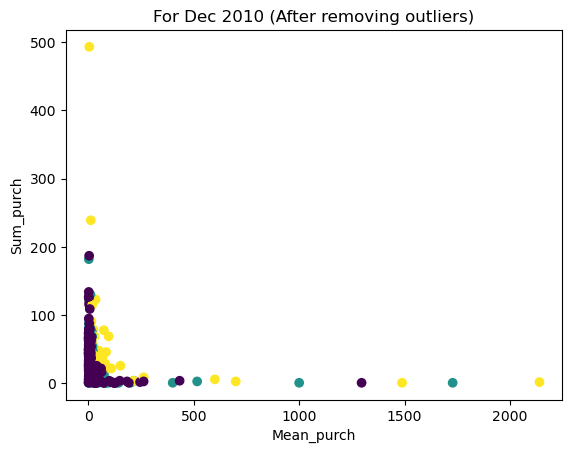

In [ ]:
plt.scatter(df_dec2010_new['Avg_quant'], df_dec2010_new['Item_count'], c=df_dec2010_new['cluster_labels'], cmap='viridis')
plt.title("For Dec 2010 (After removing outliers)")
plt.xlabel('Mean_purch')
plt.ylabel('Sum_purch')
plt.show()

In [ ]:
dec2010 = descrip_dict(og_dec2010,df_dec2010_new)
dec2010 = processlis(dec2010)

[     CustomerID                                        Description
 0             1  [BLACK CANDELABRA T-LIGHT HOLDER, AIRLINE BAG ...
 1             2  [72 SWEETHEART FAIRY CAKE CASES, 60 CAKE CASES...
 2            20  [WHITE HANGING HEART T-LIGHT HOLDER, SPACE CAD...
 3            26  [HOT WATER BOTTLE BABUSHKA LARGE, CHOCOLATE HO...
 4            31  [SET/10 RED POLKADOT PARTY CANDLES, SET/10 PIN...
 ..          ...                                                ...
 398        2226  [JAM MAKING SET WITH JARS, JAM MAKING SET PRIN...
 399        2227                       [HAND OPEN SHAPE DECO.WHITE]
 400        2230  [SKULL DESIGN TV DINNER TRAY, TV DINNER TRAY D...
 401        2235  [DANISH ROSE ROUND SEWING BOX, 3 STRIPEY MICE ...
 402        2237  [DOLLY GIRL LUNCH BOX, SPACEBOY LUNCH BOX , LU...
 
 [403 rows x 2 columns],
      CustomerID                                        Description
 0          2261  [CHOCOLATE HOT WATER BOTTLE, PAPER CHAIN KIT V...
 1          2283  [RE

### Agglomerative Clustering

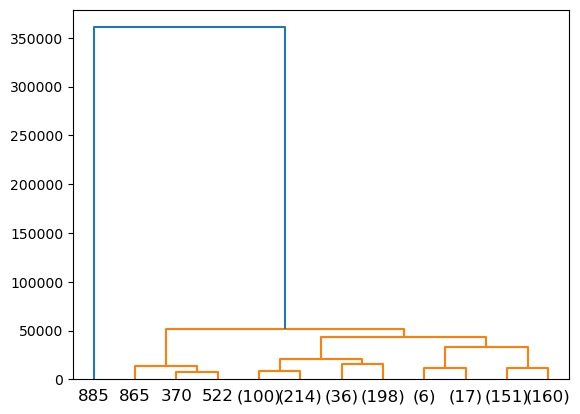

In [ ]:
pca = PCA(n_components = 3)
pca.fit(X = dvt)
new_dvt = pca.transform(dvt)

new_dvt = pd.DataFrame(data = new_dvt,columns = ['X0','X1','X2'])
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage='ward').fit(new_dvt)

plot_dendrogram(model, truncate_mode="level", p=4)
new_dvt

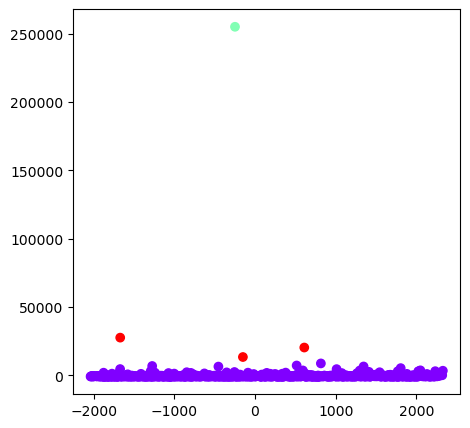

(882, 4)
(1, 4)
(3, 4)


In [ ]:
dict_dec2010 =  Agglocls(new_dvt,3)

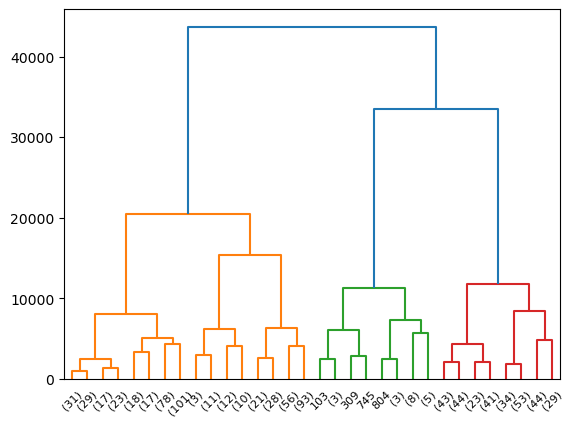

In [ ]:
#Thus Clusters 1 and 2 are outliers as they have very few datapoints(Customers)
#So we remove them and then apply KMeans again

final_dvt = dict_dec2010[0]
pca_dec2010_new = PCA(n_components = 3)
pca_dec2010_new.fit(X = final_dvt)
final_dvt = pca_dec2010_new.transform(final_dvt)
final_dvt = pd.DataFrame(data = final_dvt,columns = ['X0','X1','X2'])
AggloDendo(final_dvt)

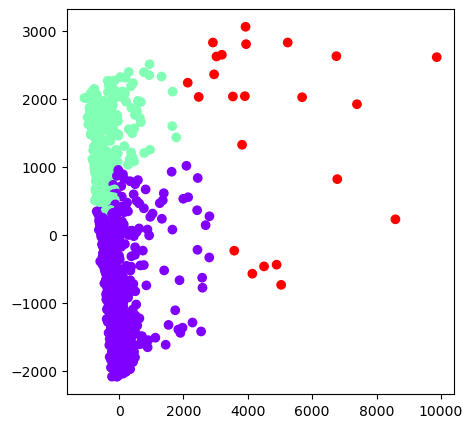

(548, 5)
(311, 5)
(23, 5)


In [ ]:
dict_dec2010_final =  AggloPca(final_dvt,3,dvt,'X1','X0')

In [ ]:
dec2010_agg = descrip_dict(og_dec2010,final_dvt)
dec2010_agg = processlis(dec2010_agg)

Cluster_dict['dec2010'] = (len(dec2010),len(dec2010_agg))
dicti_2010dec = {}
klis = []
for i in range(Cluster_dict['dec2010'][0]):
  temp = apriori_rules(dec2010[i],0.075)
  klis.append(temp)
alis = []
for i in range(Cluster_dict['dec2010'][1]):
  temp = apriori_rules(dec2010[i],0.075)
  alis.append(temp)

dicti_2010dec['K-means'] = klis
dicti_2010dec['Agglo'] = alis

Rules_dict['dec2010'] = dicti_2010dec

In [ ]:
te = TransactionEncoder()
tempi = dec2010_agg[0]

tempi = tempi['Description'].to_numpy()
tempi = list(tempi)
te_ary = te.fit(tempi).transform(tempi)
df_temp = pd.DataFrame(te_ary, columns=te.columns_)

OVAL WALL MIRROR DIAMANTE    SET 2 TEA TOWELS I LOVE LONDON   \
0                          False                             False   
1                          False                             False   
2                          False                             False   
3                          False                             False   
4                          False                             False   
..                           ...                               ...   
306                        False                             False   
307                        False                              True   
308                        False                             False   
309                        False                             False   
310                        False                             False   

     10 COLOUR SPACEBOY PEN  12 COLOURED PARTY BALLOONS  \
0                     False                       False   
1                     False                       False   
2                     False                       False   
3                     False                       False   
4                     False                       False   
..                      ...                         ...   
306                   False                       False   
307                   False                       False   
308                   False                       False   
309                   False                       False   
310                   False                       False   

     12 IVORY ROSE PEG PLACE SETTINGS  12 MESSAGE CARDS WITH ENVELOPES  \
0                               False                            False   
1                               False                            False   
2                               False                            False   
3                               False                            False   
4                               False                            False   
..                                ...                              ...   
306                             False                            False   
307                             False                            False   
308                             False                            False   
309                             False                            False   
310                             False                            False   

     12 PENCIL SMALL TUBE WOODLAND  12 PENCILS SMALL TUBE RED RETROSPOT  \
0                            False                                False   
1                            False                                False   
2                            False                                False   
3                            False                                False   
4                             True                                 True   
..                             ...                                  ...   
306                          False                                False   
307                          False                                False   
308                          False                                False   
309                          False                                False   
310                          False                                False   

     12 PENCILS SMALL TUBE SKULL  12 PENCILS TALL TUBE POSY  ...  \
0                          False                      False  ...   
1                          False                      False  ...   
2                           True                      False  ...   
3                          False                      False  ...   
4                           True                      False  ...   
..                           ...                        ...  ...   
306                        False                      False  ...   
307                        False                      False  ...   
308                        False                      

## For Jan 2011

In [ ]:
og_jan2011 = df_list_month_intervals[1]
og_jan2011

InvoiceNo StockCode                         Description  Quantity  \
42481    539993     22386             JUMBO BAG PINK POLKADOT        10   
42482    539993     21499                  BLUE POLKADOT WRAP        25   
42483    539993     21498                 RED RETROSPOT WRAP         25   
42484    539993     22379            RECYCLING BAG RETROSPOT          5   
42485    539993     20718           RED RETROSPOT SHOPPER BAG        10   
...         ...       ...                                 ...       ...   
77621    542745     22617          BAKING SET SPACEBOY DESIGN         8   
77622    542745     21108  FAIRY CAKE FLANNEL ASSORTED COLOUR        45   
77623    542745     22138       BAKING SET 9 PIECE RETROSPOT         13   
77624    542746     21034        REX CASH+CARRY JUMBO SHOPPER         2   
77627    542759     22649        STRAWBERRY FAIRY CAKE TEAPOT         1   

       UnitPrice  CustomerID         Country time_intervals  Total Price  \
42481       1.95         728  United Kingdom    08:00-11:59        19.50   
42482       0.42         728  United Kingdom    08:00-11:59        10.50   
42483       0.42         728  United Kingdom    08:00-11:59        10.50   
42484       2.10         728  United Kingdom    08:00-11:59        10.50   
42485       1.25         728  United Kingdom    08:00-11:59        12.50   
...          ...         ...             ...            ...          ...   
77621       4.95        2601  United Kingdom    12:00-15:59        39.60   
77622       2.10        2601  United Kingdom    12:00-15:59        94.50   
77623       4.95        2601  United Kingdom    12:00-15:59        64.35   
77624       0.95        2601  United Kingdom    12:00-15:59         1.90   
77627       4.95        2601  United Kingdom    12:00-15:59         4.95   

       Money_bins  
42481           0  
42482           0  
42483           0  
42484           0  
42485           0  
...           ...  
77621           0  
77622           0  
77623           0  
77624           0  
77627           0  

[34350 rows x 10 columns]

In [ ]:
#For Jan 2011
dvt_jan2011= person_df(og_jan2011)                          #Our function gives such a dataframe by which we can form clusters using KMeans

df_jan2011 = df_cluster_labels(dvt_jan2011,3)
df_jan2011

No. of visits    Mean_purch  Sum_purch  Item_count  Total_quantity  \
0                1  77183.600000   77183.60           1           74215   
1                1     16.392759     475.39          29             315   
2                1     37.906667     227.44           6             601   
3                1     63.100556    2271.62          36            1216   
4                1     34.218750     547.50          16             144   
..             ...           ...        ...         ...             ...   
737              2     20.887826     480.42          21             268   
738              1     15.685000     439.18          28             320   
739              1     21.425769     557.07          26             429   
740              2      2.107843     215.00          87             128   
741            133      9.294063  121919.52        1968           48569   

        Avg_quant  CustomerID  
0    74215.000000           0  
1       10.862069           1  
2      100.166667           2  
3       33.777778           9  
4        9.000000          12  
..            ...         ...  
737     11.652174        4306  
738     11.428571        4310  
739     16.500000        4320  
740      1.254902        4337  
741      3.702470        4339  

[742 rows x 7 columns]

In [ ]:
silhte_score_jan2011 = silhouette_score(dvt_jan2011, df_jan2011['cluster_labels'])
print("The Silhouette Score is :- "+str(silhte_score_jan2011))

df_jan2011['cluster_labels'].value_counts()
#Implies that there are outlier clusters

The Silhouette Score is :- 0.981276514170814


0    740
2      1
1      1
Name: cluster_labels, dtype: int64

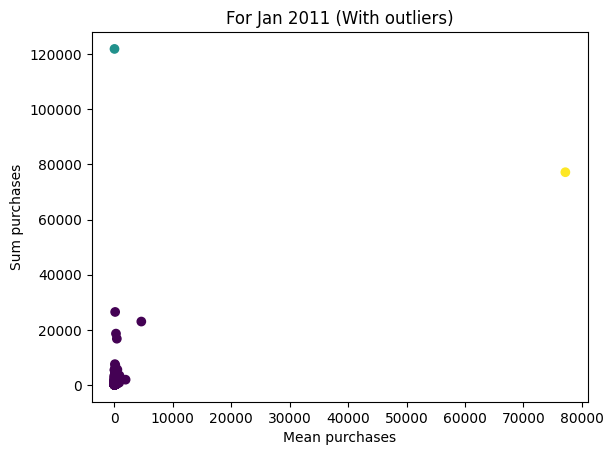

In [ ]:
plt.scatter(df_jan2011['Mean_purch'], df_jan2011['Sum_purch'], c=df_jan2011['cluster_labels'], cmap='viridis')
plt.title("For Jan 2011 (With outliers)")
plt.xlabel('Mean purchases')
plt.ylabel('Sum purchases')
plt.show()


In [ ]:
df_jan2011 = df_jan2011[df_jan2011['cluster_labels']!=1]
df_jan2011 = df_jan2011[df_jan2011['cluster_labels']!=2]

df_jan2011['cluster_labels'].value_counts()
#Thus the outliers are removed.

df_jan2011_person = df_jan2011.copy(deep=True)
df_jan2011_person.drop(['cluster_labels'],axis=1,inplace=True)

df_jan2011_new = df_cluster_labels(df_jan2011_person,3)
df_jan2011_new

No. of visits  Mean_purch  Sum_purch  Item_count  Total_quantity  \
1                1   16.392759     475.39          29             315   
2                1   37.906667     227.44           6             601   
3                1   63.100556    2271.62          36            1216   
4                1   34.218750     547.50          16             144   
5                1   18.429412     626.60          34             340   
..             ...         ...        ...         ...             ...   
736              1  440.000000     440.00           1               4   
737              2   20.887826     480.42          21             268   
738              1   15.685000     439.18          28             320   
739              1   21.425769     557.07          26             429   
740              2    2.107843     215.00          87             128   

      Avg_quant  CustomerID  cluster_labels  
1     10.862069           1               0  
2    100.166667           2               0  
3     33.777778           9               0  
4      9.000000          12               0  
5     10.000000          26               0  
..          ...         ...             ...  
736    4.000000        4302               0  
737   11.652174        4306               0  
738   11.428571        4310               0  
739   16.500000        4320               0  
740    1.254902        4337               0  

[740 rows x 8 columns]

In [ ]:
silhte_score_jan2011_new = silhouette_score(df_jan2011_person, df_jan2011_new['cluster_labels'])
print("The Silhouette Score is :- "+str(silhte_score_jan2011_new))
#Indicates that silhouette score is realistic for dataset without outliers

df_jan2011_new['CustomerID'] = dvt_jan2011['CustomerID']
print(df_jan2011_new['cluster_labels'].value_counts())

plt.scatter(df_jan2011_new['CustomerID'], df_jan2011_new['Mean_purch'], c=df_jan2011_new['cluster_labels'], cmap='viridis')
plt.title("For Jan 2011 (After removing outliers)")
plt.xlabel("CustomerID")
plt.ylabel('Mean_purch')
plt.show()

The Silhouette Score is :- 0.515667097110596


In [ ]:
jan2011 = descrip_dict(og_jan2011,df_jan2011_new)
jan2011 = processlis(jan2011)

pca = PCA(n_components = 3)
pca.fit(X = dvt_jan2011)
new_dvt = pca.transform(dvt_jan2011)

new_dvt = pd.DataFrame(data = new_dvt,columns = ['X0','X1','X2'])
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage='ward').fit(new_dvt)

plot_dendrogram(model, truncate_mode="level", p=4)

[     CustomerID                                        Description
 0             1  [PINK NEW BAROQUECANDLESTICK CANDLE, BLUE NEW ...
 1             2  [PACK OF 12 RED RETROSPOT TISSUES , PACK OF 12...
 2             9  [BAKING SET 9 PIECE RETROSPOT , WHITE HEART CO...
 3            12  [RETROSPOT BABUSHKA DOORSTOP, GINGHAM BABUSHKA...
 4            26  [STRAWBERRY HONEYCOMB  GARLAND , SMALL POPCORN...
 ..          ...                                                ...
 399        2177  [5 HOOK HANGER MAGIC TOADSTOOL, GUMBALL MONOCH...
 400        2212  [TEA PARTY BIRTHDAY CARD, FAIRY CAKES NOTEBOOK...
 401        2226  [LOVE HEART POCKET WARMER, JUMBO STORAGE BAG S...
 402        2313  [HAND WARMER OWL DESIGN, CHICK GREY HOT WATER ...
 403        2518  [RED 3 PIECE RETROSPOT CUTLERY SET, GREEN 3 PI...
 
 [404 rows x 2 columns],
      CustomerID                                        Description
 0          2142  [3 HOOK PHOTO SHELF ANTIQUE WHITE, IVORY HANGI...
 1          2146  [SE

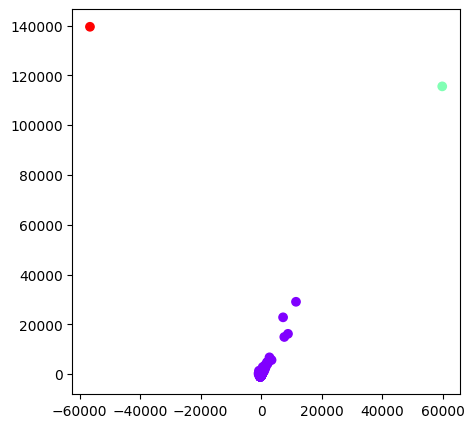

(740, 4)
(1, 4)
(1, 4)


In [ ]:
dict_jan2011 =  Agglocls(new_dvt,3)

final_dvt_jan2011 = dict_jan2011[0]
pca_jan2011_new = PCA(n_components = 3)
pca_jan2011_new.fit(X = final_dvt_jan2011)
final_dvt_jan2011 = pca_jan2011_new.transform(final_dvt_jan2011)
final_dvt_jan2011 = pd.DataFrame(data = final_dvt_jan2011,columns = ['X0','X1','X2'])
AggloDendo(final_dvt_jan2011)


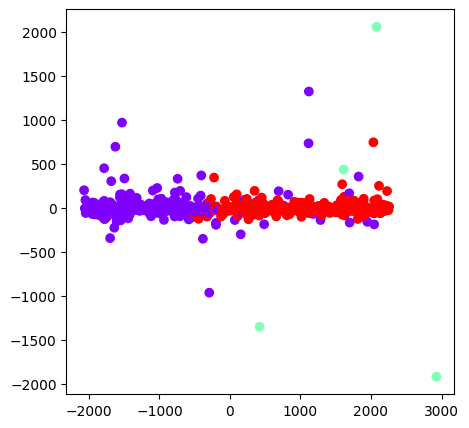

(372, 5)
(4, 5)
(364, 5)


In [ ]:
dict_jan2011_final =  AggloPca(final_dvt_jan2011,3,dvt_jan2011,'X1','X2')

In [ ]:
jan2011_agg = descrip_dict(og_jan2011,final_dvt_jan2011)
jan2011_agg = processlis(jan2011_agg)
jan2011_agg

[     CustomerID                                        Description
 0             0                   [MEDIUM CERAMIC TOP STORAGE JAR]
 1             1  [PINK NEW BAROQUECANDLESTICK CANDLE, BLUE NEW ...
 2             2  [PACK OF 12 RED RETROSPOT TISSUES , PACK OF 12...
 3             9  [BAKING SET 9 PIECE RETROSPOT , WHITE HEART CO...
 4            12  [RETROSPOT BABUSHKA DOORSTOP, GINGHAM BABUSHKA...
 ..          ...                                                ...
 367        3692  [SET OF 6 SOLDIER SKITTLES, CHILDS BREAKFAST S...
 368        3694  [MAGIC DRAWING SLATE DOLLY GIRL , SET OF 3 CAK...
 369        3706  [EASTER DECORATION SITTING BUNNY, BLUE PAISLEY...
 370        3765  [VINTAGE BILLBOARD TEA MUG, ZINC WILLIE WINKIE...
 371        3993  [Manual, RETROSPOT PADDED SEAT CUSHION, RED RE...
 
 [372 rows x 2 columns],
      CustomerID                                        Description
 0          1516  [RETROSPOT HEART HOT WATER BOTTLE, GREY HEART ...
 1          1535  [VI

In [ ]:
Cluster_dict['jan2011'] = (len(jan2011),len(jan2011_agg))
dicti_2011jan = {}
klis = []
for i in range(Cluster_dict['jan2011'][0]):
  temp = apriori_rules(jan2011[i],0.075)
  klis.append(temp)
alis = []
for i in range(Cluster_dict['jan2011'][1]):
  temp = apriori_rules(jan2011_agg[i],0.075)
  alis.append(temp)
#apriori_rules(1_agg[0],0.075)
dicti_2011jan['K-means'] = klis
dicti_2011jan['Agglo'] = alis

Rules_dict['jan2011'] = dicti_2011jan

## For Feb 2011

In [ ]:
og_feb2011 = df_list_month_intervals[2]
og_feb2011

InvoiceNo StockCode                        Description  Quantity  \
77628     542776     21671       RED SPOT CERAMIC DRAWER KNOB        48   
77629     542776     21668     RED STRIPE CERAMIC DRAWER KNOB        12   
77630     542776     21670      BLUE SPOT CERAMIC DRAWER KNOB        12   
77631     542776    17013D       ORIGAMI ROSE INCENSE IN TUBE        96   
77632     542776     17096  ASSORTED LAQUERED INCENSE HOLDERS        48   
...          ...       ...                                ...       ...   
105329    545218    85099B            JUMBO BAG RED RETROSPOT        10   
105330    545218     21936           RED RETROSPOT PICNIC BAG         5   
105331    545218     21932    SCANDINAVIAN PAISLEY PICNIC BAG         5   
105332    545218     22386            JUMBO BAG PINK POLKADOT        10   
105333    545218     21933    PINK VINTAGE PAISLEY PICNIC BAG         5   

        UnitPrice  CustomerID         Country time_intervals  Total Price  \
77628        1.25        2124  United Kingdom    04:00-07:59        60.00   
77629        1.25        2124  United Kingdom    04:00-07:59        15.00   
77630        1.25        2124  United Kingdom    04:00-07:59        15.00   
77631        0.42        2124  United Kingdom    04:00-07:59        40.32   
77632        0.21        2124  United Kingdom    04:00-07:59        10.08   
...           ...         ...             ...            ...          ...   
105329       1.95        3740  United Kingdom    16:00-19:59        19.50   
105330       2.95        3740  United Kingdom    16:00-19:59        14.75   
105331       2.95        3740  United Kingdom    16:00-19:59        14.75   
105332       1.95        3740  United Kingdom    16:00-19:59        19.50   
105333       2.95        3740  United Kingdom    16:00-19:59        14.75   

        Money_bins  
77628            0  
77629            0  
77630            0  
77631            0  
77632            0  
...            ...  
105329           0  
105330           0  
105331           0  
105332           0  
105333           0  

[27184 rows x 10 columns]

In [ ]:
#For Feb 2011
dvt_feb2011= person_df(og_feb2011) #Our function gives such a dataframe
#By which we can form clusters using KMeans
dvt_feb2011

No. of visits  Mean_purch  Sum_purch  Item_count  Total_quantity  \
0                1   19.670588     334.40          17             197   
1                1   19.766667     296.50          15              98   
2                1   22.986375    1838.91          80             465   
3                1   18.990000     189.90          10              91   
4                1   17.744444     479.10          27             229   
..             ...         ...        ...         ...             ...   
754              1   29.100000     291.00          10             180   
755              1   16.631905     349.27          21             199   
756              2   22.737500     363.80          16             124   
757              1    3.430000     102.90          29              59   
758            128   10.542246   76494.54        1644           21057   

     Avg_quant  CustomerID  
0    11.588235           4  
1     6.533333           5  
2     5.812500          12  
3     9.100000          14  
4     8.481481          15  
..         ...         ...  
754  18.000000        4300  
755   9.476190        4314  
756   7.750000        4318  
757   1.966667        4337  
758   2.902012        4339  

[759 rows x 7 columns]

In [ ]:
df_feb2011 = df_cluster_labels(dvt_feb2011,3)
df_feb2011

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


No. of visits  Mean_purch  Sum_purch  Item_count  Total_quantity  \
0                1   19.670588     334.40          17             197   
1                1   19.766667     296.50          15              98   
2                1   22.986375    1838.91          80             465   
3                1   18.990000     189.90          10              91   
4                1   17.744444     479.10          27             229   
..             ...         ...        ...         ...             ...   
754              1   29.100000     291.00          10             180   
755              1   16.631905     349.27          21             199   
756              2   22.737500     363.80          16             124   
757              1    3.430000     102.90          29              59   
758            128   10.542246   76494.54        1644           21057   

     Avg_quant  CustomerID  cluster_labels  
0    11.588235           4               0  
1     6.533333           5               0  
2     5.812500          12               0  
3     9.100000          14               0  
4     8.481481          15               0  
..         ...         ...             ...  
754  18.000000        4300               0  
755   9.476190        4314               0  
756   7.750000        4318               0  
757   1.966667        4337               0  
758   2.902012        4339               1  

[759 rows x 8 columns]

In [ ]:
silhte_score_feb2011 = silhouette_score(dvt_feb2011, df_feb2011['cluster_labels'])
print("The Silhouette Score is :- "+str(silhte_score_feb2011))

The Silhouette Score is :- 0.7862449474902387


In [ ]:
df_feb2011['cluster_labels'].value_counts()

0    742
2     16
1      1
Name: cluster_labels, dtype: int64

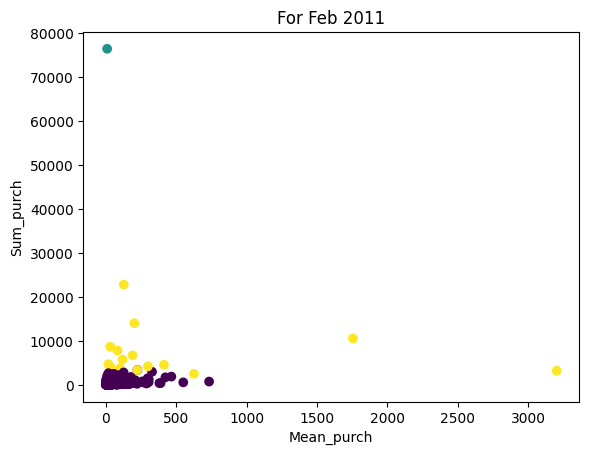

In [ ]:
plt.scatter(df_feb2011['Mean_purch'], df_feb2011['Sum_purch'], c=df_feb2011['cluster_labels'], cmap='viridis')
plt.title("For Feb 2011")
plt.xlabel('Mean_purch')
plt.ylabel('Sum_purch')
plt.show()

In [ ]:
df_feb2011 = df_feb2011[df_feb2011['cluster_labels']!=1]
df_feb2011

No. of visits  Mean_purch  Sum_purch  Item_count  Total_quantity  \
0                1   19.670588     334.40          17             197   
1                1   19.766667     296.50          15              98   
2                1   22.986375    1838.91          80             465   
3                1   18.990000     189.90          10              91   
4                1   17.744444     479.10          27             229   
..             ...         ...        ...         ...             ...   
753              1   25.823333     464.82          18             212   
754              1   29.100000     291.00          10             180   
755              1   16.631905     349.27          21             199   
756              2   22.737500     363.80          16             124   
757              1    3.430000     102.90          29              59   

     Avg_quant  CustomerID  cluster_labels  
0    11.588235           4               0  
1     6.533333           5               0  
2     5.812500          12               0  
3     9.100000          14               0  
4     8.481481          15               0  
..         ...         ...             ...  
753  11.777778        4299               0  
754  18.000000        4300               0  
755   9.476190        4314               0  
756   7.750000        4318               0  
757   1.966667        4337               0  

[758 rows x 8 columns]

In [ ]:
df_feb2011['cluster_labels'].value_counts()

0    742
2     16
Name: cluster_labels, dtype: int64

In [ ]:
df_feb2011_person = df_feb2011.copy(deep=True)
df_feb2011_person.drop(['cluster_labels'],axis=1,inplace=True)
df_feb2011_person

No. of visits  Mean_purch  Sum_purch  Item_count  Total_quantity  \
0                1   19.670588     334.40          17             197   
1                1   19.766667     296.50          15              98   
2                1   22.986375    1838.91          80             465   
3                1   18.990000     189.90          10              91   
4                1   17.744444     479.10          27             229   
..             ...         ...        ...         ...             ...   
753              1   25.823333     464.82          18             212   
754              1   29.100000     291.00          10             180   
755              1   16.631905     349.27          21             199   
756              2   22.737500     363.80          16             124   
757              1    3.430000     102.90          29              59   

     Avg_quant  CustomerID  
0    11.588235           4  
1     6.533333           5  
2     5.812500          12  
3     9.100000          14  
4     8.481481          15  
..         ...         ...  
753  11.777778        4299  
754  18.000000        4300  
755   9.476190        4314  
756   7.750000        4318  
757   1.966667        4337  

[758 rows x 7 columns]

In [ ]:
df_feb2011_new = df_cluster_labels(df_feb2011_person,3)
df_feb2011_new

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


No. of visits  Mean_purch  Sum_purch  Item_count  Total_quantity  \
0                1   19.670588     334.40          17             197   
1                1   19.766667     296.50          15              98   
2                1   22.986375    1838.91          80             465   
3                1   18.990000     189.90          10              91   
4                1   17.744444     479.10          27             229   
..             ...         ...        ...         ...             ...   
753              1   25.823333     464.82          18             212   
754              1   29.100000     291.00          10             180   
755              1   16.631905     349.27          21             199   
756              2   22.737500     363.80          16             124   
757              1    3.430000     102.90          29              59   

     Avg_quant  CustomerID  cluster_labels  
0    11.588235           4               0  
1     6.533333           5               0  
2     5.812500          12               0  
3     9.100000          14               0  
4     8.481481          15               0  
..         ...         ...             ...  
753  11.777778        4299               1  
754  18.000000        4300               1  
755   9.476190        4314               1  
756   7.750000        4318               1  
757   1.966667        4337               1  

[758 rows x 8 columns]

In [ ]:
silhte_score_feb2011_new = silhouette_score(df_feb2011_person, df_feb2011_new['cluster_labels'])
print("The Silhouette Score is :- "+str(silhte_score_feb2011_new))
#Indicates that silhouette score is realistic for dataset without outliers

The Silhouette Score is :- 0.5438676410222071


In [ ]:
df_feb2011_new['cluster_labels'].value_counts()

0    389
1    363
2      6
Name: cluster_labels, dtype: int64

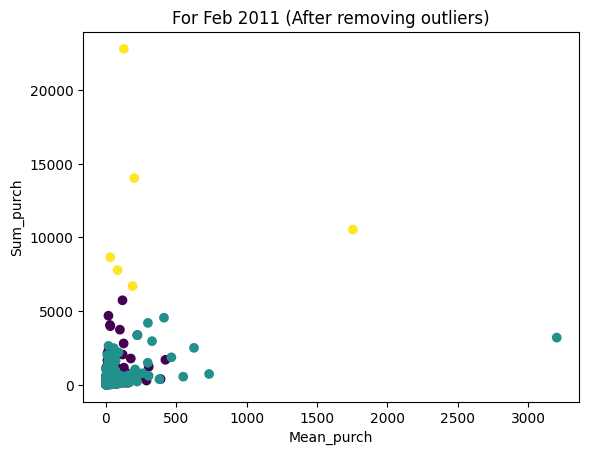

In [ ]:
plt.scatter(df_feb2011_new['Mean_purch'], df_feb2011_new['Sum_purch'], c=df_feb2011_new['cluster_labels'], cmap='viridis')
plt.title("For Feb 2011 (After removing outliers)")
plt.xlabel('Mean_purch')
plt.ylabel('Sum_purch')
plt.show()

In [ ]:
feb2011 = descrip_dict(og_feb2011,df_feb2011_new)
feb2011 = processlis(feb2011)

In [ ]:
feb2011

[     CustomerID                                        Description
 0             4  [CHOCOLATE THIS WAY METAL SIGN, METAL SIGN NEI...
 1             5  [WOODEN HAPPY BIRTHDAY GARLAND, PINK DOUGHNUT ...
 2            12  [DOORMAT WELCOME TO OUR HOME, HERB MARKER PARS...
 3            14  [DOLLY GIRL LUNCH BOX, ROUND SNACK BOXES SET O...
 4            15  [VINTAGE SEASIDE JIGSAW PUZZLES, WATERING CAN ...
 ..          ...                                                ...
 384        2158  [SET/5 RED RETROSPOT LID GLASS BOWLS, RED RETR...
 385        2163  [BOX OF VINTAGE ALPHABET BLOCKS, PLASTERS IN T...
 386        2172  [REGENCY CAKESTAND 3 TIER, WHITE HANGING HEART...
 387        2177  [PAPER BUNTING WHITE LACE, SET OF 4 POLKADOT P...
 388        2186  [CHILDS GARDEN BRUSH BLUE, CHILDS GARDEN BRUSH...
 
 [389 rows x 2 columns],
      CustomerID                                        Description
 0          2211  [BOX OF 9 PEBBLE CANDLES, CAROUSEL DESIGN WASH...
 1          2212  [SE

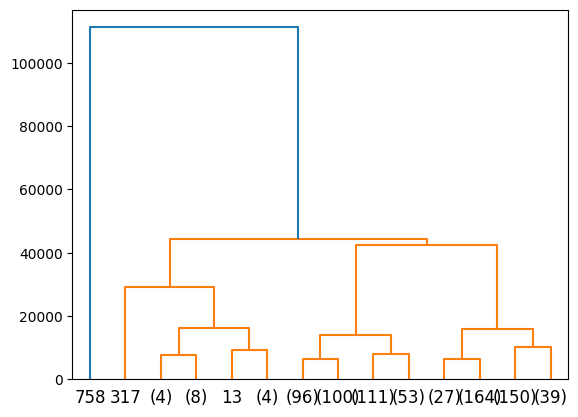

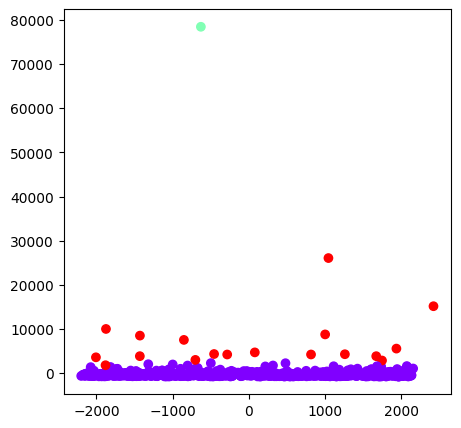

(740, 4)
(1, 4)
(18, 4)


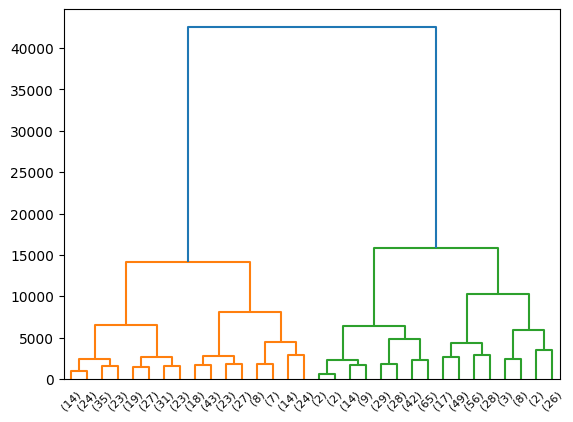

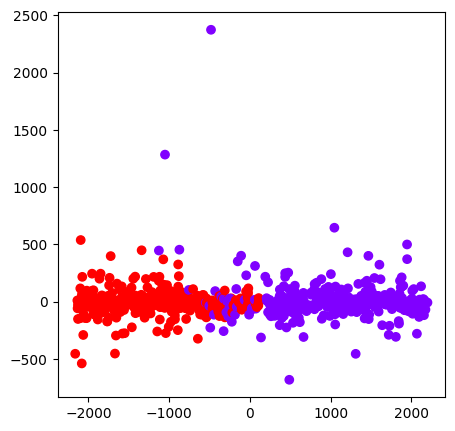

(380, 5)
(360, 5)


[     CustomerID                                        Description
 0             4  [CHOCOLATE THIS WAY METAL SIGN, METAL SIGN NEI...
 1             5  [WOODEN HAPPY BIRTHDAY GARLAND, PINK DOUGHNUT ...
 2            12  [DOORMAT WELCOME TO OUR HOME, HERB MARKER PARS...
 3            14  [DOLLY GIRL LUNCH BOX, ROUND SNACK BOXES SET O...
 4            15  [VINTAGE SEASIDE JIGSAW PUZZLES, WATERING CAN ...
 ..          ...                                                ...
 355        2149  [CREAM WALL PLANTER HEART SHAPED, NATURAL SLAT...
 356        2163  [BOX OF VINTAGE ALPHABET BLOCKS, PLASTERS IN T...
 357        2172  [REGENCY CAKESTAND 3 TIER, WHITE HANGING HEART...
 358        2177  [PAPER BUNTING WHITE LACE, SET OF 4 POLKADOT P...
 359        2186  [CHILDS GARDEN BRUSH BLUE, CHILDS GARDEN BRUSH...
 
 [360 rows x 2 columns],
      CustomerID                                        Description
 0          1014  [COLOURING PENCILS BROWN TUBE, ENGLISH ROSE GA...
 1          1076  [GL

In [ ]:
pca = PCA(n_components = 3)
pca.fit(X = dvt_feb2011)
new_dvt = pca.transform(dvt_feb2011)

new_dvt = pd.DataFrame(data = new_dvt,columns = ['X0','X1','X2'])
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage='ward').fit(new_dvt)

plot_dendrogram(model, truncate_mode="level", p=4)

dict_feb2011 =  Agglocls(new_dvt,3)

final_dvt_feb2011 = dict_feb2011[0]
pca_feb2011 = PCA(n_components = 3)
pca_feb2011.fit(X = final_dvt_feb2011)
final_dvt_feb2011 = pca_feb2011.transform(final_dvt_feb2011)
final_dvt_feb2011 = pd.DataFrame(data = final_dvt_feb2011,columns = ['X0','X1','X2'])
AggloDendo(final_dvt_feb2011)

dict_feb2011_final =  AggloPca(final_dvt_feb2011,2,dvt_feb2011,'X0','X2')

feb2011_agg = descrip_dict(og_feb2011,final_dvt_feb2011)
feb2011_agg = processlis(feb2011_agg)
feb2011_agg




In [ ]:
Cluster_dict['feb2011'] = (len(feb2011),len(feb2011_agg))
dicti_2011feb = {}
klis = []
for i in range(Cluster_dict['feb2011'][0]):
  temp = apriori_rules(feb2011[i],0.075)
  klis.append(temp)
alis = []
for i in range(Cluster_dict['feb2011'][1]):
  temp = apriori_rules(feb2011_agg[i],0.075)
  alis.append(temp)
#apriori_rules(1_agg[0],0.075)
dicti_2011feb['K-means'] = klis
dicti_2011feb['Agglo'] = alis

Rules_dict['feb2011'] = dicti_2011feb

## For March 2011

In [ ]:
og_mar2011 = df_list_month_intervals[3]
og_mar2011

InvoiceNo StockCode                          Description  Quantity  \
105335    545220     21955    DOORMAT UNION JACK GUNS AND ROSES         2   
105336    545220     48194                       DOORMAT HEARTS         2   
105337    545220     22556       PLASTERS IN TIN CIRCUS PARADE         12   
105338    545220     22139     RETROSPOT TEA SET CERAMIC 11 PC          3   
105339    545220    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         4   
...          ...       ...                                  ...       ...   
142078    548548     22423             REGENCY CAKESTAND 3 TIER         1   
142079    548548     21361             LOVE LARGE WOOD LETTERS          7   
142080    548549     84763        ZINC FINISH 15CM PLANTER POTS       100   
142081    548549     22222            CAKE PLATE LOVEBIRD WHITE         1   
142082    548549     22776          SWEETHEART CAKESTAND 3 TIER         1   

        UnitPrice  CustomerID         Country time_intervals  Total Price  \
105335       7.95        1669  United Kingdom    04:00-07:59        15.90   
105336       7.95        1669  United Kingdom    04:00-07:59        15.90   
105337       1.65        1669  United Kingdom    04:00-07:59        19.80   
105338       4.95        1669  United Kingdom    04:00-07:59        14.85   
105339       3.75        1669  United Kingdom    04:00-07:59        15.00   
...           ...         ...             ...            ...          ...   
142078      12.75        3974  United Kingdom    16:00-19:59        12.75   
142079      12.75        3974  United Kingdom    16:00-19:59        89.25   
142080       1.06        2949  United Kingdom    16:00-19:59       106.00   
142081       4.95        2949  United Kingdom    16:00-19:59         4.95   
142082       9.95        2949  United Kingdom    16:00-19:59         9.95   

        Money_bins  
105335           0  
105336           0  
105337           0  
105338           0  
105339           0  
...            ...  
142078           0  
142079           0  
142080           0  
142081           0  
142082           0  

[35915 rows x 10 columns]

In [ ]:
dvt_mar2011= person_df(og_mar2011) #Our function gives such a dataframe
#By which we can form clusters using KMeans
dvt_mar2011

No. of visits  Mean_purch  Sum_purch  Item_count  Total_quantity  \
0                4   55.013478    1265.31          12             156   
1                1   19.549792     938.39          48            1005   
2                1   23.804667     357.07          15              91   
3                1   21.090000     210.90          10              90   
4                1   32.650000     326.50          10             321   
..             ...         ...        ...         ...             ...   
970              1   15.678571     548.75          34             356   
971              1   22.390000     111.95           5              41   
972              1   51.000000      51.00           1              20   
973              1   18.060000     180.60          10              45   
974            210   13.977867  122138.60        1836           36406   

     Avg_quant  CustomerID  
0     6.782609           5  
1    20.937500          20  
2     6.066667          31  
3     9.000000          34  
4    32.100000          39  
..         ...         ...  
970  10.171429        4320  
971   8.200000        4327  
972  20.000000        4329  
973   4.500000        4334  
974   4.166400        4339  

[975 rows x 7 columns]

In [ ]:
df_mar2011 = df_cluster_labels(dvt_mar2011,3)

df_mar2011

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


No. of visits  Mean_purch  Sum_purch  Item_count  Total_quantity  \
0                4   55.013478    1265.31          12             156   
1                1   19.549792     938.39          48            1005   
2                1   23.804667     357.07          15              91   
3                1   21.090000     210.90          10              90   
4                1   32.650000     326.50          10             321   
..             ...         ...        ...         ...             ...   
970              1   15.678571     548.75          34             356   
971              1   22.390000     111.95           5              41   
972              1   51.000000      51.00           1              20   
973              1   18.060000     180.60          10              45   
974            210   13.977867  122138.60        1836           36406   

     Avg_quant  CustomerID  cluster_labels  
0     6.782609           5               0  
1    20.937500          20               0  
2     6.066667          31               0  
3     9.000000          34               0  
4    32.100000          39               0  
..         ...         ...             ...  
970  10.171429        4320               0  
971   8.200000        4327               0  
972  20.000000        4329               0  
973   4.500000        4334               0  
974   4.166400        4339               1  

[975 rows x 8 columns]

In [ ]:
silhte_score_mar2011 = silhouette_score(dvt_mar2011, df_mar2011['cluster_labels'])
print("The Silhouette Score is :- "+str(silhte_score_mar2011))

The Silhouette Score is :- 0.845799404094935


In [ ]:
df_mar2011['cluster_labels'].value_counts()

0    962
2     12
1      1
Name: cluster_labels, dtype: int64

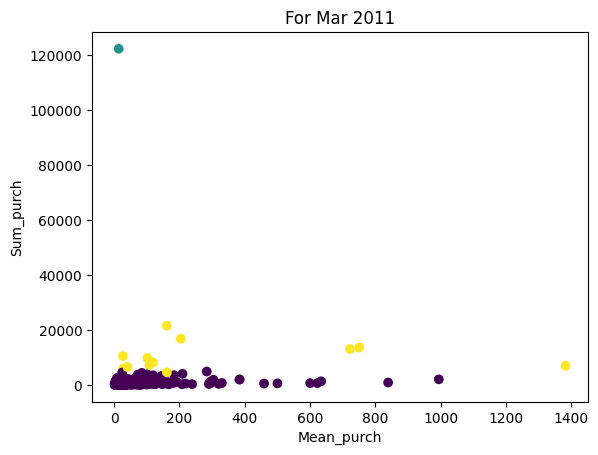

In [ ]:
plt.scatter(df_mar2011['Mean_purch'], df_mar2011['Sum_purch'], c=df_mar2011['cluster_labels'], cmap='viridis')
plt.title("For Mar 2011")
plt.xlabel('Mean_purch')
plt.ylabel('Sum_purch')
plt.show()

In [ ]:
df_mar2011 = df_mar2011[df_mar2011['cluster_labels']!=1]
df_mar2011 = df_mar2011[df_mar2011['cluster_labels']!=2]
df_mar2011

No. of visits  Mean_purch  Sum_purch  Item_count  Total_quantity  \
0                4   55.013478    1265.31          12             156   
1                1   19.549792     938.39          48            1005   
2                1   23.804667     357.07          15              91   
3                1   21.090000     210.90          10              90   
4                1   32.650000     326.50          10             321   
..             ...         ...        ...         ...             ...   
969              1   17.638000     176.38          10             122   
970              1   15.678571     548.75          34             356   
971              1   22.390000     111.95           5              41   
972              1   51.000000      51.00           1              20   
973              1   18.060000     180.60          10              45   

     Avg_quant  CustomerID  cluster_labels  
0     6.782609           5               0  
1    20.937500          20               0  
2     6.066667          31               0  
3     9.000000          34               0  
4    32.100000          39               0  
..         ...         ...             ...  
969  12.200000        4306               0  
970  10.171429        4320               0  
971   8.200000        4327               0  
972  20.000000        4329               0  
973   4.500000        4334               0  

[962 rows x 8 columns]

In [ ]:
df_mar2011['cluster_labels'].value_counts()

0    962
Name: cluster_labels, dtype: int64

In [ ]:
df_mar2011_person = df_mar2011.copy(deep=True)
df_mar2011_person.drop(['cluster_labels'],axis=1,inplace=True)
df_mar2011_person

No. of visits  Mean_purch  Sum_purch  Item_count  Total_quantity  \
0                4   55.013478    1265.31          12             156   
1                1   19.549792     938.39          48            1005   
2                1   23.804667     357.07          15              91   
3                1   21.090000     210.90          10              90   
4                1   32.650000     326.50          10             321   
..             ...         ...        ...         ...             ...   
969              1   17.638000     176.38          10             122   
970              1   15.678571     548.75          34             356   
971              1   22.390000     111.95           5              41   
972              1   51.000000      51.00           1              20   
973              1   18.060000     180.60          10              45   

     Avg_quant  CustomerID  
0     6.782609           5  
1    20.937500          20  
2     6.066667          31  
3     9.000000          34  
4    32.100000          39  
..         ...         ...  
969  12.200000        4306  
970  10.171429        4320  
971   8.200000        4327  
972  20.000000        4329  
973   4.500000        4334  

[962 rows x 7 columns]

In [ ]:
df_mar2011_new = df_cluster_labels(df_mar2011_person,3)
df_mar2011_new

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


No. of visits  Mean_purch  Sum_purch  Item_count  Total_quantity  \
0                4   55.013478    1265.31          12             156   
1                1   19.549792     938.39          48            1005   
2                1   23.804667     357.07          15              91   
3                1   21.090000     210.90          10              90   
4                1   32.650000     326.50          10             321   
..             ...         ...        ...         ...             ...   
969              1   17.638000     176.38          10             122   
970              1   15.678571     548.75          34             356   
971              1   22.390000     111.95           5              41   
972              1   51.000000      51.00           1              20   
973              1   18.060000     180.60          10              45   

     Avg_quant  CustomerID  cluster_labels  
0     6.782609           5               0  
1    20.937500          20               0  
2     6.066667          31               0  
3     9.000000          34               0  
4    32.100000          39               0  
..         ...         ...             ...  
969  12.200000        4306               1  
970  10.171429        4320               1  
971   8.200000        4327               1  
972  20.000000        4329               1  
973   4.500000        4334               1  

[962 rows x 8 columns]

In [ ]:
silhte_score_mar2011_new = silhouette_score(df_mar2011_person, df_mar2011_new['cluster_labels'])
print("The Silhouette Score is :- "+str(silhte_score_mar2011_new))
#Indicates that silhouette score is realistic for dataset without outliers

The Silhouette Score is :- 0.5468712198885177


In [ ]:
df_mar2011_new['cluster_labels'].value_counts()
#These are comparatively good clusters

0    482
1    453
2     27
Name: cluster_labels, dtype: int64

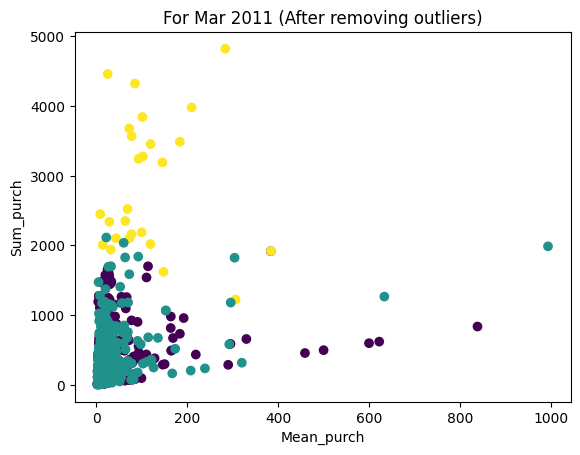

In [ ]:
plt.scatter(df_mar2011_new['Mean_purch'], df_mar2011_new['Sum_purch'], c=df_mar2011_new['cluster_labels'], cmap='viridis')
plt.title("For Mar 2011 (After removing outliers)")
plt.xlabel('Mean_purch')
plt.ylabel('Sum_purch')
plt.show()

In [ ]:
mar2011 = descrip_dict(og_mar2011,df_mar2011_new)
mar2011 = processlis(mar2011)

In [ ]:
mar2011

[     CustomerID                                        Description
 0             5  [POSTAGE, DELUXE SEWING KIT , PINK HEART SHAPE...
 1            20  [GIRLS ALPHABET IRON ON PATCHES , BOYS ALPHABE...
 2            31  [RETROSPOT PARTY BAG + STICKER SET, ORGANISER ...
 3            34  [SET 3 SONG BIRD PAPER EGGS ASSORTED, SET 3 PA...
 4            39  [CHARLOTTE BAG DOLLY GIRL DESIGN, CHARLOTTE BA...
 ..          ...                                                ...
 477        2163  [PAPER CHAIN KIT EMPIRE, SET/20 STRAWBERRY PAP...
 478        2164  [Manual, DOORMAT FAIRY CAKE, DOORMAT SPOTTY HO...
 479        2168  [CHILLI LIGHTS, SET/5 RED RETROSPOT LID GLASS ...
 480        2169                     [HOMEMADE JAM SCENTED CANDLES]
 481        2171                                    [PARTY BUNTING]
 
 [482 rows x 2 columns],
      CustomerID                                        Description
 0          2173  [LANTERN CREAM GAZEBO , REGENCY CAKESTAND 3 TI...
 1          2176  [PI

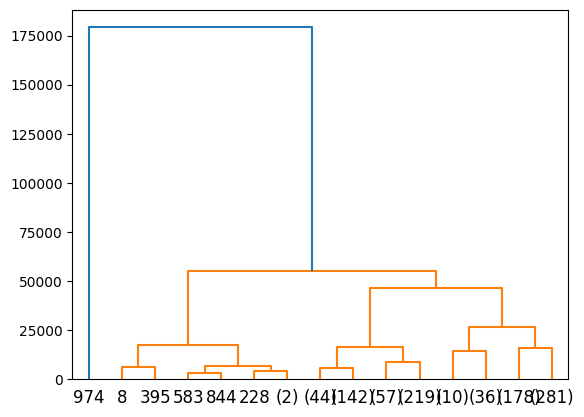

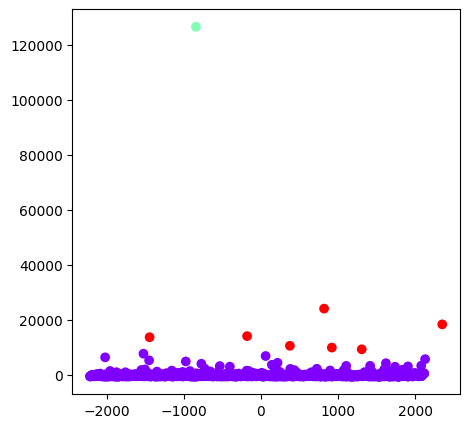

(967, 4)
(1, 4)
(7, 4)


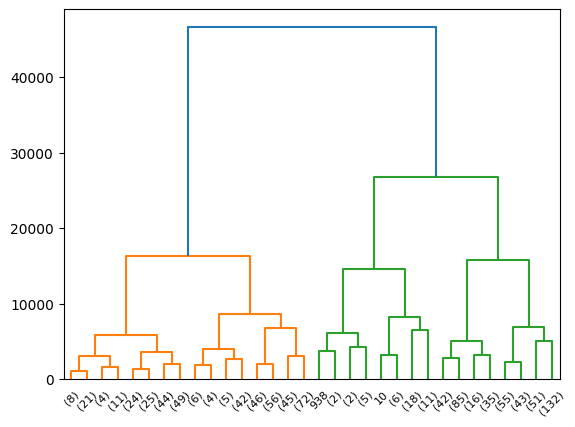

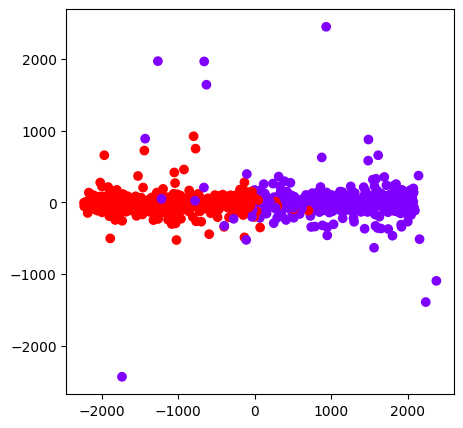

(505, 5)
(462, 5)


[     CustomerID                                        Description
 0             5  [POSTAGE, DELUXE SEWING KIT , PINK HEART SHAPE...
 1            20  [GIRLS ALPHABET IRON ON PATCHES , BOYS ALPHABE...
 2            31  [RETROSPOT PARTY BAG + STICKER SET, ORGANISER ...
 3            34  [SET 3 SONG BIRD PAPER EGGS ASSORTED, SET 3 PA...
 4            39  [CHARLOTTE BAG DOLLY GIRL DESIGN, CHARLOTTE BA...
 ..          ...                                                ...
 500        3157  [BAG 250g SWIRLY MARBLES, VINTAGE SNAP CARDS, ...
 501        3653  [DOORMAT RED RETROSPOT, DOORMAT 3 SMILEY CATS,...
 502        3671  [FELTCRAFT CUSHION OWL, FELTCRAFT CUSHION RABB...
 503        3729  [HEART OF WICKER SMALL, VINTAGE UNION JACK BUN...
 504        4156    [LUNCH BOX I LOVE LONDON, DOLLY GIRL LUNCH BOX]
 
 [505 rows x 2 columns],
      CustomerID                                        Description
 0          1469  [3 HOOK PHOTO SHELF ANTIQUE WHITE, VINTAGE SNA...
 1          1649  [PA

In [ ]:
pca = PCA(n_components = 3)
pca.fit(X = dvt_mar2011)
new_dvt = pca.transform(dvt_mar2011)

new_dvt = pd.DataFrame(data = new_dvt,columns = ['X0','X1','X2'])
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage='ward').fit(new_dvt)

plot_dendrogram(model, truncate_mode="level", p=4)

dict_mar2011 =  Agglocls(new_dvt,3)

final_dvt_mar2011 = dict_mar2011[0]
pca_mar2011 = PCA(n_components = 3)
pca_mar2011.fit(X = final_dvt_mar2011)
final_dvt_mar2011 = pca_mar2011.transform(final_dvt_mar2011)
final_dvt_mar2011 = pd.DataFrame(data = final_dvt_mar2011,columns = ['X0','X1','X2'])
AggloDendo(final_dvt_mar2011)

dict_mar2011_final =  AggloPca(final_dvt_mar2011,2,dvt_mar2011,'X0','X2')

mar2011_agg = descrip_dict(og_mar2011,final_dvt_mar2011)

mar2011_agg = processlis(mar2011_agg)
mar2011_agg


In [ ]:
Cluster_dict['mar2011'] = (len(mar2011),len(mar2011_agg))
dicti_2011mar = {}
klis = []
for i in range(Cluster_dict['mar2011'][0]):
  temp = apriori_rules(mar2011[i],0.075)
  klis.append(temp)
alis = []
for i in range(Cluster_dict['mar2011'][1]):
  temp = apriori_rules(mar2011_agg[i],0.075)
  alis.append(temp)
#apriori_rules(1_agg[0],0.075)
dicti_2011mar['K-means'] = klis
dicti_2011mar['Agglo'] = alis

Rules_dict['mar2011'] = dicti_2011mar

## For Apr 2011

In [ ]:
og_apr2011 = df_list_month_intervals[4]
og_apr2011


InvoiceNo StockCode                       Description  Quantity  \
142083    548550     22662       LUNCH BAG DOLLY GIRL DESIGN        10   
142084    548550     22296         HEART IVORY TRELLIS LARGE        12   
142085    548550     21790                VINTAGE SNAP CARDS        12   
142086    548550     22622    BOX OF VINTAGE ALPHABET BLOCKS         2   
142087    548550     22393       PAPERWEIGHT VINTAGE COLLAGE         6   
...          ...       ...                               ...       ...   
171979    551507     22557  PLASTERS IN TIN VINTAGE PAISLEY         12   
171980    551507     22554  PLASTERS IN TIN WOODLAND ANIMALS        12   
171996    551514     20816        GOLD FLOWER CUSHION COVER          6   
171997    551514     20622                VIPPASSPORT COVER          3   
171998    551514     21625          VINTAGE UNION JACK APRON        11   

        UnitPrice  CustomerID         Country time_intervals  Total Price  \
142083       1.65        4245  United Kingdom    04:00-07:59        16.50   
142084       1.65        4245  United Kingdom    04:00-07:59        19.80   
142085       0.85        4245  United Kingdom    04:00-07:59        10.20   
142086       9.95        4245  United Kingdom    04:00-07:59        19.90   
142087       2.55        4245  United Kingdom    04:00-07:59        15.30   
...           ...         ...             ...            ...          ...   
171979       1.65        4328  United Kingdom    16:00-19:59        19.80   
171980       1.65        4328  United Kingdom    16:00-19:59        19.80   
171996       1.95        4037  United Kingdom    16:00-19:59        11.70   
171997       2.10        4037  United Kingdom    16:00-19:59         6.30   
171998       6.95        4037  United Kingdom    16:00-19:59        76.45   

        Money_bins  
142083           0  
142084           0  
142085           0  
142086           0  
142087           0  
...            ...  
171979           0  
171980           0  
171996           0  
171997           0  
171998           0  

[29171 rows x 10 columns]

In [ ]:
dvt_apr2011= person_df(og_apr2011) #Our function gives such a dataframe
#By which we can form clusters using KMeans
dvt_apr2011

No. of visits  Mean_purch  Sum_purch  Item_count  Total_quantity  \
0                1   26.510417     636.25          24             483   
1                1   73.400000     367.00           5             269   
2                1   18.610345    1079.40          58             530   
3                1   22.926667     481.46          21             370   
4                1   17.077241     495.24          29             275   
..             ...         ...        ...         ...             ...   
852              1   23.767368     451.58          19             314   
853              1   20.506667     307.60          15             328   
854              2   17.828000     980.54          47             788   
855              1    2.101429     117.68          55              87   
856            169   10.511454   68608.26        1634           19951   

     Avg_quant  CustomerID  
0    20.125000           1  
1    53.800000           2  
2     9.137931           7  
3    17.619048           9  
4     9.482759          15  
..         ...         ...  
852  16.526316        4320  
853  21.866667        4323  
854  14.327273        4328  
855   1.553571        4337  
856   3.056688        4339  

[857 rows x 7 columns]

In [ ]:
df_apr2011 = df_cluster_labels(dvt_apr2011,3)
df_apr2011


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


No. of visits  Mean_purch  Sum_purch  Item_count  Total_quantity  \
0                1   26.510417     636.25          24             483   
1                1   73.400000     367.00           5             269   
2                1   18.610345    1079.40          58             530   
3                1   22.926667     481.46          21             370   
4                1   17.077241     495.24          29             275   
..             ...         ...        ...         ...             ...   
852              1   23.767368     451.58          19             314   
853              1   20.506667     307.60          15             328   
854              2   17.828000     980.54          47             788   
855              1    2.101429     117.68          55              87   
856            169   10.511454   68608.26        1634           19951   

     Avg_quant  CustomerID  cluster_labels  
0    20.125000           1               2  
1    53.800000           2               2  
2     9.137931           7               2  
3    17.619048           9               2  
4     9.482759          15               2  
..         ...         ...             ...  
852  16.526316        4320               0  
853  21.866667        4323               0  
854  14.327273        4328               0  
855   1.553571        4337               0  
856   3.056688        4339               1  

[857 rows x 8 columns]

In [ ]:
silhte_score_apr2011 = silhouette_score(dvt_apr2011, df_apr2011['cluster_labels'])
print("The Silhouette Score is :- "+str(silhte_score_apr2011))
#Which is good silhouette score without outliers

The Silhouette Score is :- 0.5057646671259068


In [ ]:
df_apr2011['cluster_labels'].value_counts()
#Except for cluster no.1 , the clustering is good

2    441
0    415
1      1
Name: cluster_labels, dtype: int64

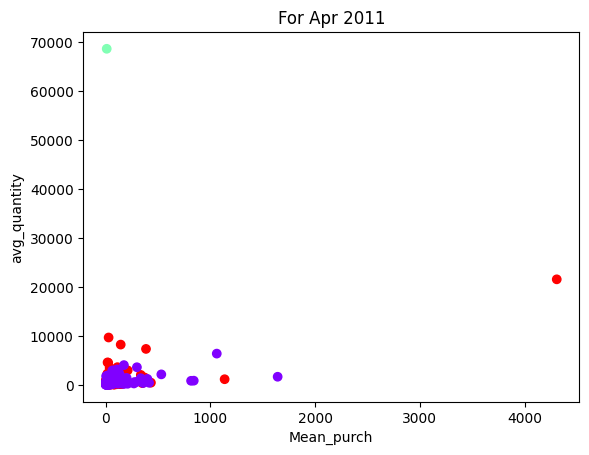

In [ ]:
plt.scatter(df_apr2011['Mean_purch'], df_apr2011['Sum_purch'], c=df_apr2011['cluster_labels'], cmap='rainbow')
plt.title("For Apr 2011")
plt.xlabel('Mean_purch')
plt.ylabel('avg_quantity')
plt.show()

In [ ]:
apr2011 = descrip_dict(og_apr2011,df_apr2011)
apr2011 = processlis(apr2011)

In [ ]:
apr2011

[     CustomerID                                        Description
 0             1  [AIRLINE BAG VINTAGE JET SET WHITE, AIRLINE BA...
 1             2  [DOUGHNUT LIP GLOSS , ICE CREAM PEN LIP GLOSS ...
 2             7  [JUMBO BAG ALPHABET, CHARLOTTE BAG APPLES DESI...
 3             9  [60 TEATIME FAIRY CAKE CASES, PACK OF 72 RETRO...
 4            15  [UNION JACK FLAG LUGGAGE TAG, RED RETROSPOT MI...
 ..          ...                                                ...
 436        2212  [WORLD WAR 2 GLIDERS ASSTD DESIGNS, CHILDRENS ...
 437        2219  [LUNCH BAG SUKI DESIGN , PLASTERS IN TIN VINTA...
 438        2254  [GARLAND WOODEN HAPPY EASTER, MOROCCAN TEA GLA...
 439        2503  [WHITE HANGING HEART T-LIGHT HOLDER, TEA TIME ...
 440        2922  [RED  HARMONICA IN BOX , 4 TRADITIONAL SPINNIN...
 
 [441 rows x 2 columns],
      CustomerID                                        Description
 0          2211  [SET OF 36 DOILIES SPACEBOY DESIGN , SET OF 72...
 1          2249  [RE

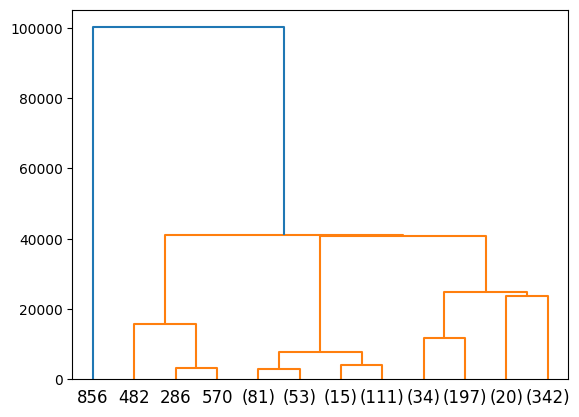

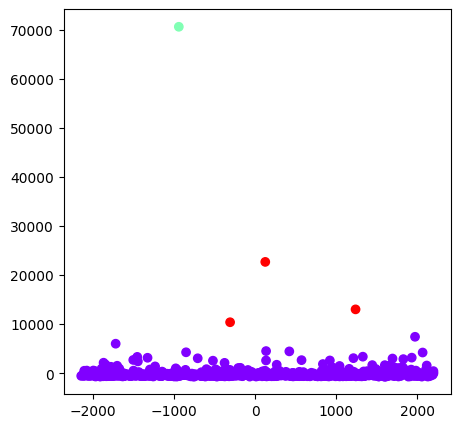

(853, 4)
(1, 4)
(3, 4)


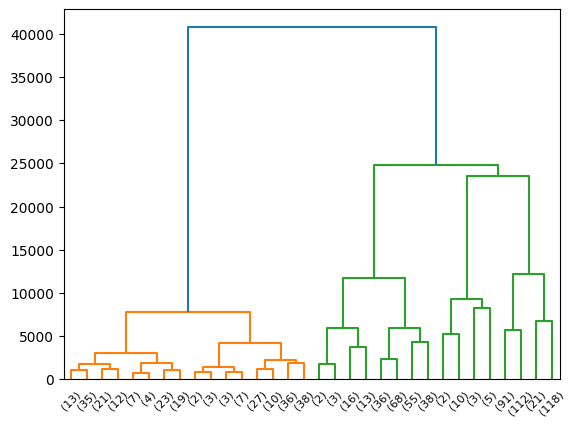

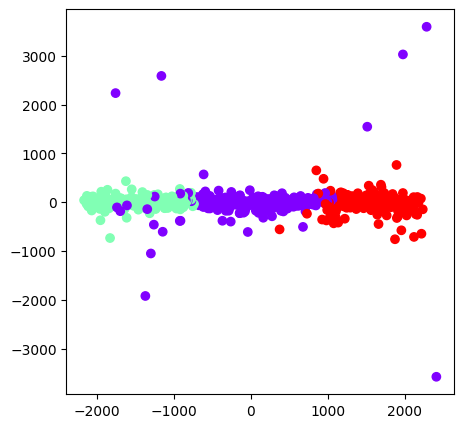

(362, 5)
(260, 5)
(231, 5)


[     CustomerID                                        Description
 0             1  [AIRLINE BAG VINTAGE JET SET WHITE, AIRLINE BA...
 1             2  [DOUGHNUT LIP GLOSS , ICE CREAM PEN LIP GLOSS ...
 2             7  [JUMBO BAG ALPHABET, CHARLOTTE BAG APPLES DESI...
 3             9  [60 TEATIME FAIRY CAKE CASES, PACK OF 72 RETRO...
 4            15  [UNION JACK FLAG LUGGAGE TAG, RED RETROSPOT MI...
 ..          ...                                                ...
 226        1360  [LARGE CIRCULAR MIRROR MOBILE, METAL TUBE CHIM...
 227        1408  [CERAMIC CAKE BOWL + HANGING CAKES, MINI CAKE ...
 228        1425  [PACK OF 12 COLOURED PENCILS, PACK OF 12 TRADI...
 229        1684  [PARTY BUNTING, REGENCY CAKESTAND 3 TIER, NATU...
 230        1964  [NEW BAROQUE B'FLY NECKLACE PINK, PINK HEART O...
 
 [231 rows x 2 columns],
      CustomerID                                        Description
 0           324  [Manual, Manual, Manual, Manual, Manual, DOORM...
 1           331  [WO

In [ ]:
pca = PCA(n_components = 3)
pca.fit(X = dvt_apr2011)
new_dvt = pca.transform(dvt_apr2011)

new_dvt = pd.DataFrame(data = new_dvt,columns = ['X0','X1','X2'])
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage='ward').fit(new_dvt)

plot_dendrogram(model, truncate_mode="level", p=4)

dict_apr2011 =  Agglocls(new_dvt,3)

final_dvt_apr2011 = dict_apr2011[0]
pca_apr2011 = PCA(n_components = 3)
pca_apr2011.fit(X = final_dvt_apr2011)
final_dvt_apr2011 = pca_apr2011.transform(final_dvt_apr2011)
final_dvt_apr2011 = pd.DataFrame(data = final_dvt_apr2011,columns = ['X0','X1','X2'])
AggloDendo(final_dvt_apr2011)

dict_apr2011_final =  AggloPca(final_dvt_apr2011,3,dvt_apr2011,'X0','X2')

apr2011_agg = descrip_dict(og_apr2011,final_dvt_apr2011)
apr2011_agg = processlis(apr2011_agg)
apr2011_agg




In [ ]:
apr2011 = processlis(apr2011)
apr2011_agg = processlis(apr2011_agg)
len(apr2011),len(apr2011_agg)

(2, 3)

In [ ]:
Cluster_dict['apr2011'] = (len(apr2011),len(apr2011_agg))
dicti_2011apr = {}
klis = []
for i in range(Cluster_dict['apr2011'][0]):
  temp = apriori_rules(apr2011[i],0.075)
  klis.append(temp)
alis = []
for i in range(Cluster_dict['apr2011'][1]):
  temp = apriori_rules(apr2011_agg[i],0.075)
  alis.append(temp)
#apriori_rules(1_agg[0],0.075)
dicti_2011apr['K-means'] = klis
dicti_2011apr['Agglo'] = alis

Rules_dict['apr2011'] = dicti_2011apr

## For May 2011

In [ ]:
og_may2011 = df_list_month_intervals[5]
og_may2011

InvoiceNo StockCode                          Description  Quantity  \
171999    551515     21731        RED TOADSTOOL LED NIGHT LIGHT        12   
172000    551515     20749           ASSORTED COLOUR MINI CASES        12   
172001    551515     22729          ALARM CLOCK BAKELIKE ORANGE         8   
172002    551515     22998         TRAVEL CARD WALLET KEEP CALM        24   
172003    551515     22665    RECIPE BOX BLUE SKETCHBOOK DESIGN        24   
...          ...       ...                                  ...       ...   
209024    555150     22895  SET OF 2 TEA TOWELS APPLE AND PEARS         3   
209025    555150     22983                  CARD BILLBOARD FONT         3   
209026    555150     23169             CLASSIC GLASS COOKIE JAR         3   
209027    555150     23298                       SPOTTY BUNTING         5   
209028    555150     23118         PARISIENNE JEWELLERY DRAWER          2   

        UnitPrice  CustomerID         Country time_intervals  Total Price  \
171999       1.65        2396  United Kingdom    08:00-11:59        19.80   
172000       6.35        2396  United Kingdom    08:00-11:59        76.20   
172001       3.75        2396  United Kingdom    08:00-11:59        30.00   
172002       0.42        2396  United Kingdom    08:00-11:59        10.08   
172003       2.55        2396  United Kingdom    08:00-11:59        61.20   
...           ...         ...             ...            ...          ...   
209024       3.25        4339  United Kingdom    12:00-15:59         9.75   
209025       0.42        4339  United Kingdom    12:00-15:59         1.26   
209026       4.15        4339  United Kingdom    12:00-15:59        12.45   
209027       4.95        4339  United Kingdom    12:00-15:59        24.75   
209028       7.50        4339  United Kingdom    12:00-15:59        15.00   

        Money_bins  
171999           0  
172000           0  
172001           0  
172002           0  
172003           0  
...            ...  
209024           0  
209025           0  
209026           0  
209027           0  
209028           0  

[36292 rows x 10 columns]

In [ ]:
dvt_may2011= person_df(og_may2011) #Our function gives such a dataframe
#By which we can form clusters using KMeans
dvt_may2011


No. of visits  Mean_purch  Sum_purch  Item_count  Total_quantity  \
0                 1   22.250000      89.00           4              20   
1                 1   35.338462     459.40          13             240   
2                 1   24.079556    1083.58          45             434   
3                 1   27.142105     515.70          19             368   
4                 1   18.146667     381.08          21             182   
...             ...         ...        ...         ...             ...   
1052              1   21.023529     357.40          17             192   
1053              1   21.398500     427.97          20             144   
1054              1    2.260682      99.47          32              62   
1055              1   26.388966     765.28          27             488   
1056            176   11.535942   91941.46        1643           25740   

      Avg_quant  CustomerID  
0      5.000000           6  
1     18.461538           8  
2      9.644444          13  
3     19.368421          22  
4      8.666667          38  
...         ...         ...  
1052  11.294118        4318  
1053   7.200000        4320  
1054   1.409091        4337  
1055  16.827586        4338  
1056   3.229611        4339  

[1057 rows x 7 columns]

In [ ]:
df_may2011 = df_cluster_labels(dvt_may2011,3)
df_may2011

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


No. of visits  Mean_purch  Sum_purch  Item_count  Total_quantity  \
0                 1   22.250000      89.00           4              20   
1                 1   35.338462     459.40          13             240   
2                 1   24.079556    1083.58          45             434   
3                 1   27.142105     515.70          19             368   
4                 1   18.146667     381.08          21             182   
...             ...         ...        ...         ...             ...   
1052              1   21.023529     357.40          17             192   
1053              1   21.398500     427.97          20             144   
1054              1    2.260682      99.47          32              62   
1055              1   26.388966     765.28          27             488   
1056            176   11.535942   91941.46        1643           25740   

      Avg_quant  CustomerID  cluster_labels  
0      5.000000           6               0  
1     18.461538           8               0  
2      9.644444          13               0  
3     19.368421          22               0  
4      8.666667          38               0  
...         ...         ...             ...  
1052  11.294118        4318               0  
1053   7.200000        4320               0  
1054   1.409091        4337               0  
1055  16.827586        4338               0  
1056   3.229611        4339               2  

[1057 rows x 8 columns]

In [ ]:
silhte_score_may2011 = silhouette_score(dvt_may2011, df_may2011['cluster_labels'])
print("The Silhouette Score is :- "+str(silhte_score_may2011))

The Silhouette Score is :- 0.8878455774488703


In [ ]:
df_may2011['cluster_labels'].value_counts()

0    1049
1       7
2       1
Name: cluster_labels, dtype: int64

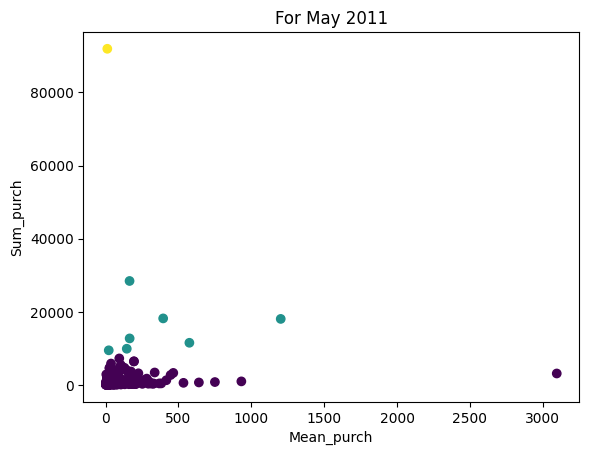

In [ ]:
plt.scatter(df_may2011['Mean_purch'], df_may2011['Sum_purch'], c=df_may2011['cluster_labels'], cmap='viridis')
plt.title("For May 2011")
plt.xlabel('Mean_purch')
plt.ylabel('Sum_purch')
plt.show()

In [ ]:
#Below is for outliers:-
df_may2011 = df_may2011[df_may2011['cluster_labels']!=1]
df_may2011 = df_may2011[df_may2011['cluster_labels']!=2]
df_may2011

No. of visits  Mean_purch  Sum_purch  Item_count  Total_quantity  \
0                 1   22.250000      89.00           4              20   
1                 1   35.338462     459.40          13             240   
2                 1   24.079556    1083.58          45             434   
3                 1   27.142105     515.70          19             368   
4                 1   18.146667     381.08          21             182   
...             ...         ...        ...         ...             ...   
1051              2   13.550811     501.38          37             406   
1052              1   21.023529     357.40          17             192   
1053              1   21.398500     427.97          20             144   
1054              1    2.260682      99.47          32              62   
1055              1   26.388966     765.28          27             488   

      Avg_quant  CustomerID  cluster_labels  
0      5.000000           6               0  
1     18.461538           8               0  
2      9.644444          13               0  
3     19.368421          22               0  
4      8.666667          38               0  
...         ...         ...             ...  
1051  10.972973        4310               0  
1052  11.294118        4318               0  
1053   7.200000        4320               0  
1054   1.409091        4337               0  
1055  16.827586        4338               0  

[1049 rows x 8 columns]

In [ ]:
df_may2011['cluster_labels'].value_counts()

0    1049
Name: cluster_labels, dtype: int64

In [ ]:
df_may2011_person = df_may2011.copy(deep=True)
df_may2011_person.drop(['cluster_labels'],axis=1,inplace=True)
df_may2011_person

No. of visits  Mean_purch  Sum_purch  Item_count  Total_quantity  \
0                 1   22.250000      89.00           4              20   
1                 1   35.338462     459.40          13             240   
2                 1   24.079556    1083.58          45             434   
3                 1   27.142105     515.70          19             368   
4                 1   18.146667     381.08          21             182   
...             ...         ...        ...         ...             ...   
1051              2   13.550811     501.38          37             406   
1052              1   21.023529     357.40          17             192   
1053              1   21.398500     427.97          20             144   
1054              1    2.260682      99.47          32              62   
1055              1   26.388966     765.28          27             488   

      Avg_quant  CustomerID  
0      5.000000           6  
1     18.461538           8  
2      9.644444          13  
3     19.368421          22  
4      8.666667          38  
...         ...         ...  
1051  10.972973        4310  
1052  11.294118        4318  
1053   7.200000        4320  
1054   1.409091        4337  
1055  16.827586        4338  

[1049 rows x 7 columns]

In [ ]:
df_may2011_new = df_cluster_labels(df_may2011_person,3)
df_may2011_new

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


No. of visits  Mean_purch  Sum_purch  Item_count  Total_quantity  \
0                 1   22.250000      89.00           4              20   
1                 1   35.338462     459.40          13             240   
2                 1   24.079556    1083.58          45             434   
3                 1   27.142105     515.70          19             368   
4                 1   18.146667     381.08          21             182   
...             ...         ...        ...         ...             ...   
1051              2   13.550811     501.38          37             406   
1052              1   21.023529     357.40          17             192   
1053              1   21.398500     427.97          20             144   
1054              1    2.260682      99.47          32              62   
1055              1   26.388966     765.28          27             488   

      Avg_quant  CustomerID  cluster_labels  
0      5.000000           6               1  
1     18.461538           8               1  
2      9.644444          13               1  
3     19.368421          22               1  
4      8.666667          38               1  
...         ...         ...             ...  
1051  10.972973        4310               2  
1052  11.294118        4318               2  
1053   7.200000        4320               2  
1054   1.409091        4337               2  
1055  16.827586        4338               2  

[1049 rows x 8 columns]

In [ ]:
silhte_score_may2011_new = silhouette_score(df_may2011_person, df_may2011_new['cluster_labels'])
print("The Silhouette Score is :- "+str(silhte_score_may2011_new))
#Indicates that silhouette score is realistic for dataset without outliers

The Silhouette Score is :- 0.5419356979120104


In [ ]:
df_may2011_new['cluster_labels'].value_counts()
#These are comparatively good clusters

1    525
2    495
0     29
Name: cluster_labels, dtype: int64

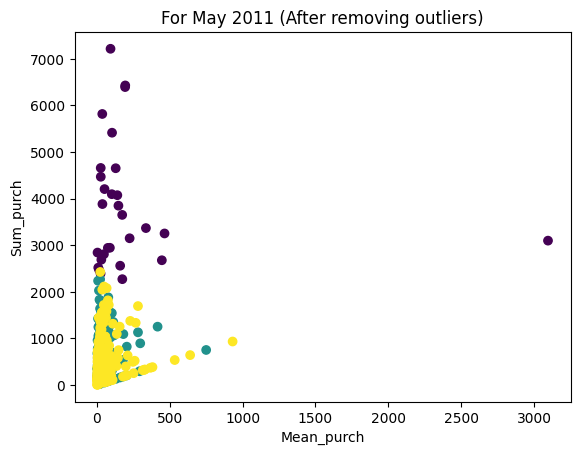

In [ ]:
plt.scatter(df_may2011_new['Mean_purch'], df_may2011_new['Sum_purch'], c=df_may2011_new['cluster_labels'], cmap='viridis')
plt.title("For May 2011 (After removing outliers)")
plt.xlabel('Mean_purch')
plt.ylabel('Sum_purch')
plt.show()

In [ ]:
may2011 = descrip_dict(og_dec2010,df_dec2010_new)
may2011 = processlis(may2011)

In [ ]:
may2011

[     CustomerID                                        Description
 0             1  [BLACK CANDELABRA T-LIGHT HOLDER, AIRLINE BAG ...
 1             2  [72 SWEETHEART FAIRY CAKE CASES, 60 CAKE CASES...
 2            20  [WHITE HANGING HEART T-LIGHT HOLDER, SPACE CAD...
 3            26  [HOT WATER BOTTLE BABUSHKA LARGE, CHOCOLATE HO...
 4            31  [SET/10 RED POLKADOT PARTY CANDLES, SET/10 PIN...
 ..          ...                                                ...
 398        2226  [JAM MAKING SET WITH JARS, JAM MAKING SET PRIN...
 399        2227                       [HAND OPEN SHAPE DECO.WHITE]
 400        2230  [SKULL DESIGN TV DINNER TRAY, TV DINNER TRAY D...
 401        2235  [DANISH ROSE ROUND SEWING BOX, 3 STRIPEY MICE ...
 402        2237  [DOLLY GIRL LUNCH BOX, SPACEBOY LUNCH BOX , LU...
 
 [403 rows x 2 columns],
      CustomerID                                        Description
 0          2261  [CHOCOLATE HOT WATER BOTTLE, PAPER CHAIN KIT V...
 1          2283  [RE

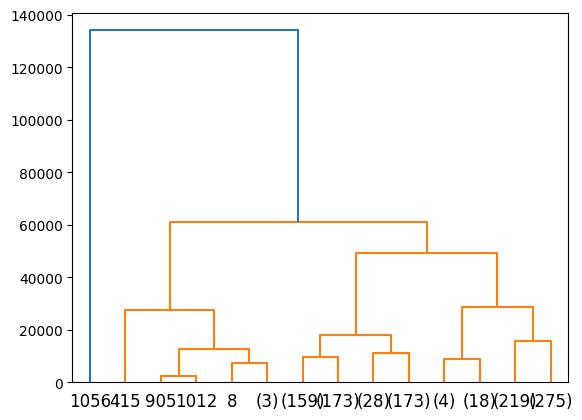

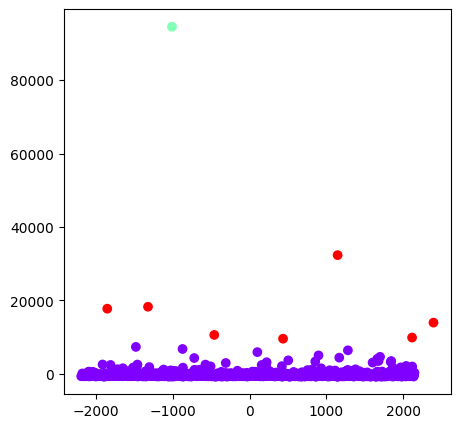

(1049, 4)
(1, 4)
(7, 4)


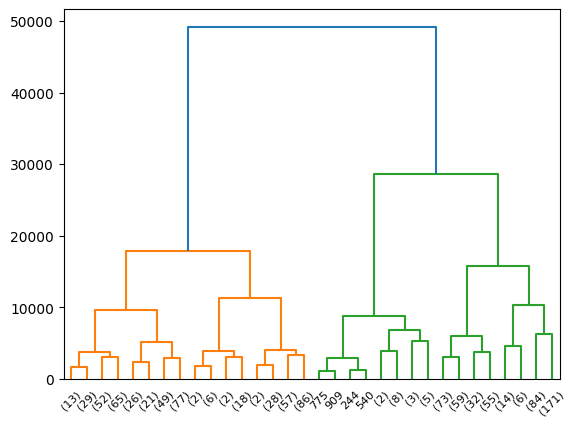

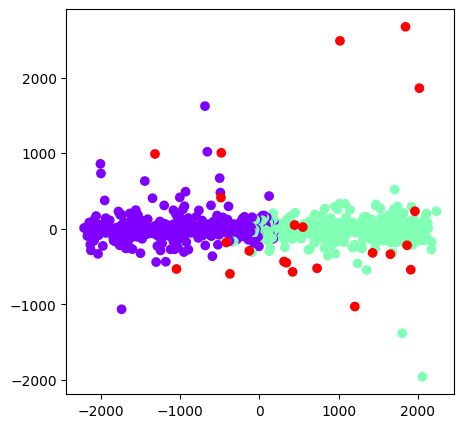

(533, 5)
(494, 5)
(22, 5)


[     CustomerID                                        Description
 0             6  [CERAMIC CAKE STAND + HANGING CAKES, MINI CAKE...
 1             8  [GROW A FLYTRAP OR SUNFLOWER IN TIN, ICE CREAM...
 2            13  [SET/6 RED SPOTTY PAPER PLATES, SET/6 RED SPOT...
 3            22  [DOLLY GIRL LUNCH BOX, WRAP CAROUSEL, WRAP PIN...
 4            38  [SPACEBOY LUNCH BOX , PLASTERS IN TIN SPACEBOY...
 ..          ...                                                ...
 489        2178  [CHILDRENS CUTLERY POLKADOT PINK, CHILDRENS CU...
 490        2211  [SPOTTY BUNTING, TEA TIME PARTY BUNTING, PARTY...
 491        2223  [BIRD DECORATION GREEN POLKADOT, SINGLE ANTIQU...
 492        2307  [ SET 2 TEA TOWELS I LOVE LONDON , TREASURE IS...
 493        2512                      [WOODEN ROUNDERS GARDEN SET ]
 
 [494 rows x 2 columns],
      CustomerID                                        Description
 0          1898  [BLUE HAPPY BIRTHDAY BUNTING, PINK HAPPY BIRTH...
 1          1931  [SI

In [ ]:
pca = PCA(n_components = 3)
pca.fit(X = dvt_may2011)
new_dvt = pca.transform(dvt_may2011)

new_dvt = pd.DataFrame(data = new_dvt,columns = ['X0','X1','X2'])
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage='ward').fit(new_dvt)

plot_dendrogram(model, truncate_mode="level", p=4)

dict_may2011 =  Agglocls(new_dvt,3)

final_dvt_may2011 = dict_may2011[0]
pca_may2011 = PCA(n_components = 3)
pca_may2011.fit(X = final_dvt_may2011)
final_dvt_may2011 = pca_may2011.transform(final_dvt_may2011)
final_dvt_may2011 = pd.DataFrame(data = final_dvt_may2011,columns = ['X0','X1','X2'])
AggloDendo(final_dvt_may2011)

dict_may2011_final =  AggloPca(final_dvt_may2011,3,dvt_may2011,'X0','X2')

may2011_agg = descrip_dict(og_may2011,final_dvt_may2011)
may2011_agg = processlis(may2011_agg)
may2011_agg


#apr2011 = processlis(apr2011)
#apr2011_agg = processlis(apr2011_agg)


In [ ]:
Cluster_dict['may2011'] = (len(may2011),len(may2011_agg))
dicti_2011may = {}
klis = []
for i in range(Cluster_dict['may2011'][0]):
  temp = apriori_rules(may2011[i],0.075)
  klis.append(temp)
alis = []
for i in range(Cluster_dict['may2011'][1]):
  temp = apriori_rules(may2011_agg[i],0.075)
  alis.append(temp)
#apriori_rules(1_agg[0],0.075)
dicti_2011may['K-means'] = klis
dicti_2011may['Agglo'] = alis

Rules_dict['may2011'] = dicti_2011may

## For June 2011

In [ ]:
og_jun2011 = df_list_month_intervals[6]
og_jun2011

InvoiceNo StockCode                   Description  Quantity  UnitPrice  \
209029    555156     23299  FOOD COVER WITH BEADS SET 2          6       3.75   
209030    555156     22847   BREAD BIN DINER STYLE IVORY         1      16.95   
209031    555157     23075     PARLOUR CERAMIC WALL HOOK        16       4.15   
209032    555157    47590B   PINK HAPPY BIRTHDAY BUNTING         6       5.45   
209033    555157     22423      REGENCY CAKESTAND 3 TIER         4      12.75   
...          ...       ...                           ...       ...        ...   
245898    558637     22032  BOTANICAL LILY GREETING CARD        12       0.42   
245899    558637     22028  PENNY FARTHING BIRTHDAY CARD        12       0.42   
245900    558637     22033  BOTANICAL ROSE GREETING CARD        12       0.42   
245901    558637     22029        SPACEBOY BIRTHDAY CARD        12       0.42   
245902    558637     22024    RAINY LADIES BIRTHDAY CARD        12       0.42   

        CustomerID         Country time_intervals  Total Price  Money_bins  
209029        2422  United Kingdom    04:00-07:59        22.50           0  
209030        2422  United Kingdom    04:00-07:59        16.95           0  
209031        2422  United Kingdom    04:00-07:59        66.40           0  
209032        2422  United Kingdom    04:00-07:59        32.70           0  
209033        2422  United Kingdom    04:00-07:59        51.00           0  
...            ...             ...            ...          ...         ...  
245898        4051  United Kingdom    16:00-19:59         5.04           0  
245899        4051  United Kingdom    16:00-19:59         5.04           0  
245900        4051  United Kingdom    16:00-19:59         5.04           0  
245901        4051  United Kingdom    16:00-19:59         5.04           0  
245902        4051  United Kingdom    16:00-19:59         5.04           0  

[36056 rows x 10 columns]

In [ ]:
dvt_jun2011= person_df(og_jun2011) #Our function gives such a dataframe
#By which we can form clusters using KMeans
dvt_jun2011

No. of visits  Mean_purch  Sum_purch  Item_count  Total_quantity  \
0                1   21.251111     382.52          18             196   
1                1   23.602553    1109.32          47             356   
2                1   22.992000     459.84          20             211   
3                1   16.876389     607.55          36             293   
4                1   19.890000      99.45           5              20   
..             ...         ...        ...         ...             ...   
987              1   21.440000     214.40          10              92   
988              1   18.570870     427.13          23             177   
989              1   11.545714      80.82           7              54   
990              2    2.770541     307.53          77             209   
991            183   11.332004  100526.21        1904           30638   

     Avg_quant  CustomerID  
0    10.888889           1  
1     7.574468          12  
2    10.550000          28  
3     8.138889          29  
4     4.000000          31  
..         ...         ...  
987   9.200000        4318  
988   7.695652        4320  
989   7.714286        4335  
990   1.882883        4337  
991   3.453726        4339  

[992 rows x 7 columns]

In [ ]:
df_jun2011 = df_cluster_labels(dvt_jun2011,3)
df_jun2011

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


No. of visits  Mean_purch  Sum_purch  Item_count  Total_quantity  \
0                1   21.251111     382.52          18             196   
1                1   23.602553    1109.32          47             356   
2                1   22.992000     459.84          20             211   
3                1   16.876389     607.55          36             293   
4                1   19.890000      99.45           5              20   
..             ...         ...        ...         ...             ...   
987              1   21.440000     214.40          10              92   
988              1   18.570870     427.13          23             177   
989              1   11.545714      80.82           7              54   
990              2    2.770541     307.53          77             209   
991            183   11.332004  100526.21        1904           30638   

     Avg_quant  CustomerID  cluster_labels  
0    10.888889           1               0  
1     7.574468          12               0  
2    10.550000          28               0  
3     8.138889          29               0  
4     4.000000          31               0  
..         ...         ...             ...  
987   9.200000        4318               0  
988   7.695652        4320               0  
989   7.714286        4335               0  
990   1.882883        4337               0  
991   3.453726        4339               1  

[992 rows x 8 columns]

In [ ]:
silhte_score_jun2011 = silhouette_score(dvt_jun2011, df_jun2011['cluster_labels'])
print("The Silhouette Score is :- "+str(silhte_score_jun2011))

The Silhouette Score is :- 0.942123363502381


In [ ]:
df_jun2011['cluster_labels'].value_counts()

0    986
2      5
1      1
Name: cluster_labels, dtype: int64

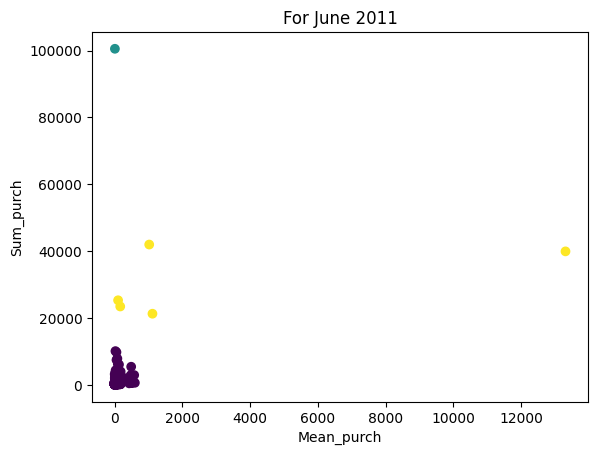

In [ ]:
plt.scatter(df_jun2011['Mean_purch'], df_jun2011['Sum_purch'], c=df_jun2011['cluster_labels'], cmap='viridis')
plt.title("For June 2011")
plt.xlabel('Mean_purch')
plt.ylabel('Sum_purch')
plt.show()

In [ ]:
#Below is for outliers:-

df_jun2011 = df_jun2011[df_jun2011['cluster_labels']!=1]
df_jun2011 = df_jun2011[df_jun2011['cluster_labels']!=2]
df_jun2011


No. of visits  Mean_purch  Sum_purch  Item_count  Total_quantity  \
0                1   21.251111     382.52          18             196   
1                1   23.602553    1109.32          47             356   
2                1   22.992000     459.84          20             211   
3                1   16.876389     607.55          36             293   
4                1   19.890000      99.45           5              20   
..             ...         ...        ...         ...             ...   
986              1   23.300000      69.90           3              18   
987              1   21.440000     214.40          10              92   
988              1   18.570870     427.13          23             177   
989              1   11.545714      80.82           7              54   
990              2    2.770541     307.53          77             209   

     Avg_quant  CustomerID  cluster_labels  
0    10.888889           1               0  
1     7.574468          12               0  
2    10.550000          28               0  
3     8.138889          29               0  
4     4.000000          31               0  
..         ...         ...             ...  
986   6.000000        4316               0  
987   9.200000        4318               0  
988   7.695652        4320               0  
989   7.714286        4335               0  
990   1.882883        4337               0  

[986 rows x 8 columns]

In [ ]:
df_jun2011['cluster_labels'].value_counts()

0    986
Name: cluster_labels, dtype: int64

In [ ]:
#Now we again apply the clustering pipeline

df_jun2011_person = df_jun2011.copy(deep=True)
df_jun2011_person.drop(['cluster_labels'],axis=1,inplace=True)
df_jun2011_person

No. of visits  Mean_purch  Sum_purch  Item_count  Total_quantity  \
0                1   21.251111     382.52          18             196   
1                1   23.602553    1109.32          47             356   
2                1   22.992000     459.84          20             211   
3                1   16.876389     607.55          36             293   
4                1   19.890000      99.45           5              20   
..             ...         ...        ...         ...             ...   
986              1   23.300000      69.90           3              18   
987              1   21.440000     214.40          10              92   
988              1   18.570870     427.13          23             177   
989              1   11.545714      80.82           7              54   
990              2    2.770541     307.53          77             209   

     Avg_quant  CustomerID  
0    10.888889           1  
1     7.574468          12  
2    10.550000          28  
3     8.138889          29  
4     4.000000          31  
..         ...         ...  
986   6.000000        4316  
987   9.200000        4318  
988   7.695652        4320  
989   7.714286        4335  
990   1.882883        4337  

[986 rows x 7 columns]

In [ ]:
df_jun2011_new = df_cluster_labels(df_jun2011_person,3)
df_jun2011_new

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


No. of visits  Mean_purch  Sum_purch  Item_count  Total_quantity  \
0                1   21.251111     382.52          18             196   
1                1   23.602553    1109.32          47             356   
2                1   22.992000     459.84          20             211   
3                1   16.876389     607.55          36             293   
4                1   19.890000      99.45           5              20   
..             ...         ...        ...         ...             ...   
986              1   23.300000      69.90           3              18   
987              1   21.440000     214.40          10              92   
988              1   18.570870     427.13          23             177   
989              1   11.545714      80.82           7              54   
990              2    2.770541     307.53          77             209   

     Avg_quant  CustomerID  cluster_labels  
0    10.888889           1               0  
1     7.574468          12               0  
2    10.550000          28               0  
3     8.138889          29               0  
4     4.000000          31               0  
..         ...         ...             ...  
986   6.000000        4316               1  
987   9.200000        4318               1  
988   7.695652        4320               1  
989   7.714286        4335               1  
990   1.882883        4337               1  

[986 rows x 8 columns]

In [ ]:
silhte_score_jun2011_new = silhouette_score(df_jun2011_person, df_jun2011_new['cluster_labels'])
print("The Silhouette Score is :- "+str(silhte_score_jun2011_new))
#Indicates that silhouette score is realistic for dataset without outliers

The Silhouette Score is :- 0.5340333618803993


In [ ]:
df_jun2011_new['cluster_labels'].value_counts()
#These are comparatively good clusters

0    497
1    475
2     14
Name: cluster_labels, dtype: int64

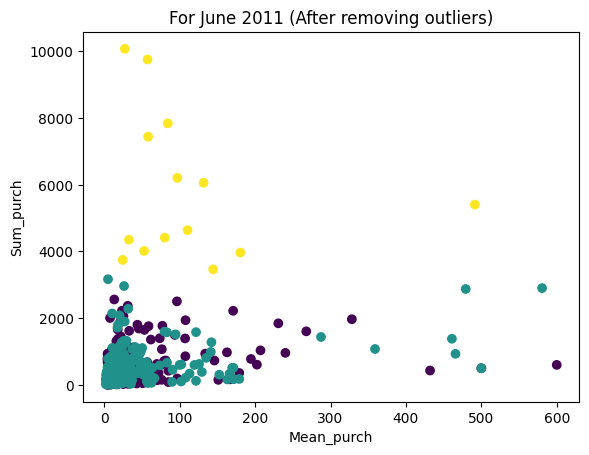

In [ ]:
plt.scatter(df_jun2011_new['Mean_purch'], df_jun2011_new['Sum_purch'], c=df_jun2011_new['cluster_labels'], cmap='viridis')
plt.title("For June 2011 (After removing outliers)")
plt.xlabel('Mean_purch')
plt.ylabel('Sum_purch')
plt.show()


In [ ]:
jun2011 = descrip_dict(og_jun2011,df_jun2011_new)
jun2011 = processlis(jun2011)

In [ ]:
jun2011

[     CustomerID                                        Description
 0             1  [RABBIT NIGHT LIGHT, REGENCY TEA STRAINER, REG...
 1            12  [JUMBO  BAG BAROQUE BLACK WHITE, SET OF 4 PANT...
 2            28  [RED RETROSPOT MINI CASES, RED RETROSPOT PURSE...
 3            29  [LUNCH BAG APPLE DESIGN, CHILDRENS CUTLERY SPA...
 4            31  [WHITE WOOD GARDEN PLANT LADDER, TRAY, BREAKFA...
 ..          ...                                                ...
 492        2166  [SET OF 3 REGENCY CAKE TINS, DOILEY STORAGE TI...
 493        2168  [SMALL POPCORN HOLDER, JUMBO BAG VINTAGE LEAF,...
 494        2169                                           [Manual]
 495        2171  [CHILDRENS CUTLERY RETROSPOT RED , RED RETROSP...
 496        2173  [REGENCY SUGAR BOWL GREEN, SET OF 3 REGENCY CA...
 
 [497 rows x 2 columns],
      CustomerID                                        Description
 0          2191  [STRAWBERRY CERAMIC TRINKET BOX, REGENCY CAKES...
 1          2195  [HA

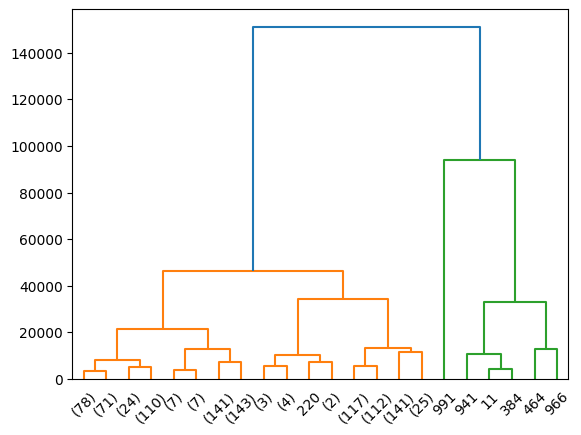

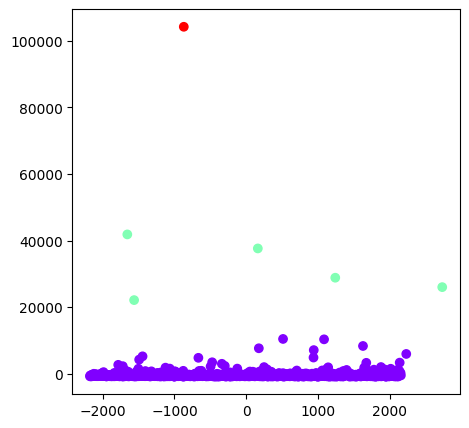

(986, 4)
(5, 4)
(1, 4)


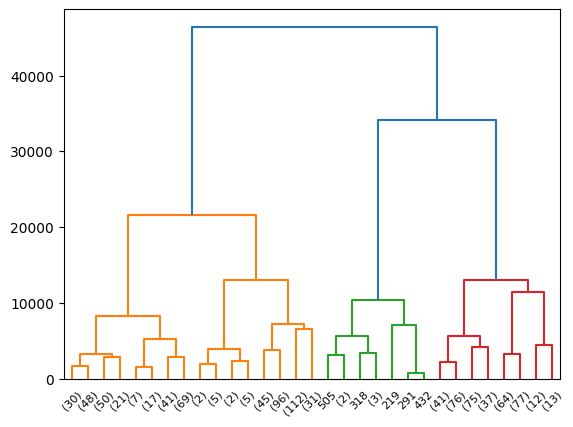

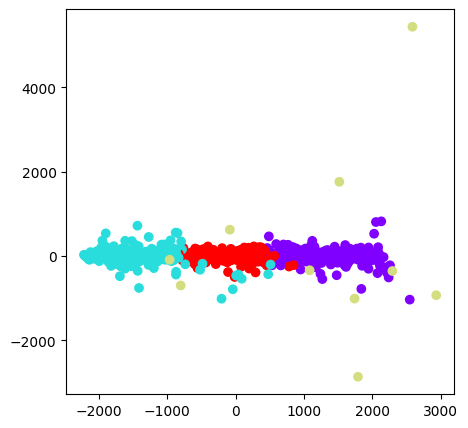

(395, 5)
(298, 5)
(10, 5)
(283, 5)


[     CustomerID                                        Description
 0             1  [RABBIT NIGHT LIGHT, REGENCY TEA STRAINER, REG...
 1            12  [JUMBO  BAG BAROQUE BLACK WHITE, SET OF 4 PANT...
 2            28  [RED RETROSPOT MINI CASES, RED RETROSPOT PURSE...
 3            29  [LUNCH BAG APPLE DESIGN, CHILDRENS CUTLERY SPA...
 4            31  [WHITE WOOD GARDEN PLANT LADDER, TRAY, BREAKFA...
 ..          ...                                                ...
 390        1753  [12 PENCILS TALL TUBE POSY, SET/6 COLLAGE PAPE...
 391        1754  [VANILLA INCENSE IN TIN, DOORMAT HEARTS, PARTY...
 392        1755  [GARDENERS KNEELING PAD CUP OF TEA , MINT KITC...
 393        1760  [CLASSIC FRENCH STYLE BASKET NATURAL, SPOTTY B...
 394        1768  [PICTURE FRAME WOOD TRIPLE PORTRAIT, ASSORTED ...
 
 [395 rows x 2 columns],
      CustomerID                                        Description
 0          1472                            [LANTERN CREAM GAZEBO ]
 1          1482  [JU

In [ ]:
pca = PCA(n_components = 3)
pca.fit(X = dvt_jun2011)
new_dvt = pca.transform(dvt_jun2011)

new_dvt = pd.DataFrame(data = new_dvt,columns = ['X0','X1','X2'])
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage='ward').fit(new_dvt)

plot_dendrogram(model, truncate_mode="level", p=4)

dict_jun2011 =  Agglocls(new_dvt,3)

final_dvt_jun2011 = dict_jun2011[0]
pca_jun2011 = PCA(n_components = 3)
pca_jun2011.fit(X = final_dvt_jun2011)
final_dvt_jun2011 = pca_jun2011.transform(final_dvt_jun2011)
final_dvt_jun2011 = pd.DataFrame(data = final_dvt_jun2011,columns = ['X0','X1','X2'])
AggloDendo(final_dvt_jun2011)

dict_jun2011_final =  AggloPca(final_dvt_jun2011,4,dvt_jun2011,'X0','X2')

jun2011_agg = descrip_dict(og_jun2011,final_dvt_jun2011)
jun2011_agg = processlis(jun2011_agg)
jun2011_agg
#apr2011 = processlis(apr2011)
#apr2011_agg = processlis(apr2011_agg)



In [ ]:
new_dvt

X0           X1          X2  Clus
0      -457.008797  2157.422880  144.220137     0
1       284.180988  2153.402081  197.113408     0
2      -378.396487  2131.104301  151.277265     0
3      -212.937002  2133.549922  115.720346     0
4      -779.623146  2120.065513  222.793306     0
..             ...          ...         ...   ...
987    -592.780417 -2160.294449   34.595290     0
988    -364.394093 -2158.686531   14.980382     0
989    -731.654430 -2178.911841   28.159919     0
990    -468.300784 -2174.458108  -52.457587     0
991  104204.282474  -870.078201 -199.372855     2

[992 rows x 4 columns]

In [ ]:
Cluster_dict['jun2011'] = (len(jun2011),len(jun2011_agg))
dicti_2011jun = {}
klis = []
for i in range(Cluster_dict['jun2011'][0]):
  temp = apriori_rules(jun2011[i],0.075)
  klis.append(temp)
alis = []
for i in range(Cluster_dict['jun2011'][1]):
  temp = apriori_rules(jun2011_agg[i],0.075)
  alis.append(temp)
#apriori_rules(1_agg[0],0.075)
dicti_2011jun['K-means'] = klis
dicti_2011jun['Agglo'] = alis

Rules_dict['jun2011'] = dicti_2011jun

## For July 2011

In [ ]:
og_jul2011 = df_list_month_intervals[7]
og_jul2011


InvoiceNo StockCode                      Description  Quantity  \
245903    558638     84836      ZINC METAL HEART DECORATION        12   
245904    558638     71459   HANGING JAM JAR T-LIGHT HOLDER        24   
245905    558638     22784            LANTERN CREAM GAZEBO          3   
245906    558638     23145   ZINC T-LIGHT HOLDER STAR LARGE        12   
245907    558638     22674    FRENCH TOILET SIGN BLUE METAL        12   
...          ...       ...                              ...       ...   
285416    561903     21900                   KEY FOB , SHED        24   
285417    561903     48187              DOORMAT NEW ENGLAND         2   
285418    561903     85152  HAND OVER THE CHOCOLATE   SIGN         12   
285419    561903     82600            NO SINGING METAL SIGN        12   
285420    561903     21175      GIN + TONIC DIET METAL SIGN        12   

        UnitPrice  CustomerID         Country time_intervals  Total Price  \
245903       1.25        2909  United Kingdom    04:00-07:59        15.00   
245904       0.85        2909  United Kingdom    04:00-07:59        20.40   
245905       4.95        2909  United Kingdom    04:00-07:59        14.85   
245906       0.95        2909  United Kingdom    04:00-07:59        11.40   
245907       1.25        2909  United Kingdom    04:00-07:59        15.00   
...           ...         ...             ...            ...          ...   
285416       0.65        3525  United Kingdom    12:00-15:59        15.60   
285417       7.95        3525  United Kingdom    12:00-15:59        15.90   
285418       2.10        3525  United Kingdom    12:00-15:59        25.20   
285419       2.10        3525  United Kingdom    12:00-15:59        25.20   
285420       2.55        3525  United Kingdom    12:00-15:59        30.60   

        Money_bins  
245903           0  
245904           0  
245905           0  
245906           0  
245907           0  
...            ...  
285416           0  
285417           0  
285418           0  
285419           0  
285420           0  

[38716 rows x 10 columns]

In [ ]:
dvt_jul2011= person_df(og_jul2011) #Our function gives such a dataframe
#By which we can form clusters using KMeans
dvt_jul2011

No. of visits  Mean_purch  Sum_purch  Item_count  Total_quantity  \
0                1   40.405000     484.86          12             100   
1                1   15.987368     303.76          19             144   
2                1   25.774000     902.09          35             429   
3                1   17.354429    1214.81          70             704   
4                1   31.673889    1710.39          54             857   
..             ...         ...        ...         ...             ...   
945              1   16.846552     488.55          29             224   
946              1   25.500000      25.50           1               2   
947              1   20.369189     753.66          37             392   
948              2    2.512105     143.19          54             102   
949            209   10.020202  119130.18        1986           38107   

     Avg_quant  CustomerID  
0     8.333333          11  
1     7.578947          15  
2    12.257143          34  
3    10.057143          40  
4    15.870370          46  
..         ...         ...  
945   7.724138        4324  
946   2.000000        4325  
947  10.594595        4328  
948   1.789474        4337  
949   3.205232        4339  

[950 rows x 7 columns]

In [ ]:
df_jul2011 = df_cluster_labels(dvt_jul2011,3)
df_jul2011

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


No. of visits  Mean_purch  Sum_purch  Item_count  Total_quantity  \
0                1   40.405000     484.86          12             100   
1                1   15.987368     303.76          19             144   
2                1   25.774000     902.09          35             429   
3                1   17.354429    1214.81          70             704   
4                1   31.673889    1710.39          54             857   
..             ...         ...        ...         ...             ...   
945              1   16.846552     488.55          29             224   
946              1   25.500000      25.50           1               2   
947              1   20.369189     753.66          37             392   
948              2    2.512105     143.19          54             102   
949            209   10.020202  119130.18        1986           38107   

     Avg_quant  CustomerID  cluster_labels  
0     8.333333          11               0  
1     7.578947          15               0  
2    12.257143          34               0  
3    10.057143          40               0  
4    15.870370          46               0  
..         ...         ...             ...  
945   7.724138        4324               0  
946   2.000000        4325               0  
947  10.594595        4328               0  
948   1.789474        4337               0  
949   3.205232        4339               1  

[950 rows x 8 columns]

In [ ]:
silhte_score_jul2011 = silhouette_score(dvt_jul2011, df_jul2011['cluster_labels'])
print("The Silhouette Score is :- "+str(silhte_score_jul2011))

The Silhouette Score is :- 0.8626966432111031


In [ ]:
df_jul2011['cluster_labels'].value_counts()

0    940
2      9
1      1
Name: cluster_labels, dtype: int64

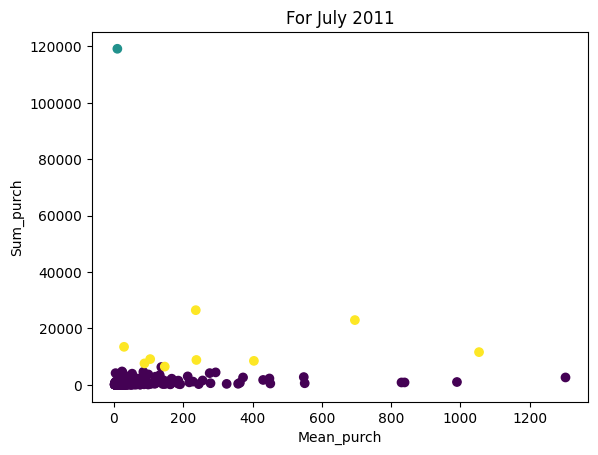

In [ ]:
plt.scatter(df_jul2011['Mean_purch'], df_jul2011['Sum_purch'], c=df_jul2011['cluster_labels'], cmap='viridis')
plt.title("For July 2011")
plt.xlabel('Mean_purch')
plt.ylabel('Sum_purch')
plt.show()

In [ ]:
#Below is for outliers:-

df_jul2011 = df_jul2011[df_jul2011['cluster_labels']!=1]
df_jul2011 = df_jul2011[df_jul2011['cluster_labels']!=2]

print(df_jul2011['cluster_labels'].value_counts())

df_jul2011

No. of visits  Mean_purch  Sum_purch  Item_count  Total_quantity  \
0                1   40.405000     484.86          12             100   
1                1   15.987368     303.76          19             144   
2                1   25.774000     902.09          35             429   
3                1   17.354429    1214.81          70             704   
4                1   31.673889    1710.39          54             857   
..             ...         ...        ...         ...             ...   
944              1   16.793333     503.80          30             720   
945              1   16.846552     488.55          29             224   
946              1   25.500000      25.50           1               2   
947              1   20.369189     753.66          37             392   
948              2    2.512105     143.19          54             102   

     Avg_quant  CustomerID  cluster_labels  
0     8.333333          11               0  
1     7.578947          15               0  
2    12.257143          34               0  
3    10.057143          40               0  
4    15.870370          46               0  
..         ...         ...             ...  
944  24.000000        4323               0  
945   7.724138        4324               0  
946   2.000000        4325               0  
947  10.594595        4328               0  
948   1.789474        4337               0  

[940 rows x 8 columns]

0    940
Name: cluster_labels, dtype: int64

In [ ]:
#Thus the outliers are removed.
#Now we again apply the clustering pipeline

df_jul2011_person = df_jul2011.copy(deep=True)
df_jul2011_person.drop(['cluster_labels'],axis=1,inplace=True)
df_jul2011_person.show()

df_jul2011_new = df_cluster_labels(df_jul2011_person,3)
df_jul2011_new

No. of visits  Mean_purch  Sum_purch  Item_count  Total_quantity  \
0                1   40.405000     484.86          12             100   
1                1   15.987368     303.76          19             144   
2                1   25.774000     902.09          35             429   
3                1   17.354429    1214.81          70             704   
4                1   31.673889    1710.39          54             857   
..             ...         ...        ...         ...             ...   
944              1   16.793333     503.80          30             720   
945              1   16.846552     488.55          29             224   
946              1   25.500000      25.50           1               2   
947              1   20.369189     753.66          37             392   
948              2    2.512105     143.19          54             102   

     Avg_quant  CustomerID  
0     8.333333          11  
1     7.578947          15  
2    12.257143          34  
3    10.057143          40  
4    15.870370          46  
..         ...         ...  
944  24.000000        4323  
945   7.724138        4324  
946   2.000000        4325  
947  10.594595        4328  
948   1.789474        4337  

[940 rows x 7 columns]

In [ ]:
silhte_score_jul2011_new = silhouette_score(df_jul2011_person, df_jul2011_new['cluster_labels'])
print("The Silhouette Score is :- "+str(silhte_score_jul2011_new))
#Indicates that silhouette score is realistic for dataset without outliers

df_jul2011_new['cluster_labels'].value_counts()
#These are comparatively good clusters

The Silhouette Score is :- 0.5464364639755702


1    474
0    433
2     33
Name: cluster_labels, dtype: int64

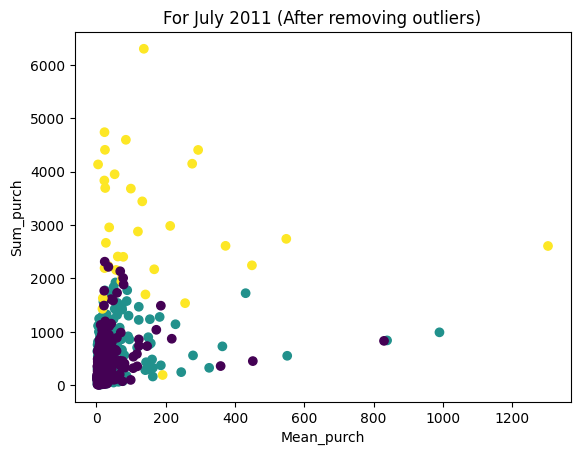

In [ ]:
plt.scatter(df_jul2011_new['Mean_purch'], df_jul2011_new['Sum_purch'], c=df_jul2011_new['cluster_labels'], cmap='viridis')
plt.title("For July 2011 (After removing outliers)")
plt.xlabel('Mean_purch')
plt.ylabel('Sum_purch')
plt.show()

In [ ]:
jul2011 = descrip_dict(og_jul2011,df_jul2011_new)
jul2011 = processlis(jul2011)
jul2011

[     CustomerID                                        Description
 0            11  [FAIRY CAKE DESIGN UMBRELLA, CERAMIC STRAWBERR...
 1            15  [SET OF 3 REGENCY CAKE TINS, REGENCY CAKESTAND...
 2            34  [PAPER CHAIN KIT VINTAGE CHRISTMAS, STAR DECOR...
 3            40  [BAKING SET SPACEBOY DESIGN, MINI JIGSAW SPACE...
 4            46  [TREASURE TIN GYMKHANA DESIGN, SET OF 4 KNICK ...
 ..          ...                                                ...
 469        2163  [SET OF 36 PAISLEY FLOWER DOILIES, BAG 250g SW...
 470        2168                [COLOUR GLASS. STAR T-LIGHT HOLDER]
 471        2171  [SPACEBOY LUNCH BOX , CHILDS BREAKFAST SET SPA...
 472        2174  [CERAMIC HEART FAIRY CAKE MONEY BANK, SWEETHEA...
 473        2191  [WRAP CHRISTMAS VILLAGE, EMPIRE GIFT WRAP, SWA...
 
 [474 rows x 2 columns],
      CustomerID                                        Description
 0          2195  [ZINC HERB GARDEN CONTAINER, SANDALWOOD FAN, P...
 1          2206  [LA

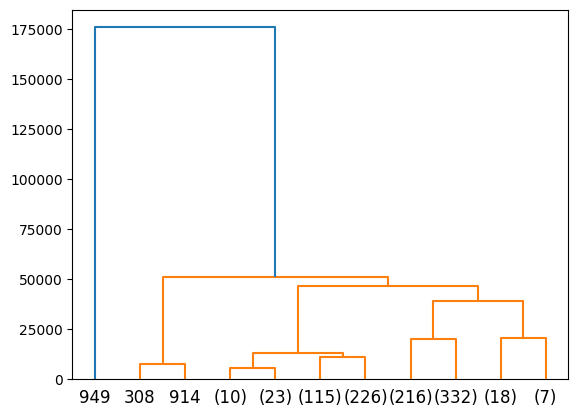

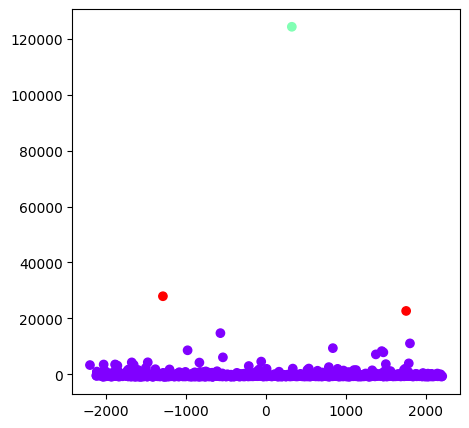

(947, 4)
(1, 4)
(2, 4)


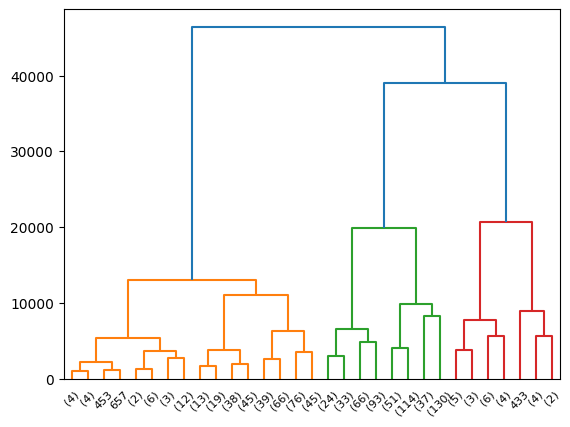

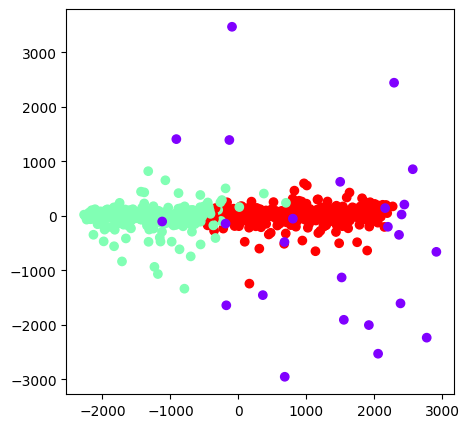

(25, 5)
(374, 5)
(548, 5)


[     CustomerID                                        Description
 0            11  [FAIRY CAKE DESIGN UMBRELLA, CERAMIC STRAWBERR...
 1            15  [SET OF 3 REGENCY CAKE TINS, REGENCY CAKESTAND...
 2            34  [PAPER CHAIN KIT VINTAGE CHRISTMAS, STAR DECOR...
 3            40  [BAKING SET SPACEBOY DESIGN, MINI JIGSAW SPACE...
 4            46  [TREASURE TIN GYMKHANA DESIGN, SET OF 4 KNICK ...
 ..          ...                                                ...
 543        2572  [LUNCH BAG RED RETROSPOT, SPACEBOY LUNCH BOX ,...
 544        2582  [EDWARDIAN PARASOL RED, EDWARDIAN PARASOL BLAC...
 545        2587  [REX CASH+CARRY JUMBO SHOPPER, BUNDLE OF 3 SCH...
 546        2607  [Manual, ASS COLOUR GLOWING TIARAS, BAKING SET...
 547        2618  [SPOTTY BUNTING, RETROSPOT TEA SET CERAMIC 11 ...
 
 [548 rows x 2 columns],
      CustomerID                                        Description
 0          1978  [DOUGHNUT LIP GLOSS , BUBBLEGUM RING ASSORTED,...
 1          2083  [LA

In [ ]:
pca = PCA(n_components = 3)
pca.fit(X = dvt_jul2011)
new_dvt = pca.transform(dvt_jul2011)

new_dvt = pd.DataFrame(data = new_dvt,columns = ['X0','X1','X2'])
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage='ward').fit(new_dvt)

plot_dendrogram(model, truncate_mode="level", p=4)

dict_jul2011 =  Agglocls(new_dvt,3)

final_dvt_jul2011 = dict_jul2011[0]
pca_jul2011 = PCA(n_components = 3)
pca_jul2011.fit(X = final_dvt_jul2011)
final_dvt_jul2011 = pca_jul2011.transform(final_dvt_jul2011)
final_dvt_jul2011 = pd.DataFrame(data = final_dvt_jul2011,columns = ['X0','X1','X2'])
AggloDendo(final_dvt_jul2011)

dict_jul2011_final =  AggloPca(final_dvt_jul2011,3,dvt_jul2011,'X0','X2')

jul2011_agg = descrip_dict(og_jul2011,final_dvt_jul2011)
jul2011_agg = processlis(jul2011_agg)
jul2011_agg

#apr2011 = processlis(apr2011)
#apr2011_agg = processlis(apr2011_agg)


In [ ]:
Cluster_dict['jul2011'] = (len(jul2011),len(jul2011_agg))
dicti_2011jul = {}
klis = []
for i in range(Cluster_dict['jul2011'][0]):
  temp = apriori_rules(jul2011[i],0.075)
  klis.append(temp)
alis = []
for i in range(Cluster_dict['jul2011'][1]):
  temp = apriori_rules(jul2011_agg[i],0.075)
  alis.append(temp)
#apriori_rules(1_agg[0],0.075)
dicti_2011jul['K-means'] = klis
dicti_2011jul['Agglo'] = alis

Rules_dict['jul2011'] = dicti_2011jul

## For August 2011

In [ ]:
og_aug2011 = df_list_month_intervals[8]
og_aug2011

InvoiceNo StockCode                          Description  Quantity  \
285421    561904     22075         6 RIBBONS ELEGANT CHRISTMAS         96   
285422    561904    85049E            SCANDINAVIAN REDS RIBBONS       156   
285423    561905     21385      IVORY HANGING DECORATION  HEART        24   
285424    561905    84970L     SINGLE HEART ZINC T-LIGHT HOLDER        12   
285425    561905    84970S    HANGING HEART ZINC T-LIGHT HOLDER        12   
...          ...       ...                                  ...       ...   
320690    565067     22637                PIGGY BANK RETROSPOT          2   
320691    565067     22646   CERAMIC STRAWBERRY CAKE MONEY BANK         2   
320692    565067     22741                       FUNKY DIVA PEN        48   
320694    565070    85032D                                  NaN       171   
320699    565076     23192  BUNDLE OF 3 ALPHABET EXERCISE BOOKS         1   

        UnitPrice  CustomerID         Country time_intervals  Total Price  \
285421       1.45        4089  United Kingdom    04:00-07:59       139.20   
285422       1.06        4089  United Kingdom    04:00-07:59       165.36   
285423       0.85        1900  United Kingdom    08:00-11:59        20.40   
285424       0.95        1900  United Kingdom    08:00-11:59        11.40   
285425       0.85        1900  United Kingdom    08:00-11:59        10.20   
...           ...         ...             ...            ...          ...   
320690       2.55        2584  United Kingdom    16:00-19:59         5.10   
320691       1.45        2584  United Kingdom    16:00-19:59         2.90   
320692       0.85        2584  United Kingdom    16:00-19:59        40.80   
320694       0.00        4339  United Kingdom    16:00-19:59         0.00   
320699       1.65        4339  United Kingdom    16:00-19:59         1.65   

        Money_bins  
285421           0  
285422           0  
285423           0  
285424           0  
285425           0  
...            ...  
320690           0  
320691           0  
320692           0  
320694           0  
320699           0  

[34564 rows x 10 columns]

In [ ]:
dvt_aug2011= person_df(og_aug2011) #Our function gives such a dataframe
#By which we can form clusters using KMeans
dvt_aug2011

No. of visits  Mean_purch  Sum_purch  Item_count  Total_quantity  \
0                1   26.586818     584.91          22             277   
1                1   17.823333     534.70          30             240   
2                1   15.641667     469.25          30             340   
3                1   36.128571     252.90           7             126   
4                1   18.350588     623.92          34             555   
..             ...         ...        ...         ...             ...   
931              1   16.187368     307.56          19             269   
932              1   16.953243     627.27          37             313   
933              1   16.920455     372.25          22             285   
934              1   14.315714     100.21           7              75   
935            128   12.136947   91670.36        1755           26078   

     Avg_quant  CustomerID  
0    12.590909           1  
1     8.000000          13  
2    11.333333          15  
3    18.000000          16  
4    16.323529          17  
..         ...         ...  
931  14.157895        4312  
932   8.459459        4318  
933  12.954545        4328  
934  10.714286        4336  
935   3.452668        4339  

[936 rows x 7 columns]

In [ ]:
df_aug2011 = df_cluster_labels(dvt_aug2011,3)
df_aug2011

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


No. of visits  Mean_purch  Sum_purch  Item_count  Total_quantity  \
0                1   26.586818     584.91          22             277   
1                1   17.823333     534.70          30             240   
2                1   15.641667     469.25          30             340   
3                1   36.128571     252.90           7             126   
4                1   18.350588     623.92          34             555   
..             ...         ...        ...         ...             ...   
931              1   16.187368     307.56          19             269   
932              1   16.953243     627.27          37             313   
933              1   16.920455     372.25          22             285   
934              1   14.315714     100.21           7              75   
935            128   12.136947   91670.36        1755           26078   

     Avg_quant  CustomerID  cluster_labels  
0    12.590909           1               0  
1     8.000000          13               0  
2    11.333333          15               0  
3    18.000000          16               0  
4    16.323529          17               0  
..         ...         ...             ...  
931  14.157895        4312               0  
932   8.459459        4318               0  
933  12.954545        4328               0  
934  10.714286        4336               0  
935   3.452668        4339               1  

[936 rows x 8 columns]

In [ ]:
silhte_score_aug2011 = silhouette_score(dvt_aug2011, df_aug2011['cluster_labels'])
print("The Silhouette Score is :- "+str(silhte_score_aug2011))

The Silhouette Score is :- 0.9440313415388158


In [ ]:
df_aug2011['cluster_labels'].value_counts()

0    932
2      3
1      1
Name: cluster_labels, dtype: int64

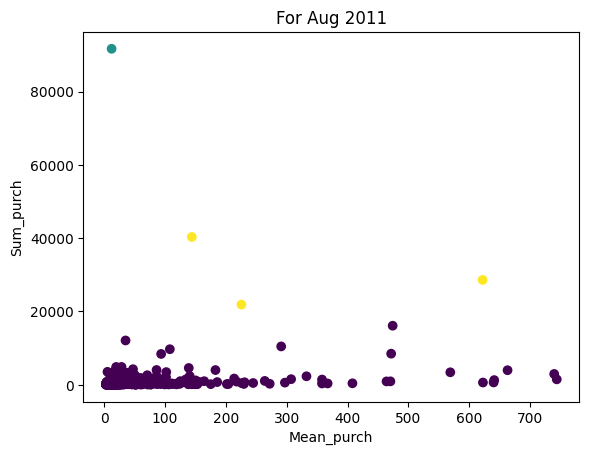

In [ ]:
plt.scatter(df_aug2011['Mean_purch'], df_aug2011['Sum_purch'], c=df_aug2011['cluster_labels'], cmap='viridis')
plt.title("For Aug 2011")
plt.xlabel('Mean_purch')
plt.ylabel('Sum_purch')
plt.show()

In [ ]:
#Below is for outliers:-

df_aug2011 = df_aug2011[df_aug2011['cluster_labels']!=1]
df_aug2011 = df_aug2011[df_aug2011['cluster_labels']!=2]
df_aug2011


No. of visits  Mean_purch  Sum_purch  Item_count  Total_quantity  \
0                1   26.586818     584.91          22             277   
1                1   17.823333     534.70          30             240   
2                1   15.641667     469.25          30             340   
3                1   36.128571     252.90           7             126   
4                1   18.350588     623.92          34             555   
..             ...         ...        ...         ...             ...   
930              6   19.748214     552.95          23             237   
931              1   16.187368     307.56          19             269   
932              1   16.953243     627.27          37             313   
933              1   16.920455     372.25          22             285   
934              1   14.315714     100.21           7              75   

     Avg_quant  CustomerID  cluster_labels  
0    12.590909           1               0  
1     8.000000          13               0  
2    11.333333          15               0  
3    18.000000          16               0  
4    16.323529          17               0  
..         ...         ...             ...  
930   8.464286        4308               0  
931  14.157895        4312               0  
932   8.459459        4318               0  
933  12.954545        4328               0  
934  10.714286        4336               0  

[932 rows x 8 columns]

In [ ]:
df_aug2011['cluster_labels'].value_counts()

0    932
Name: cluster_labels, dtype: int64

In [ ]:
df_aug2011_person = df_aug2011.copy(deep=True)
df_aug2011_person.drop(['cluster_labels'],axis=1,inplace=True)
df_aug2011_person

No. of visits  Mean_purch  Sum_purch  Item_count  Total_quantity  \
0                1   26.586818     584.91          22             277   
1                1   17.823333     534.70          30             240   
2                1   15.641667     469.25          30             340   
3                1   36.128571     252.90           7             126   
4                1   18.350588     623.92          34             555   
..             ...         ...        ...         ...             ...   
930              6   19.748214     552.95          23             237   
931              1   16.187368     307.56          19             269   
932              1   16.953243     627.27          37             313   
933              1   16.920455     372.25          22             285   
934              1   14.315714     100.21           7              75   

     Avg_quant  CustomerID  
0    12.590909           1  
1     8.000000          13  
2    11.333333          15  
3    18.000000          16  
4    16.323529          17  
..         ...         ...  
930   8.464286        4308  
931  14.157895        4312  
932   8.459459        4318  
933  12.954545        4328  
934  10.714286        4336  

[932 rows x 7 columns]

In [ ]:
df_aug2011_new = df_cluster_labels(df_aug2011_person,3)
df_aug2011_new


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


No. of visits  Mean_purch  Sum_purch  Item_count  Total_quantity  \
0                1   26.586818     584.91          22             277   
1                1   17.823333     534.70          30             240   
2                1   15.641667     469.25          30             340   
3                1   36.128571     252.90           7             126   
4                1   18.350588     623.92          34             555   
..             ...         ...        ...         ...             ...   
930              6   19.748214     552.95          23             237   
931              1   16.187368     307.56          19             269   
932              1   16.953243     627.27          37             313   
933              1   16.920455     372.25          22             285   
934              1   14.315714     100.21           7              75   

     Avg_quant  CustomerID  cluster_labels  
0    12.590909           1               0  
1     8.000000          13               0  
2    11.333333          15               0  
3    18.000000          16               0  
4    16.323529          17               0  
..         ...         ...             ...  
930   8.464286        4308               1  
931  14.157895        4312               1  
932   8.459459        4318               1  
933  12.954545        4328               1  
934  10.714286        4336               1  

[932 rows x 8 columns]

In [ ]:
silhte_score_aug2011_new = silhouette_score(df_aug2011_person, df_aug2011_new['cluster_labels'])
print("The Silhouette Score is :- "+str(silhte_score_aug2011_new))
#Indicates that silhouette score is realistic for dataset without outliers

The Silhouette Score is :- 0.5155730570325034


In [ ]:
df_aug2011_new['cluster_labels'].value_counts()
#These are comparatively good clusters

0    491
1    435
2      6
Name: cluster_labels, dtype: int64

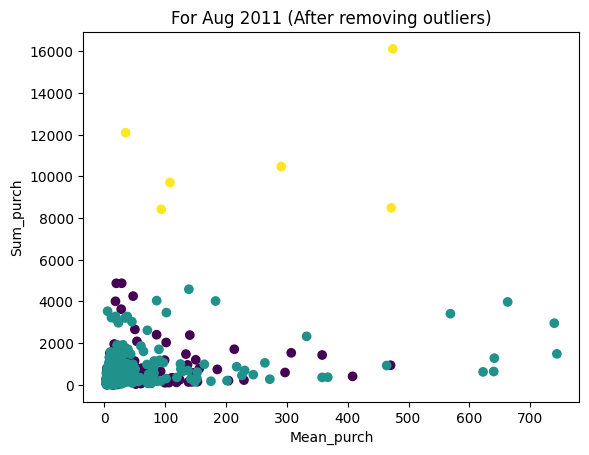

In [ ]:
plt.scatter(df_aug2011_new['Mean_purch'], df_aug2011_new['Sum_purch'], c=df_aug2011_new['cluster_labels'], cmap='viridis')
plt.title("For Aug 2011 (After removing outliers)")
plt.xlabel('Mean_purch')
plt.ylabel('Sum_purch')
plt.show()

In [ ]:
aug2011 = descrip_dict(og_aug2011,df_aug2011_new)
aug2011 = processlis(aug2011)


In [ ]:
aug2011

[     CustomerID                                        Description
 0             1  [SET OF 60 VINTAGE LEAF CAKE CASES , SET 40 HE...
 1            13  [JUMBO BAG APPLES, JUMBO BAG SPACEBOY DESIGN, ...
 2            15  [SPACEBOY CHILDRENS CUP,  DOLLY GIRL BEAKER, S...
 3            16  [STORAGE TIN VINTAGE DOILY , SET OF 72 RETROSP...
 4            17  [POSTAGE, PAPER BUNTING RETROSPOT, SPOTTY BUNT...
 ..          ...                                                ...
 486        2171  [CHILDRENS CUTLERY RETROSPOT RED , BIRD DECORA...
 487        2178  [SET/20 RED RETROSPOT PAPER NAPKINS , PARTY BU...
 488        2179                          [JUMBO BAG RED RETROSPOT]
 489        2181  [HOME GARLAND PAINTED ZINC , BATHROOM METAL SI...
 490        2188  [SAVE THE PLANET MUG, VINTAGE RED MUG, HOME SW...
 
 [491 rows x 2 columns],
      CustomerID                                        Description
 0          2177  [RED METAL BEACH SPADE , GIRLS VINTAGE TIN SEA...
 1          2199  [SK

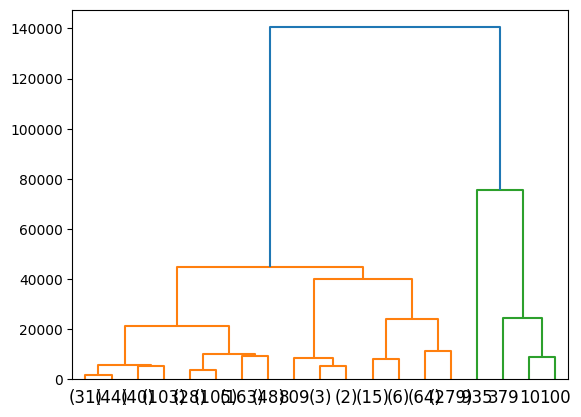

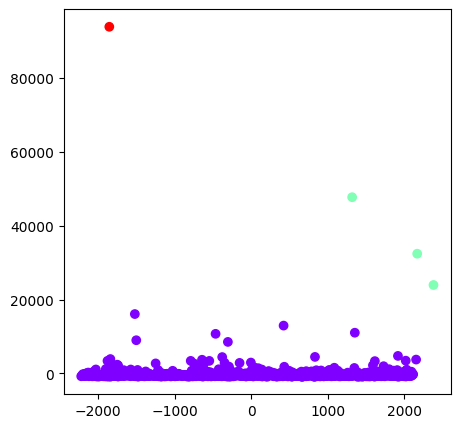

(932, 4)
(3, 4)
(1, 4)


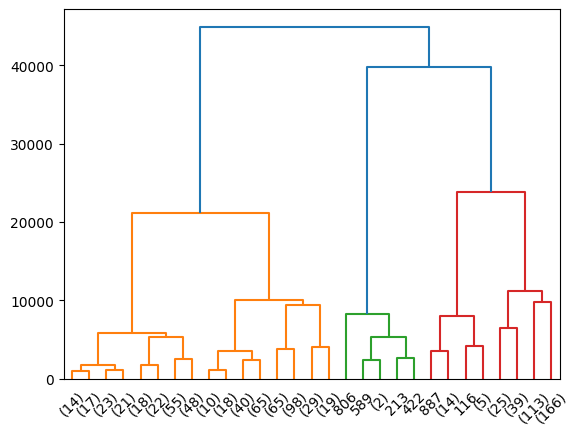

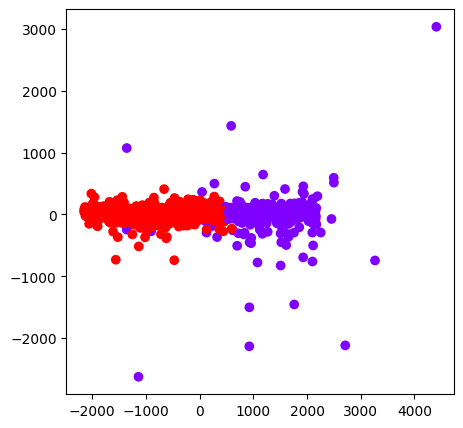

(370, 5)
(562, 5)


[     CustomerID                                        Description
 0             1  [SET OF 60 VINTAGE LEAF CAKE CASES , SET 40 HE...
 1            13  [JUMBO BAG APPLES, JUMBO BAG SPACEBOY DESIGN, ...
 2            15  [SPACEBOY CHILDRENS CUP,  DOLLY GIRL BEAKER, S...
 3            16  [STORAGE TIN VINTAGE DOILY , SET OF 72 RETROSP...
 4            17  [POSTAGE, PAPER BUNTING RETROSPOT, SPOTTY BUNT...
 ..          ...                                                ...
 557        2669  [TRAVEL SEWING KIT, VINTAGE CREAM CAT FOOD CON...
 558        2703  [JAM MAKING SET PRINTED, RED KITCHEN SCALES, I...
 559        2729  [HOME BUILDING BLOCK WORD, HEART OF WICKER LAR...
 560        2734  [UNION STRIPE WITH FRINGE  HAMMOCK, GARDENERS ...
 561        2752  [WOODEN HAPPY BIRTHDAY GARLAND, MINI WOODEN HA...
 
 [562 rows x 2 columns],
      CustomerID                                        Description
 0            27  [POPPY'S PLAYHOUSE BATHROOM, SET OF 6 3D KIT C...
 1           102  [BL

In [ ]:
pca = PCA(n_components = 3)
pca.fit(X = dvt_aug2011)
new_dvt = pca.transform(dvt_aug2011)

new_dvt = pd.DataFrame(data = new_dvt,columns = ['X0','X1','X2'])
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage='ward').fit(new_dvt)

plot_dendrogram(model, truncate_mode="level", p=4)

dict_aug2011 =  Agglocls(new_dvt,3)

final_dvt_aug2011 = dict_aug2011[0]
pca_aug2011 = PCA(n_components = 3)
pca_aug2011.fit(X = final_dvt_aug2011)
final_dvt_aug2011 = pca_aug2011.transform(final_dvt_aug2011)
final_dvt_aug2011 = pd.DataFrame(data = final_dvt_aug2011,columns = ['X0','X1','X2'])
AggloDendo(final_dvt_aug2011)

dict_aug2011_final =  AggloPca(final_dvt_aug2011,2,dvt_aug2011,'X0','X2')

aug2011_agg = descrip_dict(og_aug2011,final_dvt_aug2011)
aug2011_agg = processlis(aug2011_agg)
aug2011_agg




In [ ]:
Cluster_dict['aug2011'] = (len(aug2011),len(aug2011_agg))
dicti_2011aug = {}
klis = []
for i in range(Cluster_dict['aug2011'][0]):
  temp = apriori_rules(aug2011[i],0.075)
  klis.append(temp)
alis = []
for i in range(Cluster_dict['aug2011'][1]):
  temp = apriori_rules(aug2011_agg[i],0.075)
  alis.append(temp)
#apriori_rules(1_agg[0],0.075)
dicti_2011aug['K-means'] = klis
dicti_2011aug['Agglo'] = alis

Rules_dict['aug2011'] = dicti_2011aug

## For Sep 2011

In [ ]:
og_sep2011 = df_list_month_intervals[9]
og_sep2011

InvoiceNo StockCode                         Description  Quantity  \
320705    565080     20677                  PINK POLKADOT BOWL         8   
320706    565080     22128          PARTY CONES CANDY ASSORTED        24   
320707    565081     21067                                 NaN         1   
320708    565082     22423            REGENCY CAKESTAND 3 TIER         2   
320709    565082    15060B          FAIRY CAKE DESIGN UMBRELLA         8   
...          ...       ...                                 ...       ...   
370926    569202     22486                   PLASMATRONIC LAMP         1   
370927    569202     22495      SET OF 2 ROUND TINS CAMEMBERT          1   
370928    569202     22539              MINI JIGSAW DOLLY GIRL         2   
370929    569202     22540          MINI JIGSAW CIRCUS PARADE          2   
370930    569202     22805  BLUE DRAWER KNOB ACRYLIC EDWARDIAN        10   

        UnitPrice  CustomerID         Country time_intervals  Total Price  \
320705       1.25         871  United Kingdom    04:00-07:59        10.00   
320706       1.25         871  United Kingdom    04:00-07:59        30.00   
320707       0.00        4339  United Kingdom    08:00-11:59         0.00   
320708      12.75         722  United Kingdom    08:00-11:59        25.50   
320709       3.75         722  United Kingdom    08:00-11:59        30.00   
...           ...         ...             ...            ...          ...   
370926       8.29        4339  United Kingdom    16:00-19:59         8.29   
370927       5.79        4339  United Kingdom    16:00-19:59         5.79   
370928       0.83        4339  United Kingdom    16:00-19:59         1.66   
370929       0.83        4339  United Kingdom    16:00-19:59         1.66   
370930       1.25        4339  United Kingdom    16:00-19:59        12.50   

        Money_bins  
320705           0  
320706           0  
320707           0  
320708           0  
320709           0  
...            ...  
370926           0  
370927           0  
370928           0  
370929           0  
370930           0  

[49323 rows x 10 columns]

In [ ]:
dvt_sep2011= person_df(og_sep2011) #Our function gives such a dataframe
#By which we can form clusters using KMeans
dvt_sep2011

No. of visits  Mean_purch  Sum_purch  Item_count  Total_quantity  \
0                 1  103.333333     310.00           3             217   
1                 2   19.765625     632.50          27             155   
2                 1   20.749750     829.99          40             267   
3                 1   39.900000      79.80           2             181   
4                 1   29.470769     383.12          13             202   
...             ...         ...        ...         ...             ...   
1262              1   18.409412     312.96          17              87   
1263              1  102.000000     102.00           1              40   
1264              1   19.322222     173.90           9              66   
1265              1    2.870213     134.90          47              95   
1266            140   11.379726  105751.79        1888           30517   

      Avg_quant  CustomerID  
0     72.333333           2  
1      4.843750           5  
2      6.675000          15  
3     90.500000          17  
4     15.538462          22  
...         ...         ...  
1262   5.117647        4324  
1263  40.000000        4329  
1264   7.333333        4333  
1265   2.021277        4337  
1266   3.283870        4339  

[1267 rows x 7 columns]

In [ ]:
df_sep2011 = df_cluster_labels(dvt_sep2011,3)
df_sep2011

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


No. of visits  Mean_purch  Sum_purch  Item_count  Total_quantity  \
0                 1  103.333333     310.00           3             217   
1                 2   19.765625     632.50          27             155   
2                 1   20.749750     829.99          40             267   
3                 1   39.900000      79.80           2             181   
4                 1   29.470769     383.12          13             202   
...             ...         ...        ...         ...             ...   
1262              1   18.409412     312.96          17              87   
1263              1  102.000000     102.00           1              40   
1264              1   19.322222     173.90           9              66   
1265              1    2.870213     134.90          47              95   
1266            140   11.379726  105751.79        1888           30517   

      Avg_quant  CustomerID  cluster_labels  
0     72.333333           2               0  
1      4.843750           5               0  
2      6.675000          15               0  
3     90.500000          17               0  
4     15.538462          22               0  
...         ...         ...             ...  
1262   5.117647        4324               0  
1263  40.000000        4329               0  
1264   7.333333        4333               0  
1265   2.021277        4337               0  
1266   3.283870        4339               1  

[1267 rows x 8 columns]

In [ ]:
silhte_score_sep2011 = silhouette_score(dvt_sep2011, df_sep2011['cluster_labels'])
print("The Silhouette Score is :- "+str(silhte_score_sep2011))


The Silhouette Score is :- 0.9394436256113118


In [ ]:
df_sep2011['cluster_labels'].value_counts()

0    1261
2       4
1       2
Name: cluster_labels, dtype: int64

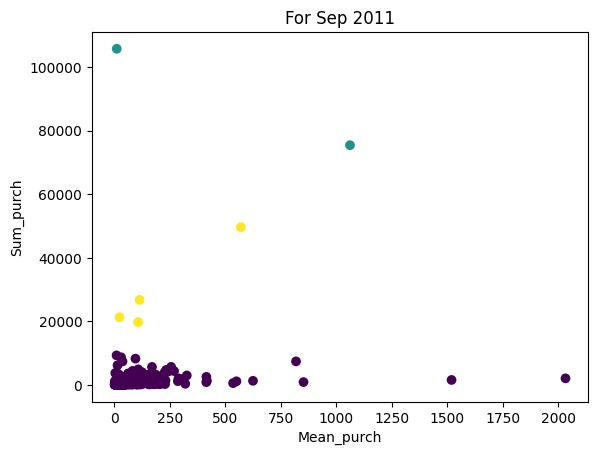

In [ ]:
plt.scatter(df_sep2011['Mean_purch'], df_sep2011['Sum_purch'], c=df_sep2011['cluster_labels'], cmap='viridis')
plt.title("For Sep 2011")
plt.xlabel('Mean_purch')
plt.ylabel('Sum_purch')
plt.show()

In [ ]:
#Thus Clusters 1 and 2 are outliers as they have very few datapoints(Customers)
#So we remove them and then applyKMeans again
#Thus
#Then check for outliers and if required, repeat the process
#Below is for outliers:-

df_sep2011 = df_sep2011[df_sep2011['cluster_labels']!=1]
df_sep2011 = df_sep2011[df_sep2011['cluster_labels']!=2]
df_sep2011

No. of visits  Mean_purch  Sum_purch  Item_count  Total_quantity  \
0                 1  103.333333     310.00           3             217   
1                 2   19.765625     632.50          27             155   
2                 1   20.749750     829.99          40             267   
3                 1   39.900000      79.80           2             181   
4                 1   29.470769     383.12          13             202   
...             ...         ...        ...         ...             ...   
1261              1   14.986667     224.80          15             102   
1262              1   18.409412     312.96          17              87   
1263              1  102.000000     102.00           1              40   
1264              1   19.322222     173.90           9              66   
1265              1    2.870213     134.90          47              95   

      Avg_quant  CustomerID  cluster_labels  
0     72.333333           2               0  
1      4.843750           5               0  
2      6.675000          15               0  
3     90.500000          17               0  
4     15.538462          22               0  
...         ...         ...             ...  
1261   6.800000        4321               0  
1262   5.117647        4324               0  
1263  40.000000        4329               0  
1264   7.333333        4333               0  
1265   2.021277        4337               0  

[1261 rows x 8 columns]

In [ ]:
df_sep2011['cluster_labels'].value_counts()

0    1261
Name: cluster_labels, dtype: int64

In [ ]:
df_sep2011_person = df_sep2011.copy(deep=True)
df_sep2011_person.drop(['cluster_labels'],axis=1,inplace=True)
df_sep2011_person


No. of visits  Mean_purch  Sum_purch  Item_count  Total_quantity  \
0                 1  103.333333     310.00           3             217   
1                 2   19.765625     632.50          27             155   
2                 1   20.749750     829.99          40             267   
3                 1   39.900000      79.80           2             181   
4                 1   29.470769     383.12          13             202   
...             ...         ...        ...         ...             ...   
1261              1   14.986667     224.80          15             102   
1262              1   18.409412     312.96          17              87   
1263              1  102.000000     102.00           1              40   
1264              1   19.322222     173.90           9              66   
1265              1    2.870213     134.90          47              95   

      Avg_quant  CustomerID  
0     72.333333           2  
1      4.843750           5  
2      6.675000          15  
3     90.500000          17  
4     15.538462          22  
...         ...         ...  
1261   6.800000        4321  
1262   5.117647        4324  
1263  40.000000        4329  
1264   7.333333        4333  
1265   2.021277        4337  

[1261 rows x 7 columns]

In [ ]:
df_sep2011_new = df_cluster_labels(df_sep2011_person,3)
df_sep2011_new

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


No. of visits  Mean_purch  Sum_purch  Item_count  Total_quantity  \
0                 1  103.333333     310.00           3             217   
1                 2   19.765625     632.50          27             155   
2                 1   20.749750     829.99          40             267   
3                 1   39.900000      79.80           2             181   
4                 1   29.470769     383.12          13             202   
...             ...         ...        ...         ...             ...   
1261              1   14.986667     224.80          15             102   
1262              1   18.409412     312.96          17              87   
1263              1  102.000000     102.00           1              40   
1264              1   19.322222     173.90           9              66   
1265              1    2.870213     134.90          47              95   

      Avg_quant  CustomerID  cluster_labels  
0     72.333333           2               1  
1      4.843750           5               1  
2      6.675000          15               1  
3     90.500000          17               1  
4     15.538462          22               1  
...         ...         ...             ...  
1261   6.800000        4321               0  
1262   5.117647        4324               0  
1263  40.000000        4329               0  
1264   7.333333        4333               0  
1265   2.021277        4337               0  

[1261 rows x 8 columns]

In [ ]:
silhte_score_sep2011_new = silhouette_score(df_sep2011_person, df_sep2011_new['cluster_labels'])
print("The Silhouette Score is :- "+str(silhte_score_sep2011_new))
#Indicates that silhouette score is realistic for dataset without outliers

The Silhouette Score is :- 0.528081845524613


In [ ]:
df_sep2011_new['cluster_labels'].value_counts()
#These are comparatively good clusters

1    623
0    603
2     35
Name: cluster_labels, dtype: int64

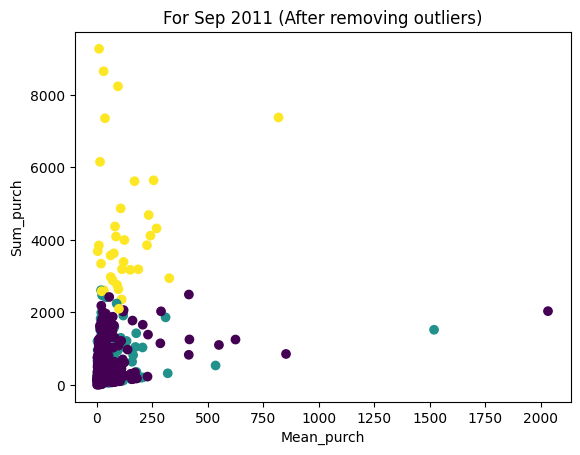

In [ ]:
plt.scatter(df_sep2011_new['Mean_purch'], df_sep2011_new['Sum_purch'], c=df_sep2011_new['cluster_labels'], cmap='viridis')
plt.title("For Sep 2011 (After removing outliers)")
plt.xlabel('Mean_purch')
plt.ylabel('Sum_purch')
plt.show()


In [ ]:
sep2011 = descrip_dict(og_sep2011,df_sep2011_new)
sep2011 = processlis(sep2011)

In [ ]:
sep2011

[     CustomerID                                        Description
 0             2  [DOUGHNUT LIP GLOSS , ICE CREAM PEN LIP GLOSS ...
 1             5  [ANTIQUE GLASS PEDESTAL BOWL, PANTRY MAGNETIC ...
 2            15  [RED RETROSPOT PICNIC BAG, RED RETROSPOT SMALL...
 3            17                 [POSTAGE, BUBBLEGUM RING ASSORTED]
 4            22  [HANGING QUILTED PATCHWORK APPLES, AIRLINE BAG...
 ..          ...                                                ...
 618        2125  [KINGS CHOICE TEA CADDY , METAL SIGN EMPIRE TE...
 619        2126  [WOODLAND BUNNIES LOLLY MAKERS, CHRISTMAS RETR...
 620        2131  [VINTAGE BILLBOARD LOVE/HATE MUG, HOME SWEET H...
 621        2132  [CHRISTMAS LIGHTS 10 SANTAS , BISCUIT TIN 50'S...
 622        2134  [WHITE HANGING HEART T-LIGHT HOLDER, 6 RIBBONS...
 
 [623 rows x 2 columns],
      CustomerID                                        Description
 0          2150  [HOME SWEET HOME CUSHION COVER , BELLE JARDINI...
 1          2151  [GR

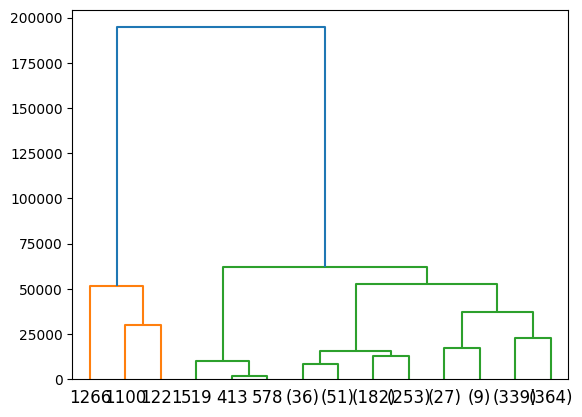

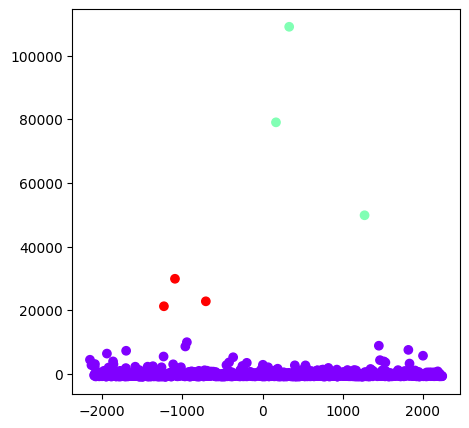

(1261, 4)
(3, 4)
(3, 4)


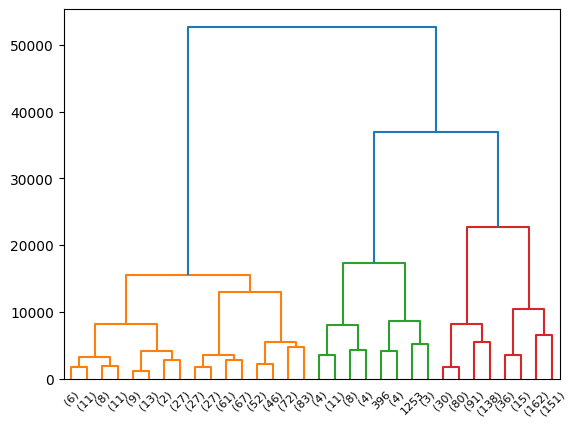

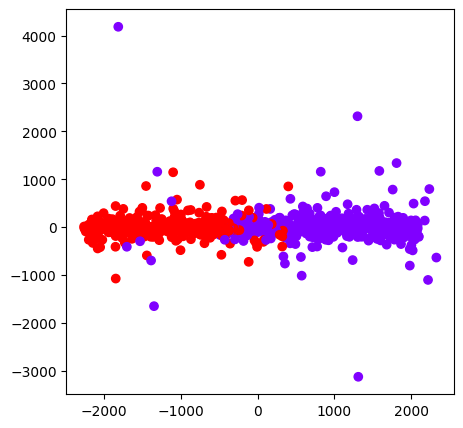

(739, 5)
(522, 5)


[     CustomerID                                        Description
 0             2  [DOUGHNUT LIP GLOSS , ICE CREAM PEN LIP GLOSS ...
 1             5  [ANTIQUE GLASS PEDESTAL BOWL, PANTRY MAGNETIC ...
 2            15  [RED RETROSPOT PICNIC BAG, RED RETROSPOT SMALL...
 3            17                 [POSTAGE, BUBBLEGUM RING ASSORTED]
 4            22  [HANGING QUILTED PATCHWORK APPLES, AIRLINE BAG...
 ..          ...                                                ...
 734        3708  [PINK CREAM FELT CRAFT TRINKET BOX , FELTCRAFT...
 735        3754  [GROW YOUR OWN BASIL IN ENAMEL MUG, FRIDGE MAG...
 736        3995  [SPOTTY PINK DUCK DOORSTOP, DOORSTOP RETROSPOT...
 737        4063                     [POLYESTER FILLER PAD 40x40cm]
 738        4303  [CARD BILLBOARD FONT, GIN & TONIC DIET GREETIN...
 
 [739 rows x 2 columns],
      CustomerID                                        Description
 0          1753  [GINGHAM RECIPE BOOK BOX, RIBBON REEL LACE DES...
 1          1855  [ST

In [ ]:
pca = PCA(n_components = 3)
pca.fit(X = dvt_sep2011)
new_dvt = pca.transform(dvt_sep2011)

new_dvt = pd.DataFrame(data = new_dvt,columns = ['X0','X1','X2'])
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage='ward').fit(new_dvt)

plot_dendrogram(model, truncate_mode="level", p=4)

dict_sep2011 =  Agglocls(new_dvt,3)

final_dvt_sep2011 = dict_sep2011[0]
pca_sep2011 = PCA(n_components = 3)
pca_sep2011.fit(X = final_dvt_sep2011)
final_dvt_sep2011 = pca_sep2011.transform(final_dvt_sep2011)
final_dvt_sep2011 = pd.DataFrame(data = final_dvt_sep2011,columns = ['X0','X1','X2'])
AggloDendo(final_dvt_sep2011)

dict_sep2011_final =  AggloPca(final_dvt_sep2011,2,dvt_sep2011,'X0','X2')

sep2011_agg = descrip_dict(og_sep2011,final_dvt_sep2011)
sep2011_agg = processlis(sep2011_agg)
sep2011_agg




In [ ]:
Cluster_dict['sep2011'] = (len(sep2011),len(sep2011_agg))
dicti_2011sep = {}
klis = []
for i in range(Cluster_dict['sep2011'][0]):
  temp = apriori_rules(sep2011[i],0.075)
  klis.append(temp)
alis = []
for i in range(Cluster_dict['sep2011'][1]):
  temp = apriori_rules(sep2011_agg[i],0.075)
  alis.append(temp)
#apriori_rules(1_agg[0],0.075)
dicti_2011sep['K-means'] = klis
dicti_2011sep['Agglo'] = alis

Rules_dict['sep2011'] = dicti_2011sep

## For Oct 2011

In [ ]:
og_oct2011 = df_list_month_intervals[9]
og_oct2011

InvoiceNo StockCode                         Description  Quantity  \
320705    565080     20677                  PINK POLKADOT BOWL         8   
320706    565080     22128          PARTY CONES CANDY ASSORTED        24   
320707    565081     21067                                 NaN         1   
320708    565082     22423            REGENCY CAKESTAND 3 TIER         2   
320709    565082    15060B          FAIRY CAKE DESIGN UMBRELLA         8   
...          ...       ...                                 ...       ...   
370926    569202     22486                   PLASMATRONIC LAMP         1   
370927    569202     22495      SET OF 2 ROUND TINS CAMEMBERT          1   
370928    569202     22539              MINI JIGSAW DOLLY GIRL         2   
370929    569202     22540          MINI JIGSAW CIRCUS PARADE          2   
370930    569202     22805  BLUE DRAWER KNOB ACRYLIC EDWARDIAN        10   

        UnitPrice  CustomerID         Country time_intervals  Total Price  \
320705       1.25         871  United Kingdom    04:00-07:59        10.00   
320706       1.25         871  United Kingdom    04:00-07:59        30.00   
320707       0.00        4339  United Kingdom    08:00-11:59         0.00   
320708      12.75         722  United Kingdom    08:00-11:59        25.50   
320709       3.75         722  United Kingdom    08:00-11:59        30.00   
...           ...         ...             ...            ...          ...   
370926       8.29        4339  United Kingdom    16:00-19:59         8.29   
370927       5.79        4339  United Kingdom    16:00-19:59         5.79   
370928       0.83        4339  United Kingdom    16:00-19:59         1.66   
370929       0.83        4339  United Kingdom    16:00-19:59         1.66   
370930       1.25        4339  United Kingdom    16:00-19:59        12.50   

        Money_bins  
320705           0  
320706           0  
320707           0  
320708           0  
320709           0  
...            ...  
370926           0  
370927           0  
370928           0  
370929           0  
370930           0  

[49323 rows x 10 columns]

In [ ]:
dvt_oct2011= person_df(og_oct2011) #Our function gives such a dataframe
#By which we can form clusters using KMeans
dvt_oct2011

No. of visits  Mean_purch  Sum_purch  Item_count  Total_quantity  \
0                 1  103.333333     310.00           3             217   
1                 2   19.765625     632.50          27             155   
2                 1   20.749750     829.99          40             267   
3                 1   39.900000      79.80           2             181   
4                 1   29.470769     383.12          13             202   
...             ...         ...        ...         ...             ...   
1262              1   18.409412     312.96          17              87   
1263              1  102.000000     102.00           1              40   
1264              1   19.322222     173.90           9              66   
1265              1    2.870213     134.90          47              95   
1266            140   11.379726  105751.79        1888           30517   

      Avg_quant  CustomerID  
0     72.333333           2  
1      4.843750           5  
2      6.675000          15  
3     90.500000          17  
4     15.538462          22  
...         ...         ...  
1262   5.117647        4324  
1263  40.000000        4329  
1264   7.333333        4333  
1265   2.021277        4337  
1266   3.283870        4339  

[1267 rows x 7 columns]

In [ ]:
df_oct2011 = df_cluster_labels(dvt_oct2011,3)
df_oct2011

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


No. of visits  Mean_purch  Sum_purch  Item_count  Total_quantity  \
0                 1  103.333333     310.00           3             217   
1                 2   19.765625     632.50          27             155   
2                 1   20.749750     829.99          40             267   
3                 1   39.900000      79.80           2             181   
4                 1   29.470769     383.12          13             202   
...             ...         ...        ...         ...             ...   
1262              1   18.409412     312.96          17              87   
1263              1  102.000000     102.00           1              40   
1264              1   19.322222     173.90           9              66   
1265              1    2.870213     134.90          47              95   
1266            140   11.379726  105751.79        1888           30517   

      Avg_quant  CustomerID  cluster_labels  
0     72.333333           2               0  
1      4.843750           5               0  
2      6.675000          15               0  
3     90.500000          17               0  
4     15.538462          22               0  
...         ...         ...             ...  
1262   5.117647        4324               0  
1263  40.000000        4329               0  
1264   7.333333        4333               0  
1265   2.021277        4337               0  
1266   3.283870        4339               1  

[1267 rows x 8 columns]

In [ ]:
silhte_score_oct2011 = silhouette_score(dvt_oct2011, df_oct2011['cluster_labels'])
print("The Silhouette Score is :- "+str(silhte_score_oct2011))

The Silhouette Score is :- 0.9394436256113118


In [ ]:
df_oct2011['cluster_labels'].value_counts()

0    1261
2       4
1       2
Name: cluster_labels, dtype: int64

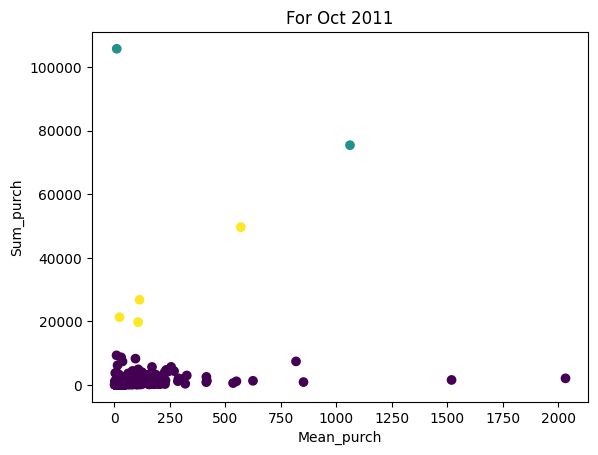

In [ ]:
plt.scatter(df_oct2011['Mean_purch'], df_oct2011['Sum_purch'], c=df_oct2011['cluster_labels'], cmap='viridis')
plt.title("For Oct 2011")
plt.xlabel('Mean_purch')
plt.ylabel('Sum_purch')
plt.show()

In [ ]:
#Thus Clusters 1 and 2 are outliers as they have very few datapoints(Customers)
#So we remove them and then applyKMeans again
#Thus
#Then check for outliers and if required, repeat the process
#Below is for outliers:-

df_oct2011 = df_oct2011[df_oct2011['cluster_labels']!=1]
df_oct2011 = df_oct2011[df_oct2011['cluster_labels']!=2]
df_oct2011


No. of visits  Mean_purch  Sum_purch  Item_count  Total_quantity  \
0                 1  103.333333     310.00           3             217   
1                 2   19.765625     632.50          27             155   
2                 1   20.749750     829.99          40             267   
3                 1   39.900000      79.80           2             181   
4                 1   29.470769     383.12          13             202   
...             ...         ...        ...         ...             ...   
1261              1   14.986667     224.80          15             102   
1262              1   18.409412     312.96          17              87   
1263              1  102.000000     102.00           1              40   
1264              1   19.322222     173.90           9              66   
1265              1    2.870213     134.90          47              95   

      Avg_quant  CustomerID  cluster_labels  
0     72.333333           2               0  
1      4.843750           5               0  
2      6.675000          15               0  
3     90.500000          17               0  
4     15.538462          22               0  
...         ...         ...             ...  
1261   6.800000        4321               0  
1262   5.117647        4324               0  
1263  40.000000        4329               0  
1264   7.333333        4333               0  
1265   2.021277        4337               0  

[1261 rows x 8 columns]

In [ ]:
df_oct2011['cluster_labels'].value_counts()

0    1261
Name: cluster_labels, dtype: int64

In [ ]:
df_oct2011_person = df_oct2011.copy(deep=True)
df_oct2011_person.drop(['cluster_labels'],axis=1,inplace=True)
df_oct2011_person

No. of visits  Mean_purch  Sum_purch  Item_count  Total_quantity  \
0                 1  103.333333     310.00           3             217   
1                 2   19.765625     632.50          27             155   
2                 1   20.749750     829.99          40             267   
3                 1   39.900000      79.80           2             181   
4                 1   29.470769     383.12          13             202   
...             ...         ...        ...         ...             ...   
1261              1   14.986667     224.80          15             102   
1262              1   18.409412     312.96          17              87   
1263              1  102.000000     102.00           1              40   
1264              1   19.322222     173.90           9              66   
1265              1    2.870213     134.90          47              95   

      Avg_quant  CustomerID  
0     72.333333           2  
1      4.843750           5  
2      6.675000          15  
3     90.500000          17  
4     15.538462          22  
...         ...         ...  
1261   6.800000        4321  
1262   5.117647        4324  
1263  40.000000        4329  
1264   7.333333        4333  
1265   2.021277        4337  

[1261 rows x 7 columns]

In [ ]:
df_oct2011_new = df_cluster_labels(df_oct2011_person,3)
df_oct2011_new

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


No. of visits  Mean_purch  Sum_purch  Item_count  Total_quantity  \
0                 1  103.333333     310.00           3             217   
1                 2   19.765625     632.50          27             155   
2                 1   20.749750     829.99          40             267   
3                 1   39.900000      79.80           2             181   
4                 1   29.470769     383.12          13             202   
...             ...         ...        ...         ...             ...   
1261              1   14.986667     224.80          15             102   
1262              1   18.409412     312.96          17              87   
1263              1  102.000000     102.00           1              40   
1264              1   19.322222     173.90           9              66   
1265              1    2.870213     134.90          47              95   

      Avg_quant  CustomerID  cluster_labels  
0     72.333333           2               1  
1      4.843750           5               1  
2      6.675000          15               1  
3     90.500000          17               1  
4     15.538462          22               1  
...         ...         ...             ...  
1261   6.800000        4321               0  
1262   5.117647        4324               0  
1263  40.000000        4329               0  
1264   7.333333        4333               0  
1265   2.021277        4337               0  

[1261 rows x 8 columns]

In [ ]:
silhte_score_oct2011_new = silhouette_score(df_oct2011_person, df_oct2011_new['cluster_labels'])
print("The Silhouette Score is :- "+str(silhte_score_oct2011_new))
#Indicates that silhouette score is realistic for dataset without outliers


The Silhouette Score is :- 0.528081845524613


In [ ]:
df_oct2011_new['cluster_labels'].value_counts()
#These are comparatively good clusters

1    623
0    603
2     35
Name: cluster_labels, dtype: int64

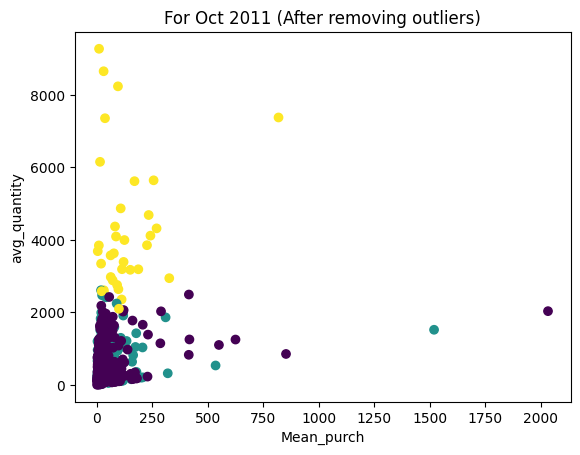

In [ ]:
plt.scatter(df_oct2011_new['Mean_purch'], df_oct2011_new['Sum_purch'], c=df_oct2011_new['cluster_labels'], cmap='viridis')
plt.title("For Oct 2011 (After removing outliers)")
plt.xlabel('Mean_purch')
plt.ylabel('avg_quantity')
plt.show()

In [ ]:
oct2011 = descrip_dict(og_oct2011,df_oct2011_new)
oct2011 = processlis(oct2011)

In [ ]:
oct2011

[     CustomerID                                        Description
 0             2  [DOUGHNUT LIP GLOSS , ICE CREAM PEN LIP GLOSS ...
 1             5  [ANTIQUE GLASS PEDESTAL BOWL, PANTRY MAGNETIC ...
 2            15  [RED RETROSPOT PICNIC BAG, RED RETROSPOT SMALL...
 3            17                 [POSTAGE, BUBBLEGUM RING ASSORTED]
 4            22  [HANGING QUILTED PATCHWORK APPLES, AIRLINE BAG...
 ..          ...                                                ...
 618        2125  [KINGS CHOICE TEA CADDY , METAL SIGN EMPIRE TE...
 619        2126  [WOODLAND BUNNIES LOLLY MAKERS, CHRISTMAS RETR...
 620        2131  [VINTAGE BILLBOARD LOVE/HATE MUG, HOME SWEET H...
 621        2132  [CHRISTMAS LIGHTS 10 SANTAS , BISCUIT TIN 50'S...
 622        2134  [WHITE HANGING HEART T-LIGHT HOLDER, 6 RIBBONS...
 
 [623 rows x 2 columns],
      CustomerID                                        Description
 0          2150  [HOME SWEET HOME CUSHION COVER , BELLE JARDINI...
 1          2151  [GR

In [ ]:
print(dvt_oct2011)

      No. of visits  Mean_purch  Sum_purch  Item_count  Total_quantity  \
0                 1  103.333333     310.00           3             217   
1                 2   19.765625     632.50          27             155   
2                 1   20.749750     829.99          40             267   
3                 1   39.900000      79.80           2             181   
4                 1   29.470769     383.12          13             202   
...             ...         ...        ...         ...             ...   
1262              1   18.409412     312.96          17              87   
1263              1  102.000000     102.00           1              40   
1264              1   19.322222     173.90           9              66   
1265              1    2.870213     134.90          47              95   
1266            140   11.379726  105751.79        1888           30517   

      Avg_quant  CustomerID  
0     72.333333           2  
1      4.843750           5  
2      6.675000      

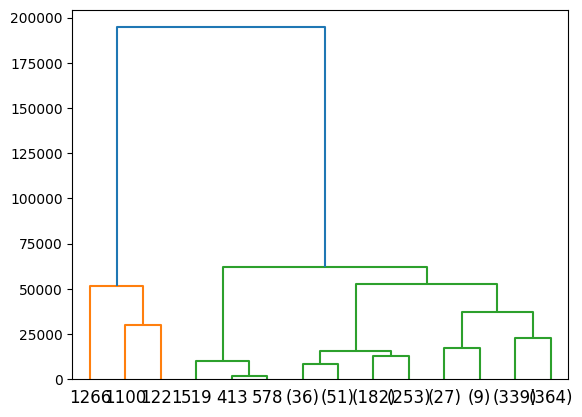

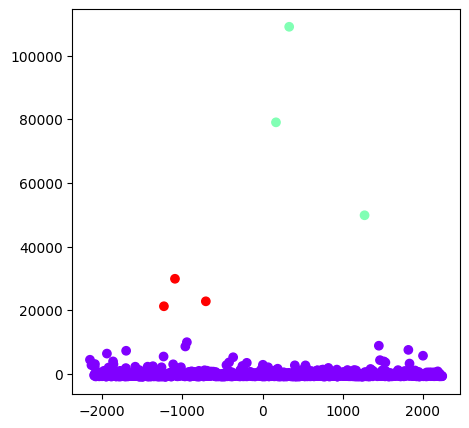

(1261, 4)
(3, 4)
(3, 4)


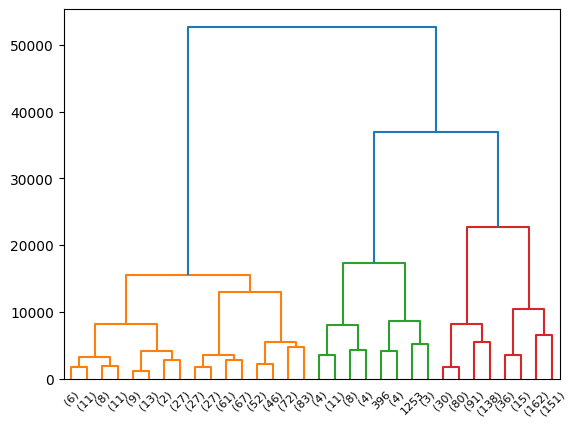

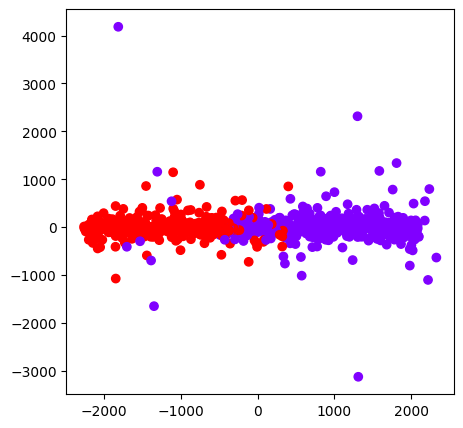

(739, 5)
(522, 5)


[     CustomerID                                        Description
 0             2  [DOUGHNUT LIP GLOSS , ICE CREAM PEN LIP GLOSS ...
 1             5  [ANTIQUE GLASS PEDESTAL BOWL, PANTRY MAGNETIC ...
 2            15  [RED RETROSPOT PICNIC BAG, RED RETROSPOT SMALL...
 3            17                 [POSTAGE, BUBBLEGUM RING ASSORTED]
 4            22  [HANGING QUILTED PATCHWORK APPLES, AIRLINE BAG...
 ..          ...                                                ...
 734        3708  [PINK CREAM FELT CRAFT TRINKET BOX , FELTCRAFT...
 735        3754  [GROW YOUR OWN BASIL IN ENAMEL MUG, FRIDGE MAG...
 736        3995  [SPOTTY PINK DUCK DOORSTOP, DOORSTOP RETROSPOT...
 737        4063                     [POLYESTER FILLER PAD 40x40cm]
 738        4303  [CARD BILLBOARD FONT, GIN & TONIC DIET GREETIN...
 
 [739 rows x 2 columns],
      CustomerID                                        Description
 0          1753  [GINGHAM RECIPE BOOK BOX, RIBBON REEL LACE DES...
 1          1855  [ST

In [ ]:

pca = PCA(n_components = 3)
pca.fit(X = dvt_oct2011)
new_dvt = pca.transform(dvt_oct2011)

new_dvt = pd.DataFrame(data = new_dvt,columns = ['X0','X1','X2'])
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage='ward').fit(new_dvt)

plot_dendrogram(model, truncate_mode="level", p=4)

dict_oct2011 =  Agglocls(new_dvt,3)

final_dvt_oct2011 = dict_oct2011[0]
pca_oct2011 = PCA(n_components = 3)
pca_oct2011.fit(X = final_dvt_oct2011)
final_dvt_oct2011 = pca_oct2011.transform(final_dvt_oct2011)
final_dvt_oct2011 = pd.DataFrame(data = final_dvt_oct2011,columns = ['X0','X1','X2'])
AggloDendo(final_dvt_oct2011)

dict_oct2011_final =  AggloPca(final_dvt_oct2011,2,dvt_oct2011,'X0','X2')

oct2011_agg = descrip_dict(og_oct2011,final_dvt_oct2011)
oct2011_agg = processlis(oct2011_agg)
oct2011_agg




In [ ]:
Cluster_dict['oct2011'] = (len(oct2011),len(oct2011_agg))
dicti_2011oct = {}
klis = []
for i in range(Cluster_dict['oct2011'][0]):
  temp = apriori_rules(oct2011[i],0.075)
  klis.append(temp)
alis = []
for i in range(Cluster_dict['oct2011'][1]):
  temp = apriori_rules(oct2011_agg[i],0.075)
  alis.append(temp)
#apriori_rules(1_agg[0],0.075)
dicti_2011oct['K-means'] = klis
dicti_2011oct['Agglo'] = alis

Rules_dict['oct2011'] = dicti_2011oct

In [ ]:
# only 4 persons visited the store in october hence this analysis is very biased and irrelevant for october analysis 

## For Nov 2011

In [ ]:
og_nov2011 = df_list_month_intervals[11]
og_nov2011

InvoiceNo StockCode                         Description  Quantity  \
431673    573744     21314       SMALL GLASS HEART TRINKET POT         8   
431674    573744     21704             BAG 250g SWIRLY MARBLES        12   
431675    573744     21791  VINTAGE HEADS AND TAILS CARD GAME         12   
431676    573744     21892  TRADITIONAL WOODEN CATCH CUP GAME         12   
431677    573744     21915              RED  HARMONICA IN BOX         12   
...          ...       ...                                 ...       ...   
516364    579885    85034C         3 ROSE MORRIS BOXED CANDLES         4   
516365    579885     21742         LARGE ROUND WICKER PLATTER          2   
516366    579885     23084                  RABBIT NIGHT LIGHT         6   
516367    579885     21257         VICTORIAN SEWING BOX MEDIUM         1   
516368    579885     21259         VICTORIAN SEWING BOX SMALL          1   

        UnitPrice  CustomerID         Country time_intervals  Total Price  \
431673       2.10        3941  United Kingdom    04:00-07:59        16.80   
431674       0.85        3941  United Kingdom    04:00-07:59        10.20   
431675       1.25        3941  United Kingdom    04:00-07:59        15.00   
431676       1.25        3941  United Kingdom    04:00-07:59        15.00   
431677       1.25        3941  United Kingdom    04:00-07:59        15.00   
...           ...         ...             ...            ...          ...   
516364       1.25        2275  United Kingdom    16:00-19:59         5.00   
516365       5.95        2275  United Kingdom    16:00-19:59        11.90   
516366       2.08        2275  United Kingdom    16:00-19:59        12.48   
516367       7.95        2275  United Kingdom    16:00-19:59         7.95   
516368       5.95        2275  United Kingdom    16:00-19:59         5.95   

        Money_bins  
431673           0  
431674           0  
431675           0  
431676           0  
431677           0  
...            ...  
516364           0  
516365           0  
516366           0  
516367           0  
516368           0  

[83498 rows x 10 columns]

In [ ]:
dvt_nov2011= person_df(og_nov2011) #Our function gives such a dataframe
#By which we can form clusters using KMeans
dvt_nov2011

No. of visits  Mean_purch  Sum_purch  Item_count  Total_quantity  \
0                 1   24.076027    1757.55          73             631   
1                 1   20.782000     311.73          15             127   
2                 1   29.175000      58.35           2               5   
3                 1   47.386794    6207.67         131            2708   
4                 1   29.871250     477.94          16             210   
...             ...         ...        ...         ...             ...   
1661              1   25.110000     401.76          16             420   
1662              1   28.533333     171.20           6              60   
1663              1   15.992727     175.92          11              88   
1664              4    2.975160     651.56         115             450   
1665            226   18.344270  347678.95        2276           89710   

      Avg_quant  CustomerID  
0      8.643836           3  
1      8.466667           5  
2      2.500000           9  
3     20.671756          10  
4     13.125000          15  
...         ...         ...  
1661  26.250000        4323  
1662  10.000000        4327  
1663   8.000000        4330  
1664   2.054795        4337  
1665   4.733288        4339  

[1666 rows x 7 columns]

In [ ]:
df_nov2011 = df_cluster_labels(dvt_nov2011,3)
df_nov2011

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


No. of visits  Mean_purch  Sum_purch  Item_count  Total_quantity  \
0                 1   24.076027    1757.55          73             631   
1                 1   20.782000     311.73          15             127   
2                 1   29.175000      58.35           2               5   
3                 1   47.386794    6207.67         131            2708   
4                 1   29.871250     477.94          16             210   
...             ...         ...        ...         ...             ...   
1661              1   25.110000     401.76          16             420   
1662              1   28.533333     171.20           6              60   
1663              1   15.992727     175.92          11              88   
1664              4    2.975160     651.56         115             450   
1665            226   18.344270  347678.95        2276           89710   

      Avg_quant  CustomerID  cluster_labels  
0      8.643836           3               0  
1      8.466667           5               0  
2      2.500000           9               0  
3     20.671756          10               0  
4     13.125000          15               0  
...         ...         ...             ...  
1661  26.250000        4323               0  
1662  10.000000        4327               0  
1663   8.000000        4330               0  
1664   2.054795        4337               0  
1665   4.733288        4339               1  

[1666 rows x 8 columns]

In [ ]:
silhte_score_nov2011 = silhouette_score(dvt_nov2011, df_nov2011['cluster_labels'])
print("The Silhouette Score is :- "+str(silhte_score_nov2011))

The Silhouette Score is :- 0.9020918639507166


In [ ]:
df_nov2011['cluster_labels'].value_counts()

0    1655
2      10
1       1
Name: cluster_labels, dtype: int64

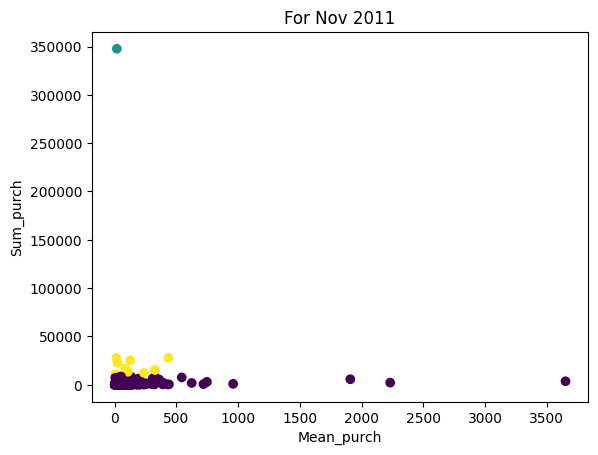

In [ ]:
plt.scatter(df_nov2011['Mean_purch'], df_nov2011['Sum_purch'], c=df_nov2011['cluster_labels'], cmap='viridis')
plt.title("For Nov 2011")
plt.xlabel('Mean_purch')
plt.ylabel('Sum_purch')
plt.show()

In [ ]:
#Thus Clusters 1 and 2 are outliers as they have very few datapoints(Customers)
#So we remove them and then applyKMeans again
#Thus
#Then check for outliers and if required, repeat the process
#Below is for outliers:-

df_nov2011 = df_nov2011[df_nov2011['cluster_labels']!=1]
df_nov2011 = df_nov2011[df_nov2011['cluster_labels']!=2]
df_nov2011

No. of visits  Mean_purch  Sum_purch  Item_count  Total_quantity  \
0                 1   24.076027    1757.55          73             631   
1                 1   20.782000     311.73          15             127   
2                 1   29.175000      58.35           2               5   
3                 1   47.386794    6207.67         131            2708   
4                 1   29.871250     477.94          16             210   
...             ...         ...        ...         ...             ...   
1660              1   76.457143    1070.40          14             336   
1661              1   25.110000     401.76          16             420   
1662              1   28.533333     171.20           6              60   
1663              1   15.992727     175.92          11              88   
1664              4    2.975160     651.56         115             450   

      Avg_quant  CustomerID  cluster_labels  
0      8.643836           3               0  
1      8.466667           5               0  
2      2.500000           9               0  
3     20.671756          10               0  
4     13.125000          15               0  
...         ...         ...             ...  
1660  24.000000        4319               0  
1661  26.250000        4323               0  
1662  10.000000        4327               0  
1663   8.000000        4330               0  
1664   2.054795        4337               0  

[1655 rows x 8 columns]

In [ ]:
df_nov2011['cluster_labels'].value_counts()

0    1655
Name: cluster_labels, dtype: int64

In [ ]:
#Thus the outliers are removed.
#Now we again apply the clustering pipeline

df_nov2011_person = df_nov2011.copy(deep=True)
df_nov2011_person.drop(['cluster_labels'],axis=1,inplace=True)
df_nov2011_person


No. of visits  Mean_purch  Sum_purch  Item_count  Total_quantity  \
0                 1   24.076027    1757.55          73             631   
1                 1   20.782000     311.73          15             127   
2                 1   29.175000      58.35           2               5   
3                 1   47.386794    6207.67         131            2708   
4                 1   29.871250     477.94          16             210   
...             ...         ...        ...         ...             ...   
1660              1   76.457143    1070.40          14             336   
1661              1   25.110000     401.76          16             420   
1662              1   28.533333     171.20           6              60   
1663              1   15.992727     175.92          11              88   
1664              4    2.975160     651.56         115             450   

      Avg_quant  CustomerID  
0      8.643836           3  
1      8.466667           5  
2      2.500000           9  
3     20.671756          10  
4     13.125000          15  
...         ...         ...  
1660  24.000000        4319  
1661  26.250000        4323  
1662  10.000000        4327  
1663   8.000000        4330  
1664   2.054795        4337  

[1655 rows x 7 columns]

In [ ]:
df_nov2011_new = df_cluster_labels(df_nov2011_person,3)
df_nov2011_new

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


No. of visits  Mean_purch  Sum_purch  Item_count  Total_quantity  \
0                 1   24.076027    1757.55          73             631   
1                 1   20.782000     311.73          15             127   
2                 1   29.175000      58.35           2               5   
3                 1   47.386794    6207.67         131            2708   
4                 1   29.871250     477.94          16             210   
...             ...         ...        ...         ...             ...   
1660              1   76.457143    1070.40          14             336   
1661              1   25.110000     401.76          16             420   
1662              1   28.533333     171.20           6              60   
1663              1   15.992727     175.92          11              88   
1664              4    2.975160     651.56         115             450   

      Avg_quant  CustomerID  cluster_labels  
0      8.643836           3               1  
1      8.466667           5               1  
2      2.500000           9               1  
3     20.671756          10               2  
4     13.125000          15               1  
...         ...         ...             ...  
1660  24.000000        4319               0  
1661  26.250000        4323               0  
1662  10.000000        4327               0  
1663   8.000000        4330               0  
1664   2.054795        4337               0  

[1655 rows x 8 columns]

In [ ]:
silhte_score_nov2011_new = silhouette_score(df_nov2011_person, df_nov2011_new['cluster_labels'])
print("The Silhouette Score is :- "+str(silhte_score_nov2011_new))
#Indicates that silhouette score is realistic for dataset without outliers

The Silhouette Score is :- 0.5272193764190273


In [ ]:
df_nov2011_new['cluster_labels'].value_counts()

0    815
1    811
2     29
Name: cluster_labels, dtype: int64

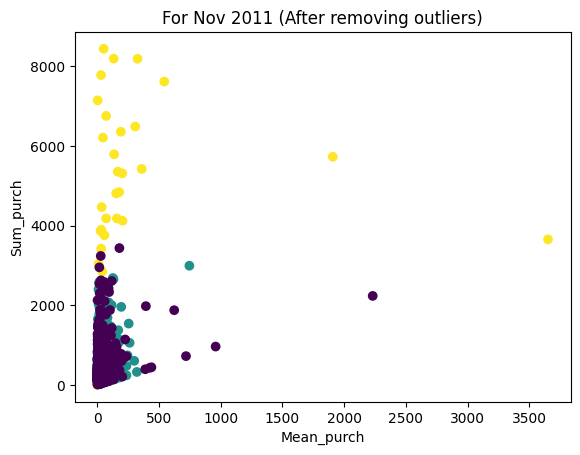

In [ ]:
#These are comparatively good clusters

plt.scatter(df_nov2011_new['Mean_purch'], df_nov2011_new['Sum_purch'], c=df_nov2011_new['cluster_labels'], cmap='viridis')
plt.title("For Nov 2011 (After removing outliers)")
plt.xlabel('Mean_purch')
plt.ylabel('Sum_purch')
plt.show()

In [ ]:
nov2011 = descrip_dict(og_dec2010,df_dec2010_new)
nov2011 = processlis(nov2011)

In [ ]:
nov2011

[     CustomerID                                        Description
 0             1  [BLACK CANDELABRA T-LIGHT HOLDER, AIRLINE BAG ...
 1             2  [72 SWEETHEART FAIRY CAKE CASES, 60 CAKE CASES...
 2            20  [WHITE HANGING HEART T-LIGHT HOLDER, SPACE CAD...
 3            26  [HOT WATER BOTTLE BABUSHKA LARGE, CHOCOLATE HO...
 4            31  [SET/10 RED POLKADOT PARTY CANDLES, SET/10 PIN...
 ..          ...                                                ...
 398        2226  [JAM MAKING SET WITH JARS, JAM MAKING SET PRIN...
 399        2227                       [HAND OPEN SHAPE DECO.WHITE]
 400        2230  [SKULL DESIGN TV DINNER TRAY, TV DINNER TRAY D...
 401        2235  [DANISH ROSE ROUND SEWING BOX, 3 STRIPEY MICE ...
 402        2237  [DOLLY GIRL LUNCH BOX, SPACEBOY LUNCH BOX , LU...
 
 [403 rows x 2 columns],
      CustomerID                                        Description
 0          2261  [CHOCOLATE HOT WATER BOTTLE, PAPER CHAIN KIT V...
 1          2283  [RE

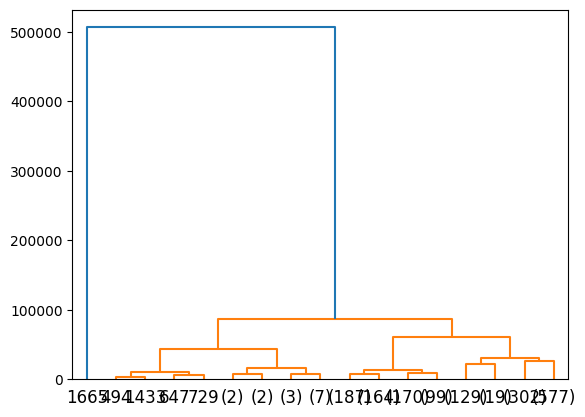

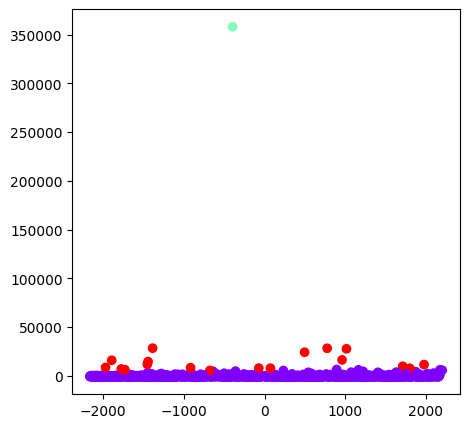

(1647, 4)
(1, 4)
(18, 4)


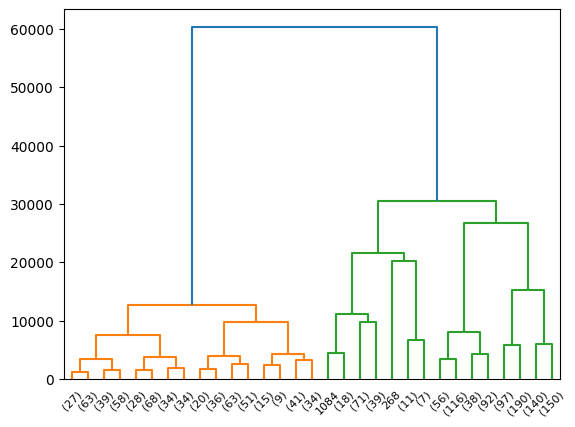

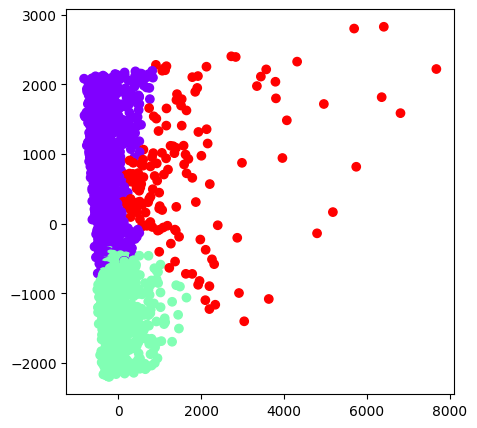

(879, 5)
(620, 5)
(148, 5)


[     CustomerID                                        Description
 0             3  [PARISIENNE CURIO CABINET, SWEETHEART WALL TID...
 1            10  [PINK DOUGHNUT TRINKET POT , STRAWBERRY CERAMI...
 2            47  [SET OF 3 CAKE TINS SKETCHBOOK, TEA BAG PLATE ...
 3            55  [BISCUIT TIN 50'S CHRISTMAS, SET OF 6 NATIVITY...
 4            71  [VINTAGE DOILY TRAVEL SEWING KIT, TRADITIONAL ...
 ..          ...                                                ...
 143        3471  [WALL ART VILLAGE SHOW , VINTAGE SHELLS PRINT,...
 144        3563  [KEY RING BASEBALL BOOT ASSORTED , ROLL WRAP 5...
 145        3609  [REGENCY CAKESTAND 3 TIER, T-LIGHT GLASS FLUTE...
 146        3619  [REGENCY SUGAR BOWL GREEN, IVORY WICKER HEART ...
 147        3863  [BOX OF 6 CHRISTMAS CAKE DECORATIONS, ASSORTED...
 
 [148 rows x 2 columns],
      CustomerID                                        Description
 0             5  [PETIT TRAY CHIC, PANTRY ROLLING PIN, PANTRY P...
 1             9  [RE

In [ ]:

pca = PCA(n_components = 3)
pca.fit(X = dvt_nov2011)
new_dvt = pca.transform(dvt_nov2011)

new_dvt = pd.DataFrame(data = new_dvt,columns = ['X0','X1','X2'])
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage='ward').fit(new_dvt)

plot_dendrogram(model, truncate_mode="level", p=4)

dict_nov2011 =  Agglocls(new_dvt,3)

final_dvt_nov2011 = dict_nov2011[0]
pca_nov2011 = PCA(n_components = 3)
pca_nov2011.fit(X = final_dvt_nov2011)
final_dvt_nov2011 = pca_nov2011.transform(final_dvt_nov2011)
final_dvt_nov2011 = pd.DataFrame(data = final_dvt_nov2011,columns = ['X0','X1','X2'])
AggloDendo(final_dvt_nov2011)

dict_nov2011_final =  AggloPca(final_dvt_nov2011,3,dvt_nov2011,'X1','X0')

nov2011_agg = descrip_dict(og_nov2011,final_dvt_nov2011)
nov2011_agg = processlis(nov2011_agg)
nov2011_agg




In [ ]:
Cluster_dict['nov2011'] = (len(nov2011),len(nov2011_agg))
dicti_2011nov = {}
klis = []
for i in range(Cluster_dict['nov2011'][0]):
  temp = apriori_rules(nov2011[i],0.075)
  klis.append(temp)
alis = []
for i in range(Cluster_dict['nov2011'][1]):
  temp = apriori_rules(nov2011_agg[i],0.075)
  alis.append(temp)
#apriori_rules(1_agg[0],0.075)
dicti_2011nov['K-means'] = klis
dicti_2011nov['Agglo'] = alis

Rules_dict['nov2011'] = dicti_2011nov

## Dec 2011

In [ ]:
og_dec2011 = df_list_month_intervals[12]
og_dec2011


InvoiceNo StockCode                          Description  Quantity  \
516403    579899     23301    GARDENERS KNEELING PAD KEEP CALM         24   
516404    579899     22623        BOX OF VINTAGE JIGSAW BLOCKS          3   
516405    579899     20970   PINK FLORAL FELTCRAFT SHOULDER BAG         4   
516406    579899     23562  SET OF 6 RIBBONS PERFECTLY PRETTY           6   
516407    579899     71477   COLOURED GLASS STAR T-LIGHT HOLDER         4   
...          ...       ...                                  ...       ...   
541904    581587     22613          PACK OF 20 SPACEBOY NAPKINS        12   
541905    581587     22899         CHILDREN'S APRON DOLLY GIRL          6   
541906    581587     23254        CHILDRENS CUTLERY DOLLY GIRL          4   
541907    581587     23255      CHILDRENS CUTLERY CIRCUS PARADE         4   
541908    581587     22138        BAKING SET 9 PIECE RETROSPOT          3   

        UnitPrice  CustomerID         Country time_intervals  Total Price  \
516403       1.65        2457  United Kingdom    04:00-07:59        39.60   
516404       5.95        2457  United Kingdom    04:00-07:59        17.85   
516405       3.75        2457  United Kingdom    04:00-07:59        15.00   
516406       2.89        2457  United Kingdom    04:00-07:59        17.34   
516407       3.95        2457  United Kingdom    04:00-07:59        15.80   
...           ...         ...             ...            ...          ...   
541904       0.85         271          France    08:00-11:59        10.20   
541905       2.10         271          France    08:00-11:59        12.60   
541906       4.15         271          France    08:00-11:59        16.60   
541907       4.15         271          France    08:00-11:59        16.60   
541908       4.95         271          France    08:00-11:59        14.85   

        Money_bins  
516403           0  
516404           0  
516405           0  
516406           0  
516407           0  
...            ...  
541904           0  
541905           0  
541906           0  
541907           0  
541908           0  

[25135 rows x 10 columns]

In [ ]:
dvt_dec2011= person_df(og_dec2011) #Our function gives such a dataframe
#By which we can form clusters using KMeans
dvt_dec2011

No. of visits  Mean_purch  Sum_purch  Item_count  Total_quantity  \
0                1   20.438182     224.82          11             192   
1                1   97.600000     683.20           7             148   
2                1   17.634667     529.04          30             221   
3                1   11.493333     310.32          27             502   
4                1   15.354545     168.90          11             173   
..             ...         ...        ...         ...             ...   
611              1   15.994783     367.88          23             254   
612              1   51.000000      51.00           1              20   
613              1   15.568000      77.84           5              28   
614              1    4.160000     208.00          50             142   
615             61   15.400318  120599.89        1806           27639   

     Avg_quant  CustomerID  
0    17.454545           1  
1    21.142857          11  
2     7.366667          15  
3    18.592593          17  
4    15.727273          19  
..         ...         ...  
611  11.043478        4328  
612  20.000000        4329  
613   5.600000        4336  
614   2.840000        4337  
615   3.529434        4339  

[616 rows x 7 columns]

In [ ]:
df_dec2011 = df_cluster_labels(dvt_dec2011,3)
df_dec2011


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


No. of visits  Mean_purch  Sum_purch  Item_count  Total_quantity  \
0                1   20.438182     224.82          11             192   
1                1   97.600000     683.20           7             148   
2                1   17.634667     529.04          30             221   
3                1   11.493333     310.32          27             502   
4                1   15.354545     168.90          11             173   
..             ...         ...        ...         ...             ...   
611              1   15.994783     367.88          23             254   
612              1   51.000000      51.00           1              20   
613              1   15.568000      77.84           5              28   
614              1    4.160000     208.00          50             142   
615             61   15.400318  120599.89        1806           27639   

     Avg_quant  CustomerID  cluster_labels  
0    17.454545           1               0  
1    21.142857          11               0  
2     7.366667          15               0  
3    18.592593          17               0  
4    15.727273          19               0  
..         ...         ...             ...  
611  11.043478        4328               0  
612  20.000000        4329               0  
613   5.600000        4336               0  
614   2.840000        4337               0  
615   3.529434        4339               2  

[616 rows x 8 columns]

In [ ]:
silhte_score_dec2011 = silhouette_score(dvt_dec2011, df_dec2011['cluster_labels'])
print("The Silhouette Score is :- "+str(silhte_score_dec2011))

The Silhouette Score is :- 0.9811245243992047


In [ ]:
df_dec2011['cluster_labels'].value_counts()

0    614
1      1
2      1
Name: cluster_labels, dtype: int64

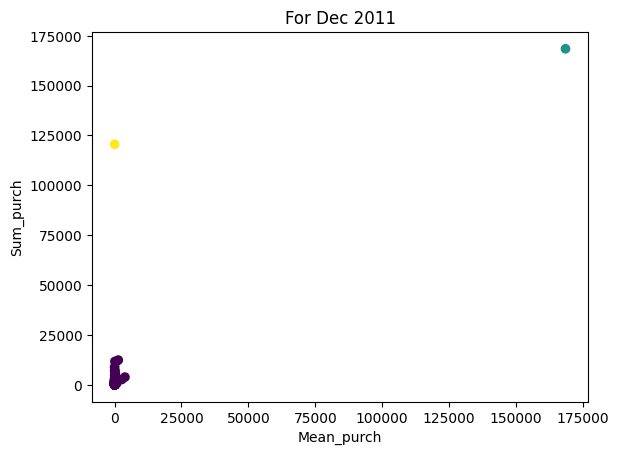

In [ ]:
plt.scatter(df_dec2011['Mean_purch'], df_dec2011['Sum_purch'], c=df_dec2011['cluster_labels'], cmap='viridis')
plt.title("For Dec 2011")
plt.xlabel('Mean_purch')
plt.ylabel('Sum_purch')
plt.show()

In [ ]:
#Thus Clusters 1 and 2 are outliers as they have very few datapoints(Customers)
#So we remove them and then applyKMeans again
#Thus
#Then check for outliers and if required, repeat the process
#Below is for outliers:-

df_dec2011 = df_dec2011[df_dec2011['cluster_labels']!=1]
df_dec2011 = df_dec2011[df_dec2011['cluster_labels']!=2]
df_dec2011

No. of visits  Mean_purch  Sum_purch  Item_count  Total_quantity  \
0                1   20.438182     224.82          11             192   
1                1   97.600000     683.20           7             148   
2                1   17.634667     529.04          30             221   
3                1   11.493333     310.32          27             502   
4                1   15.354545     168.90          11             173   
..             ...         ...        ...         ...             ...   
610              1   16.259091     894.25          55             460   
611              1   15.994783     367.88          23             254   
612              1   51.000000      51.00           1              20   
613              1   15.568000      77.84           5              28   
614              1    4.160000     208.00          50             142   

     Avg_quant  CustomerID  cluster_labels  
0    17.454545           1               0  
1    21.142857          11               0  
2     7.366667          15               0  
3    18.592593          17               0  
4    15.727273          19               0  
..         ...         ...             ...  
610   8.363636        4310               0  
611  11.043478        4328               0  
612  20.000000        4329               0  
613   5.600000        4336               0  
614   2.840000        4337               0  

[614 rows x 8 columns]

In [ ]:
df_dec2011['cluster_labels'].value_counts()

0    614
Name: cluster_labels, dtype: int64

In [ ]:
#Thus the outliers are removed.
#Now we again apply the clustering pipeline

df_dec2011_person = df_dec2011.copy(deep=True)
df_dec2011_person.drop(['cluster_labels'],axis=1,inplace=True)
df_dec2011_person


No. of visits  Mean_purch  Sum_purch  Item_count  Total_quantity  \
0                1   20.438182     224.82          11             192   
1                1   97.600000     683.20           7             148   
2                1   17.634667     529.04          30             221   
3                1   11.493333     310.32          27             502   
4                1   15.354545     168.90          11             173   
..             ...         ...        ...         ...             ...   
610              1   16.259091     894.25          55             460   
611              1   15.994783     367.88          23             254   
612              1   51.000000      51.00           1              20   
613              1   15.568000      77.84           5              28   
614              1    4.160000     208.00          50             142   

     Avg_quant  CustomerID  
0    17.454545           1  
1    21.142857          11  
2     7.366667          15  
3    18.592593          17  
4    15.727273          19  
..         ...         ...  
610   8.363636        4310  
611  11.043478        4328  
612  20.000000        4329  
613   5.600000        4336  
614   2.840000        4337  

[614 rows x 7 columns]

In [ ]:
df_dec2011_new = df_cluster_labels(df_dec2011_person,3)
df_dec2011_new

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


No. of visits  Mean_purch  Sum_purch  Item_count  Total_quantity  \
0                1   20.438182     224.82          11             192   
1                1   97.600000     683.20           7             148   
2                1   17.634667     529.04          30             221   
3                1   11.493333     310.32          27             502   
4                1   15.354545     168.90          11             173   
..             ...         ...        ...         ...             ...   
610              1   16.259091     894.25          55             460   
611              1   15.994783     367.88          23             254   
612              1   51.000000      51.00           1              20   
613              1   15.568000      77.84           5              28   
614              1    4.160000     208.00          50             142   

     Avg_quant  CustomerID  cluster_labels  
0    17.454545           1               1  
1    21.142857          11               1  
2     7.366667          15               1  
3    18.592593          17               1  
4    15.727273          19               1  
..         ...         ...             ...  
610   8.363636        4310               0  
611  11.043478        4328               0  
612  20.000000        4329               0  
613   5.600000        4336               0  
614   2.840000        4337               0  

[614 rows x 8 columns]

In [ ]:
silhte_score_dec2011_new = silhouette_score(df_dec2011_person, df_dec2011_new['cluster_labels'])
print("The Silhouette Score is :- "+str(silhte_score_dec2011_new))
#Indicates that silhouette score is realistic for dataset without outliers

The Silhouette Score is :- 0.5562745719383377


In [ ]:
df_dec2011_new['cluster_labels'].value_counts()
#These are comparatively good clusters

1    320
0    286
2      8
Name: cluster_labels, dtype: int64

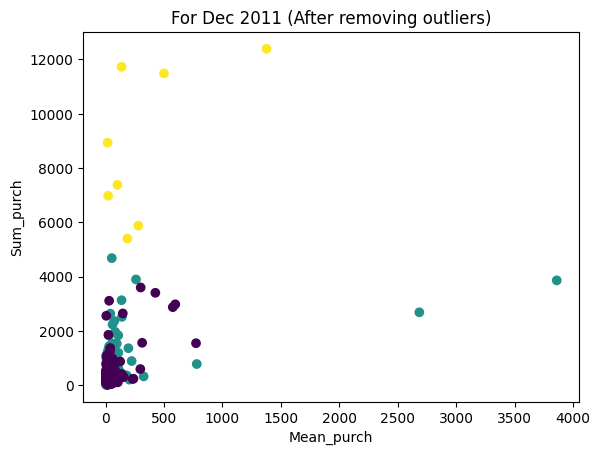

In [ ]:
plt.scatter(df_dec2011_new['Mean_purch'], df_dec2011_new['Sum_purch'], c=df_dec2011_new['cluster_labels'], cmap='viridis')
plt.title("For Dec 2011 (After removing outliers)")
plt.xlabel('Mean_purch')
plt.ylabel('Sum_purch')
plt.show()

In [ ]:
dec2011 = descrip_dict(og_dec2011,df_dec2011_new)
dec2011 = processlis(dec2011)

In [ ]:
dec2011

[     CustomerID                                        Description
 0             1  [CLASSIC CHROME BICYCLE BELL , BICYCLE PUNCTUR...
 1            11  [EDWARDIAN PARASOL RED, EDWARDIAN PARASOL NATU...
 2            15  [SET OF 4 KNICK KNACK TINS LONDON , SET OF 4 K...
 3            17  [BLUE POLKADOT WRAP, PINK POLKADOT WRAP , WRAP...
 4            19  [SET OF 6 3D KIT CARDS FOR KIDS, SLEEPING CAT ...
 ..          ...                                                ...
 315        2163  [HEART WOODEN CHRISTMAS DECORATION, IVORY WICK...
 316        2168  [CERAMIC STRAWBERRY DESIGN MUG, RED HEART SHAP...
 317        2177  [SWEETHEART WIRE MAGAZINE RACK, EDWARDIAN PARA...
 318        2183  [MIRRORED WALL ART SNOWFLAKES, MIRRORED WALL A...
 319        2212  [12 COLOURED PARTY BALLOONS, 6 ROCKET BALLOONS...
 
 [320 rows x 2 columns],
      CustomerID                                        Description
 0          2201  [3 DRAWER ANTIQUE WHITE WOOD CABINET, CREAM SW...
 1          2223  [IV

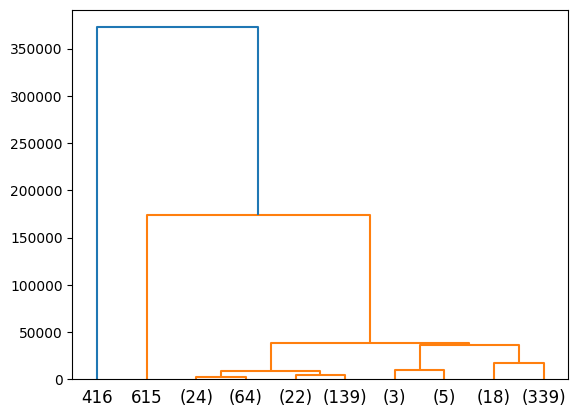

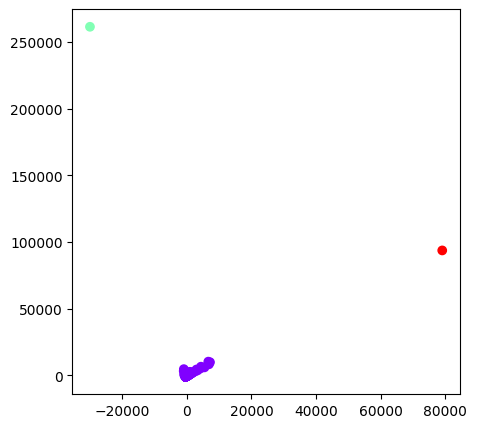

(614, 4)
(1, 4)
(1, 4)


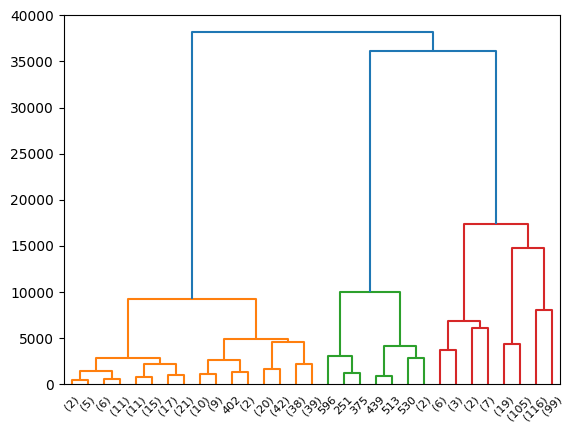

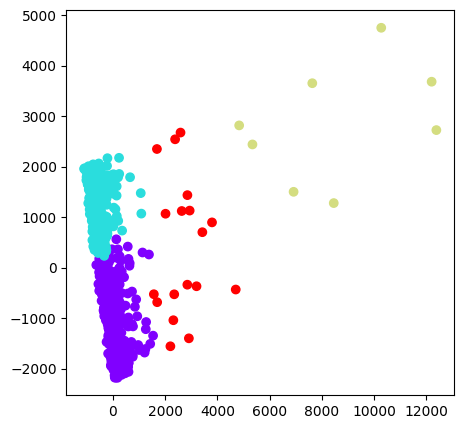

(339, 5)
(249, 5)
(8, 5)
(18, 5)


[     CustomerID                                        Description
 0             1  [CLASSIC CHROME BICYCLE BELL , BICYCLE PUNCTUR...
 1            11  [EDWARDIAN PARASOL RED, EDWARDIAN PARASOL NATU...
 2            15  [SET OF 4 KNICK KNACK TINS LONDON , SET OF 4 K...
 3            17  [BLUE POLKADOT WRAP, PINK POLKADOT WRAP , WRAP...
 4            19  [SET OF 6 3D KIT CARDS FOR KIDS, SLEEPING CAT ...
 ..          ...                                                ...
 334        2457  [GARDENERS KNEELING PAD KEEP CALM , BOX OF VIN...
 335        2459  [BUNNY WOODEN PAINTED WITH BIRD , EASTER DECOR...
 336        2462  [REGENCY CAKESTAND 3 TIER, ALARM CLOCK BAKELIK...
 337        2519  [JIGSAW RABBIT AND BIRDHOUSE, JIGSAW TREE WITH...
 338        2668  [SET OF 4 NAPKIN CHARMS LEAVES   , REX CASH+CA...
 
 [339 rows x 2 columns],
      CustomerID                                        Description
 0          2467  [MINI LIGHTS WOODLAND MUSHROOMS, DARK BIRD HOU...
 1          2504  [FL

In [ ]:

pca = PCA(n_components = 3)
pca.fit(X = dvt_dec2011)
new_dvt = pca.transform(dvt_dec2011)

new_dvt = pd.DataFrame(data = new_dvt,columns = ['X0','X1','X2'])
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage='ward').fit(new_dvt)

plot_dendrogram(model, truncate_mode="level", p=4)

dict_dec2011 =  Agglocls(new_dvt,3)

final_dvt_dec2011 = dict_dec2011[0]
pca_dec2011 = PCA(n_components = 3)
pca_dec2011.fit(X = final_dvt_dec2011)
final_dvt_dec2011 = pca_dec2011.transform(final_dvt_dec2011)
final_dvt_dec2011 = pd.DataFrame(data = final_dvt_dec2011,columns = ['X0','X1','X2'])
AggloDendo(final_dvt_dec2011)

dict_dec2011_final =  AggloPca(final_dvt_dec2011,4,dvt_dec2011,'X1','X0')

dec2011_agg = descrip_dict(og_dec2011,final_dvt_dec2011)
dec2011_agg = processlis(dec2011_agg)
dec2011_agg




In [ ]:
Cluster_dict['dec2011'] = (len(dec2011),len(dec2011_agg))
dicti_2011dec = {}
klis = []
for i in range(Cluster_dict['dec2011'][0]):
  temp = apriori_rules(dec2011[i],0.075)
  klis.append(temp)
alis = []
for i in range(Cluster_dict['dec2011'][1]):
  temp = apriori_rules(dec2011_agg[i],0.075)
  alis.append(temp)
#apriori_rules(1_agg[0],0.075)
dicti_2011dec['K-means'] = klis
dicti_2011dec['Agglo'] = alis

Rules_dict['dec2011'] = dicti_2011dec

# CLUSTERING ON THE BASIS OF DATAFRAMES SPLIT BY TIME-SLOTS


In [ ]:
time

['04:00-07:59', '08:00-11:59', '12:00-15:59', '16:00-19:59']

In [ ]:
def get_n_outlier_labels(dkf,n):

  #Returns a list of size n whose elements are the labels of outliers
  
  k = list(dkf['cluster_labels'].unique())
  values = list(dkf['cluster_labels'])
  l=[]
  for i in k:
    l.append(values.count(i))

  l = np.array(l)
  k = np.array(k)
  sorted_idx = np.argsort(l)
  sorted_l = l[sorted_idx]
  sorted_k = k[sorted_idx]
  op = list(sorted_k[:n])
  return(op) 

#We are finding only 1 outlier as after observation
#We find only 1

In [ ]:
def get_1_outliers(dkf):

  k = list(dkf['cluster_labels'].unique())
  values = list(dkf['cluster_labels'])
  l=[]

  for i in k:
    l.append(values.count(i))

  a = k[l.index(min(l))]
 
  return(a) 

## For Time: 4:00 - 07:59

In [ ]:
og_04_08 = df_list_time_intervals[0]
og_04_08

InvoiceNo StockCode                          Description  Quantity  \
0         536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1         536365     71053                  WHITE METAL LANTERN         6   
2         536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3         536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4         536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
...          ...       ...                                  ...       ...   
540384    581478     22791         T-LIGHT GLASS FLUTED ANTIQUE        12   
540385    581478     21326     AGED GLASS SILVER T-LIGHT HOLDER        12   
540386    581478     22170   PICTURE FRAME WOOD TRIPLE PORTRAIT         8   
540387    581478     23082    SET 6 PAPER TABLE LANTERN HEARTS          6   
540388    581478     22909  SET OF 20 VINTAGE CHRISTMAS NAPKINS        24   

        UnitPrice  CustomerID         Country  year-month_intervals  \
0            2.55        4017  United Kingdom                     0   
1            3.39        4017  United Kingdom                     0   
2            2.75        4017  United Kingdom                     0   
3            3.39        4017  United Kingdom                     0   
4            3.39        4017  United Kingdom                     0   
...           ...         ...             ...                   ...   
540384       1.25        3663  United Kingdom                    12   
540385       0.65        3663  United Kingdom                    12   
540386       6.75        3663  United Kingdom                    12   
540387       3.75        3663  United Kingdom                    12   
540388       0.85        3663  United Kingdom                    12   

        Total Price  Money_bins  
0             15.30           0  
1             20.34           0  
2             22.00           0  
3             20.34           0  
4             20.34           0  
...             ...         ...  
540384        15.00           0  
540385         7.80           0  
540386        54.00           0  
540387        22.50           0  
540388        20.40           0  

[9185 rows x 10 columns]

In [ ]:
dvt_04_08 = person_df(og_04_08 )        #Our function gives such a dataframe by which we can form clusters using KMeans
dvt_04_08 

No. of visits  Mean_purch  Sum_purch  Item_count  Total_quantity  \
0                1   26.586818     584.91          22             277   
1                1   29.175000      58.35           2               5   
2                2   22.826000     456.52          17             111   
3                1   22.506154     292.58          13              64   
4                1  148.566667     891.40           6             637   
..             ...         ...        ...         ...             ...   
442              1   20.523137    1046.68          51             872   
443              1   18.083333     108.50           6              64   
444              1   36.520000     109.56           3              36   
445              1   21.440000     214.40          10              92   
446             13   15.376228    1752.89         105             872   

      Avg_quant  CustomerID  
0     12.590909           1  
1      2.500000           9  
2      5.550000          31  
3      4.923077          32  
4    106.166667          38  
..          ...         ...  
442   17.098039        4303  
443   10.666667        4304  
444   12.000000        4308  
445    9.200000        4318  
446    7.649123        4339  

[447 rows x 7 columns]

In [ ]:
df_04_08 = df_cluster_labels(dvt_04_08,3)
df_04_08

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


No. of visits  Mean_purch  Sum_purch  Item_count  Total_quantity  \
0                1   26.586818     584.91          22             277   
1                1   29.175000      58.35           2               5   
2                2   22.826000     456.52          17             111   
3                1   22.506154     292.58          13              64   
4                1  148.566667     891.40           6             637   
..             ...         ...        ...         ...             ...   
442              1   20.523137    1046.68          51             872   
443              1   18.083333     108.50           6              64   
444              1   36.520000     109.56           3              36   
445              1   21.440000     214.40          10              92   
446             13   15.376228    1752.89         105             872   

      Avg_quant  CustomerID  cluster_labels  
0     12.590909           1               2  
1      2.500000           9               2  
2      5.550000          31               2  
3      4.923077          32               2  
4    106.166667          38               2  
..          ...         ...             ...  
442   17.098039        4303               0  
443   10.666667        4304               0  
444   12.000000        4308               0  
445    9.200000        4318               0  
446    7.649123        4339               0  

[447 rows x 8 columns]

In [ ]:
silhte_score_04_08 = silhouette_score(dvt_04_08, df_04_08['cluster_labels'])
print("The Silhouette Score is :- "+str(silhte_score_04_08))

The Silhouette Score is :- 0.5277500783997451


In [ ]:
df_04_08['cluster_labels'].value_counts()

2    234
0    207
1      6
Name: cluster_labels, dtype: int64

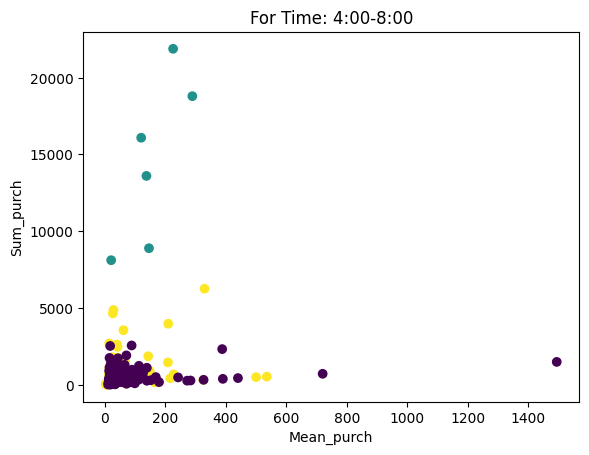

In [ ]:
plt.scatter(df_04_08['Mean_purch'], df_04_08['Sum_purch'], c=df_04_08['cluster_labels'], cmap='viridis')
plt.title("For Time: 4:00-8:00")
plt.xlabel('Mean_purch')
plt.ylabel('Sum_purch')
plt.show()

In [ ]:
#We apply this function ONLY if we find outliers
outlier_1_08_12 = get_1_outliers(df_04_08)
outlier_1_08_12

1

In [ ]:
#Thus Clusters 1 and 2 are outliers as they have very few datapoints(Customers)
#So we remove them and then applyKMeans again
#Thus
#Then check for outliers and if required, repeat the process
#Below is for outliers:-

df_04_08 = df_04_08[df_04_08['cluster_labels']!=outlier_1_08_12]
df_04_08

No. of visits  Mean_purch  Sum_purch  Item_count  Total_quantity  \
0                1   26.586818     584.91          22             277   
1                1   29.175000      58.35           2               5   
2                2   22.826000     456.52          17             111   
3                1   22.506154     292.58          13              64   
4                1  148.566667     891.40           6             637   
..             ...         ...        ...         ...             ...   
442              1   20.523137    1046.68          51             872   
443              1   18.083333     108.50           6              64   
444              1   36.520000     109.56           3              36   
445              1   21.440000     214.40          10              92   
446             13   15.376228    1752.89         105             872   

      Avg_quant  CustomerID  cluster_labels  
0     12.590909           1               2  
1      2.500000           9               2  
2      5.550000          31               2  
3      4.923077          32               2  
4    106.166667          38               2  
..          ...         ...             ...  
442   17.098039        4303               0  
443   10.666667        4304               0  
444   12.000000        4308               0  
445    9.200000        4318               0  
446    7.649123        4339               0  

[441 rows x 8 columns]

In [ ]:
df_04_08['cluster_labels'].value_counts()

2    234
0    207
Name: cluster_labels, dtype: int64

In [ ]:
#Thus the outliers are removed.
#Now we again apply the clustering pipeline

df_04_08_person = df_04_08.copy(deep=True)
df_04_08_person.drop(['cluster_labels'],axis=1,inplace=True)
df_04_08_person


No. of visits  Mean_purch  Sum_purch  Item_count  Total_quantity  \
0                1   26.586818     584.91          22             277   
1                1   29.175000      58.35           2               5   
2                2   22.826000     456.52          17             111   
3                1   22.506154     292.58          13              64   
4                1  148.566667     891.40           6             637   
..             ...         ...        ...         ...             ...   
442              1   20.523137    1046.68          51             872   
443              1   18.083333     108.50           6              64   
444              1   36.520000     109.56           3              36   
445              1   21.440000     214.40          10              92   
446             13   15.376228    1752.89         105             872   

      Avg_quant  CustomerID  
0     12.590909           1  
1      2.500000           9  
2      5.550000          31  
3      4.923077          32  
4    106.166667          38  
..          ...         ...  
442   17.098039        4303  
443   10.666667        4304  
444   12.000000        4308  
445    9.200000        4318  
446    7.649123        4339  

[441 rows x 7 columns]

In [ ]:
df_04_08_new = df_cluster_labels(df_04_08_person,3)
df_04_08_new


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


No. of visits  Mean_purch  Sum_purch  Item_count  Total_quantity  \
0                1   26.586818     584.91          22             277   
1                1   29.175000      58.35           2               5   
2                2   22.826000     456.52          17             111   
3                1   22.506154     292.58          13              64   
4                1  148.566667     891.40           6             637   
..             ...         ...        ...         ...             ...   
442              1   20.523137    1046.68          51             872   
443              1   18.083333     108.50           6              64   
444              1   36.520000     109.56           3              36   
445              1   21.440000     214.40          10              92   
446             13   15.376228    1752.89         105             872   

      Avg_quant  CustomerID  cluster_labels  
0     12.590909           1               0  
1      2.500000           9               0  
2      5.550000          31               0  
3      4.923077          32               0  
4    106.166667          38               0  
..          ...         ...             ...  
442   17.098039        4303               1  
443   10.666667        4304               1  
444   12.000000        4308               1  
445    9.200000        4318               1  
446    7.649123        4339               1  

[441 rows x 8 columns]

In [ ]:
silhte_score_04_08_new = silhouette_score(df_04_08_person, df_04_08_new['cluster_labels'])
print("The Silhouette Score is :- "+str(silhte_score_04_08_new))

The Silhouette Score is :- 0.5495940150285014


In [ ]:
df_04_08_new['cluster_labels'].value_counts()
#These are comparatively good clusters

0    242
1    191
2      8
Name: cluster_labels, dtype: int64

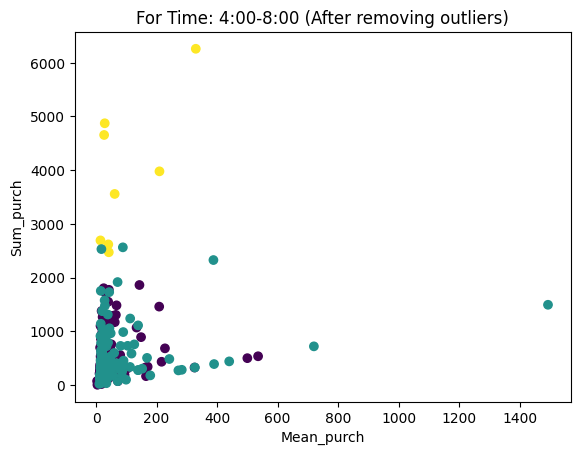

In [ ]:
plt.scatter(df_04_08_new['Mean_purch'], df_04_08_new['Sum_purch'], c=df_04_08_new['cluster_labels'], cmap='viridis')
plt.title("For Time: 4:00-8:00 (After removing outliers)")
plt.xlabel('Mean_purch')
plt.ylabel('Sum_purch')
plt.show()

In [ ]:
t_04_08 = descrip_dict(og_04_08,df_04_08_new)
t_04_08 = processlis(t_04_08)

In [ ]:
t_04_08

[     CustomerID                                        Description
 0             1  [SET OF 60 VINTAGE LEAF CAKE CASES , SET 40 HE...
 1             9  [REGENCY CAKESTAND 3 TIER, RED RETROSPOT CAKE ...
 2            31  [RETROSPOT PARTY BAG + STICKER SET, ORGANISER ...
 3            32  [TRADITIONAL WOODEN CATCH CUP GAME , RABBIT NI...
 4            38  [SET OF 3 REGENCY CAKE TINS, SET OF 12 MINI LO...
 ..          ...                                                ...
 237        2084  [ROSES REGENCY TEACUP AND SAUCER , CITRONELLA ...
 238        2086  [DOORMAT FANCY FONT HOME SWEET HOME, DOORMAT K...
 239        2087  [RED METAL BOX TOP SECRET, SET 6 PAPER TABLE L...
 240        2093  [MIRRORED WALL ART SNOWFLAKES, RED CHARLIE+LOL...
 241        2096                   [PINK REGENCY TEACUP AND SAUCER]
 
 [242 rows x 2 columns],
      CustomerID                                        Description
 0          2105  [JUMBO BAG STRAWBERRY, JUMBO BAG RED RETROSPOT...
 1          2109  [LU

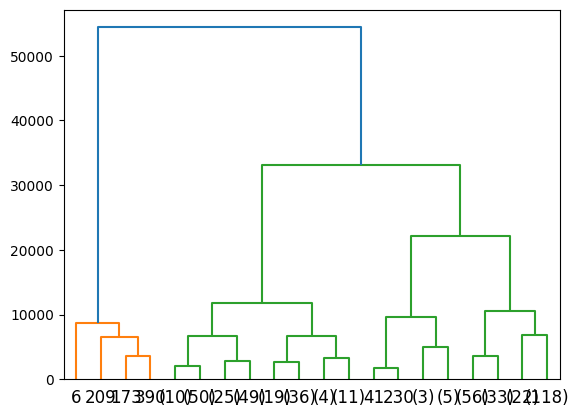

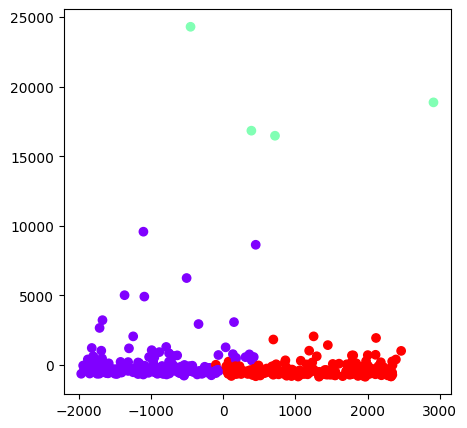

(239, 4)
(4, 4)
(204, 4)


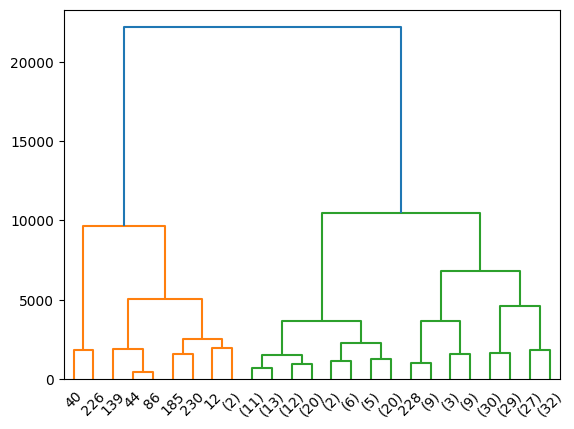

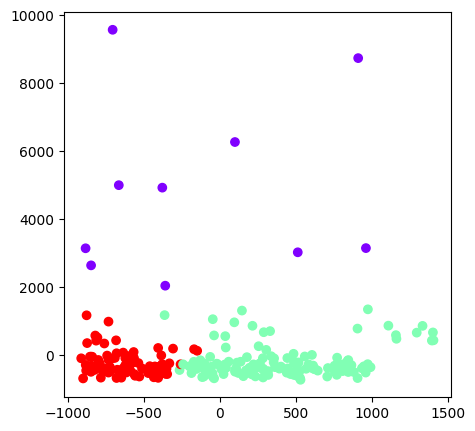

(10, 5)
(140, 5)
(89, 5)


[     CustomerID                                        Description
 0           559  [WOODEN BOX OF DOMINOES, RED  HARMONICA IN BOX...
 1           609  [WHITE TALL PORCELAIN T-LIGHT HOLDER, TWO DOOR...
 2           651  [JAM MAKING SET WITH JARS, SET OF 2 TEA TOWELS...
 3           671  [16 PIECE CUTLERY SET PANTRY DESIGN, SMALL PAR...
 4           712  [SET 6 PAPER TABLE LANTERN STARS , GARDENERS K...
 ..          ...                                                ...
 135        1904  [ZINC METAL HEART DECORATION, HANGING METAL HE...
 136        1984  [DOORMAT ENGLISH ROSE , SPACEBOY LUNCH BOX , G...
 137        1997  [RED RETROSPOT CAKE STAND, RETROSPOT LARGE MIL...
 138        2019  [I CAN ONLY PLEASE ONE PERSON MUG, HOMEMADE JA...
 139        2024  [VINTAGE CHRISTMAS TABLECLOTH, VINTAGE CHRISTM...
 
 [140 rows x 2 columns]]

In [ ]:

pca = PCA(n_components = 3)
pca.fit(X = dvt_04_08 )
new_dvt = pca.transform(dvt_04_08 )

new_dvt = pd.DataFrame(data = new_dvt,columns = ['X0','X1','X2'])
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage='ward').fit(new_dvt)

plot_dendrogram(model, truncate_mode="level", p=4)

dict_04_08 =  Agglocls(new_dvt,3)

final_dvt_04_08 = dict_04_08[0]
pca_04_08 = PCA(n_components = 3)
pca_04_08.fit(X = final_dvt_04_08)
final_dvt_04_08 = pca_04_08.transform(final_dvt_04_08)
final_dvt_04_08 = pd.DataFrame(data = final_dvt_04_08,columns = ['X0','X1','X2'])
AggloDendo(final_dvt_04_08)

dict_04_08_final =  AggloPca(final_dvt_04_08,3,dvt_04_08,'X1','X0')

t_04_08_agg = descrip_dict(og_04_08,final_dvt_04_08)
t_04_08_agg = processlis(t_04_08_agg)
t_04_08_agg




In [ ]:
Cluster_dict['t_04_08'] = (len(t_04_08),len(t_04_08_agg))
dicti_t_04_08 = {}
klis = []

for i in range(Cluster_dict['t_04_08'][0]):
  temp = apriori_rules(t_04_08[i],0.075)
  klis.append(temp)
alis = []

for i in range(Cluster_dict['t_04_08'][1]):
  temp = apriori_rules(t_04_08_agg[i],0.075)
  alis.append(temp)

dicti_t_04_08['K-means'] = klis
dicti_t_04_08['Agglo'] = alis

Rules_dict['t_04_08'] = dicti_t_04_08

## For Time: 8:00 - 12:00

In [ ]:
og_08_12 = df_list_time_intervals[1]
og_08_12

InvoiceNo StockCode                         Description  Quantity  \
46        536371     22086     PAPER CHAIN KIT 50'S CHRISTMAS         80   
47        536372     22632           HAND WARMER RED POLKA DOT         6   
48        536372     22633              HAND WARMER UNION JACK         6   
49        536373    85123A  WHITE HANGING HEART T-LIGHT HOLDER         6   
50        536373     71053                 WHITE METAL LANTERN         6   
...          ...       ...                                 ...       ...   
541904    581587     22613         PACK OF 20 SPACEBOY NAPKINS        12   
541905    581587     22899        CHILDREN'S APRON DOLLY GIRL          6   
541906    581587     23254       CHILDRENS CUTLERY DOLLY GIRL          4   
541907    581587     23255     CHILDRENS CUTLERY CIRCUS PARADE         4   
541908    581587     22138       BAKING SET 9 PIECE RETROSPOT          3   

        UnitPrice  CustomerID         Country  year-month_intervals  \
46           2.55        1039  United Kingdom                     0   
47           1.85        4017  United Kingdom                     0   
48           1.85        4017  United Kingdom                     0   
49           2.55        4017  United Kingdom                     0   
50           3.39        4017  United Kingdom                     0   
...           ...         ...             ...                   ...   
541904       0.85         271          France                    12   
541905       2.10         271          France                    12   
541906       4.15         271          France                    12   
541907       4.15         271          France                    12   
541908       4.95         271          France                    12   

        Total Price  Money_bins  
46           204.00           0  
47            11.10           0  
48            11.10           0  
49            15.30           0  
50            20.34           0  
...             ...         ...  
541904        10.20           0  
541905        12.60           0  
541906        16.60           0  
541907        16.60           0  
541908        14.85           0  

[215190 rows x 10 columns]

In [ ]:
dvt_08_12= person_df(og_08_12)                  #Our function gives such a dataframe by which we can form clusters using KMeans
dvt_08_12

No. of visits    Mean_purch  Sum_purch  Item_count  Total_quantity  \
0                 1  77183.600000   77183.60           1           74215   
1                 2     27.191127    1930.57          60            1159   
2                 2     54.040000     594.44          10             870   
3                 1     24.076027    1757.55          73             631   
4                 1     19.766667     296.50          15              98   
...             ...           ...        ...         ...             ...   
3021              1     11.545714      80.82           7              54   
3022              1     15.568000      77.84           5              28   
3023              6      3.532794     872.60         123             544   
3024              3     26.246857    1837.28          59            1586   
3025            738     15.674095  534282.87        3018          141032   

         Avg_quant  CustomerID  
0     74215.000000           0  
1        16.323944           1  
2        79.090909           2  
3         8.643836           3  
4         6.533333           5  
...            ...         ...  
3021      7.714286        4335  
3022      5.600000        4336  
3023      2.202429        4337  
3024     22.657143        4338  
3025      4.137413        4339  

[3026 rows x 7 columns]

In [ ]:
df_08_12 = df_cluster_labels(dvt_08_12,3)
df_08_12

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


No. of visits    Mean_purch  Sum_purch  Item_count  Total_quantity  \
0                 1  77183.600000   77183.60           1           74215   
1                 2     27.191127    1930.57          60            1159   
2                 2     54.040000     594.44          10             870   
3                 1     24.076027    1757.55          73             631   
4                 1     19.766667     296.50          15              98   
...             ...           ...        ...         ...             ...   
3021              1     11.545714      80.82           7              54   
3022              1     15.568000      77.84           5              28   
3023              6      3.532794     872.60         123             544   
3024              3     26.246857    1837.28          59            1586   
3025            738     15.674095  534282.87        3018          141032   

         Avg_quant  CustomerID  cluster_labels  
0     74215.000000           0               2  
1        16.323944           1               0  
2        79.090909           2               0  
3         8.643836           3               0  
4         6.533333           5               0  
...            ...         ...             ...  
3021      7.714286        4335               0  
3022      5.600000        4336               0  
3023      2.202429        4337               0  
3024     22.657143        4338               0  
3025      4.137413        4339               1  

[3026 rows x 8 columns]

In [ ]:
silhte_score_08_12 = silhouette_score(dvt_08_12, df_08_12['cluster_labels'])
print("The Silhouette Score is :- "+str(silhte_score_08_12))

The Silhouette Score is :- 0.9702524284242895


In [ ]:
df_08_12['cluster_labels'].value_counts()

0    3013
2      12
1       1
Name: cluster_labels, dtype: int64

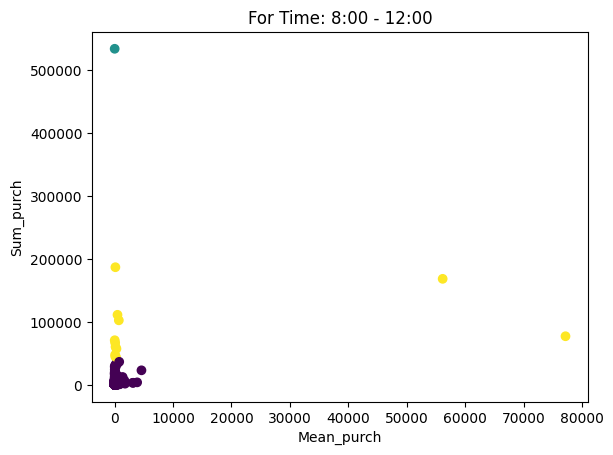

In [ ]:
plt.scatter(df_08_12['Mean_purch'], df_08_12['Sum_purch'], c=df_08_12['cluster_labels'], cmap='viridis')
plt.title("For Time: 8:00 - 12:00")
plt.xlabel('Mean_purch')
plt.ylabel('Sum_purch')
plt.show()


In [ ]:
# #We apply this function ONLY if we find outliers

outliers_08_12  = get_n_outlier_labels(df_08_12,2)
outliers_08_12

[1, 2]

In [ ]:
#Thus Clusters 1 and 2 are outliers as they have very few datapoints(Customers)
#So we remove them and then applyKMeans again
#Thus
#Then check for outliers and if required, repeat the process
#Below is for outliers:-

df_08_12 = df_08_12[df_08_12['cluster_labels']!=outliers_08_12[0]]
df_08_12 = df_08_12[df_08_12['cluster_labels']!=outliers_08_12[1]]
df_08_12


No. of visits  Mean_purch  Sum_purch  Item_count  Total_quantity  \
1                 2   27.191127    1930.57          60            1159   
2                 2   54.040000     594.44          10             870   
3                 1   24.076027    1757.55          73             631   
4                 1   19.766667     296.50          15              98   
5                 2   48.299649    2753.08          53            1586   
...             ...         ...        ...         ...             ...   
3020              1   18.060000     180.60          10              45   
3021              1   11.545714      80.82           7              54   
3022              1   15.568000      77.84           5              28   
3023              6    3.532794     872.60         123             544   
3024              3   26.246857    1837.28          59            1586   

      Avg_quant  CustomerID  cluster_labels  
1     16.323944           1               0  
2     79.090909           2               0  
3      8.643836           3               0  
4      6.533333           5               0  
5     27.824561           9               0  
...         ...         ...             ...  
3020   4.500000        4334               0  
3021   7.714286        4335               0  
3022   5.600000        4336               0  
3023   2.202429        4337               0  
3024  22.657143        4338               0  

[3013 rows x 8 columns]

In [ ]:
df_08_12['cluster_labels'].value_counts()

0    3013
Name: cluster_labels, dtype: int64

In [ ]:
#Thus the outliers are removed.
#Now we again apply the clustering pipeline

df_08_12_person = df_08_12.copy(deep=True)
df_08_12_person.drop(['cluster_labels'],axis=1,inplace=True)

df_08_12_new = df_cluster_labels(df_08_12_person,3)
df_08_12_new

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


No. of visits  Mean_purch  Sum_purch  Item_count  Total_quantity  \
1                 2   27.191127    1930.57          60            1159   
2                 2   54.040000     594.44          10             870   
3                 1   24.076027    1757.55          73             631   
4                 1   19.766667     296.50          15              98   
5                 2   48.299649    2753.08          53            1586   
...             ...         ...        ...         ...             ...   
3020              1   18.060000     180.60          10              45   
3021              1   11.545714      80.82           7              54   
3022              1   15.568000      77.84           5              28   
3023              6    3.532794     872.60         123             544   
3024              3   26.246857    1837.28          59            1586   

      Avg_quant  CustomerID  cluster_labels  
1     16.323944           1               0  
2     79.090909           2               0  
3      8.643836           3               0  
4      6.533333           5               0  
5     27.824561           9               2  
...         ...         ...             ...  
3020   4.500000        4334               0  
3021   7.714286        4335               0  
3022   5.600000        4336               0  
3023   2.202429        4337               0  
3024  22.657143        4338               0  

[3013 rows x 8 columns]

In [ ]:
silhte_score_08_12_new = silhouette_score(df_08_12_person, df_08_12_new['cluster_labels'])
print("The Silhouette Score is :- "+str(silhte_score_08_12_new))
#Indicates that silhouette score is realistic for dataset without outliers

The Silhouette Score is :- 0.6168069024017672


In [ ]:
df_08_12_new['cluster_labels'].value_counts()
#These are comparatively good clusters

0    2733
2     257
1      23
Name: cluster_labels, dtype: int64

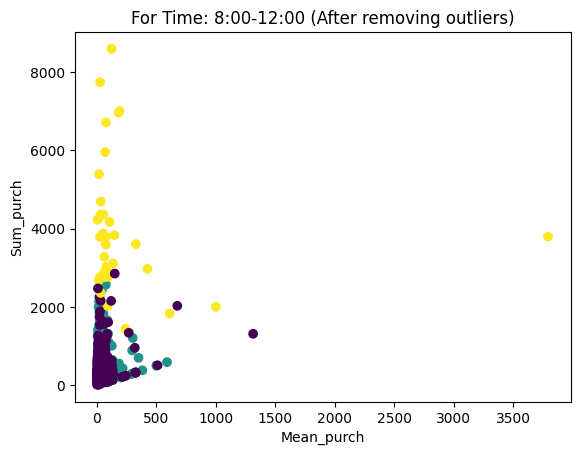

In [ ]:
plt.scatter(df_dec2010_new['Mean_purch'], df_dec2010_new['Sum_purch'], c=df_dec2010_new['cluster_labels'], cmap='viridis')
plt.title("For Time: 8:00-12:00 (After removing outliers)")
plt.xlabel('Mean_purch')
plt.ylabel('Sum_purch')
plt.show()

In [ ]:
t_08_12 = descrip_dict(og_08_12,df_08_12_new)
t_08_12 = processlis(t_08_12)
t_08_12

[      CustomerID                                        Description
 0              1  [AIRLINE BAG VINTAGE JET SET WHITE, AIRLINE BA...
 1              2  [PACK OF 12 RED RETROSPOT TISSUES , PACK OF 12...
 2              3  [PARISIENNE CURIO CABINET, SWEETHEART WALL TID...
 3              5  [WOODEN HAPPY BIRTHDAY GARLAND, PINK DOUGHNUT ...
 4             11  [FAIRY CAKE DESIGN UMBRELLA, CERAMIC STRAWBERR...
 ...          ...                                                ...
 2728        4334  [WOOD BLACK BOARD ANT WHITE FINISH, RETROSPOT ...
 2729        4335  [ROBOT BIRTHDAY CARD, CARD CIRCUS PARADE, PENN...
 2730        4336  [REGENCY CAKESTAND 3 TIER, ROSES REGENCY TEACU...
 2731        4337  [CREAM FELT EASTER EGG BASKET, BLUE FELT EASTE...
 2732        4338  [SMALL PURPLE BABUSHKA NOTEBOOK , SMALL RED BA...
 
 [2733 rows x 2 columns],
      CustomerID                                        Description
 0             9  [BAKING SET 9 PIECE RETROSPOT , WHITE HEART CO...
 1      

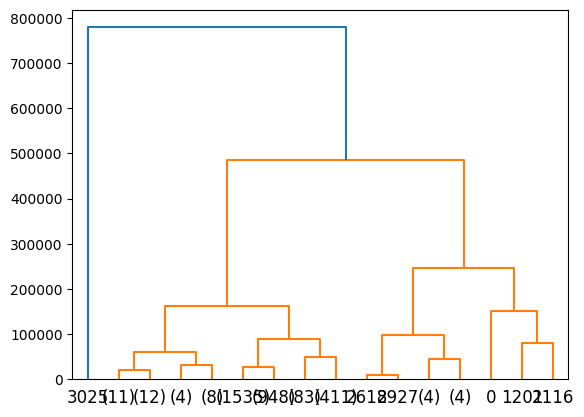

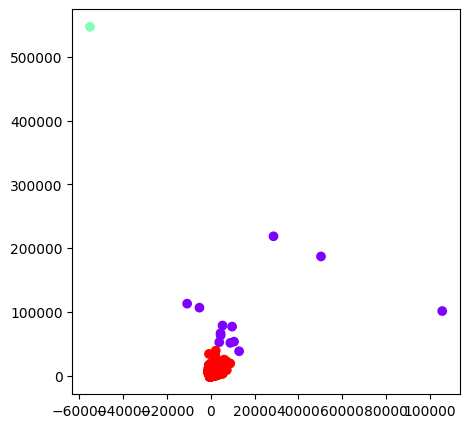

(13, 4)
(1, 4)
(3012, 4)


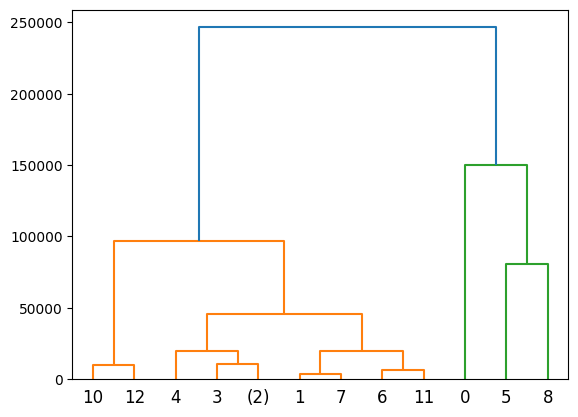

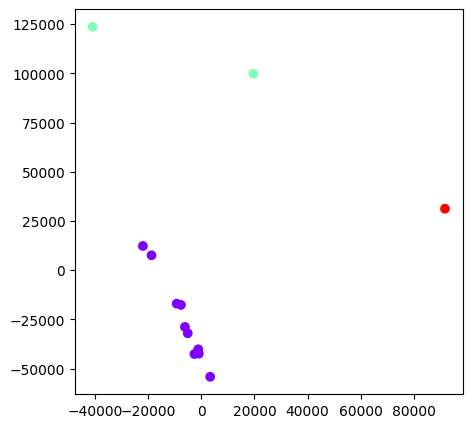

(10, 5)
(2, 5)
(1, 5)


[]

In [ ]:
pca = PCA(n_components = 3)
pca.fit(X = dvt_08_12 )
new_dvt = pca.transform(dvt_08_12 )

new_dvt = pd.DataFrame(data = new_dvt,columns = ['X0','X1','X2'])
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage='ward').fit(new_dvt)

plot_dendrogram(model, truncate_mode="level", p=4)

dict_08_12 =  Agglocls(new_dvt,3)

final_dvt_08_12 = dict_08_12[0]
pca_08_12 = PCA(n_components = 3)
pca_08_12.fit(X = final_dvt_08_12)
final_dvt_08_12 = pca_08_12.transform(final_dvt_08_12)
final_dvt_08_12 = pd.DataFrame(data = final_dvt_08_12,columns = ['X0','X1','X2'])
AggloDendo(final_dvt_08_12)

dict_08_12_final =  AggloPca(final_dvt_08_12,3,dvt_08_12,'X1','X0')

t_08_12_agg = descrip_dict(og_08_12,final_dvt_08_12)
t_08_12_agg = processlis(t_08_12_agg)
t_08_12_agg


In [ ]:
Cluster_dict['t_08_12'] = (len(t_08_12),len(t_08_12_agg))
dicti_t_08_12 = {}
klis = []
for i in range(Cluster_dict['t_08_12'][0]):
  temp = apriori_rules(t_08_12[i],0.075)
  klis.append(temp)
alis = []
for i in range(Cluster_dict['t_08_12'][1]):
  temp = apriori_rules(t_08_12_agg[i],0.075)
  alis.append(temp)
#apriori_rules(1_agg[0],0.075)
dicti_t_08_12['K-means'] = klis
dicti_t_08_12['Agglo'] = alis

Rules_dict['t_08_12'] = dicti_t_08_12

In [ ]:
#similar to october case we have very low number of customers which makes this case analysis non-usefull and very biased 

## For Time: 12:00 - 16:00

In [ ]:
og_12_16 = df_list_time_intervals[2]
og_12_16

InvoiceNo StockCode                          Description  Quantity  \
1109      536527     22809              SET OF 6 T-LIGHTS SANTA         6   
1110      536527     84347  ROTATING SILVER ANGELS T-LIGHT HLDR         6   
1111      536527     84945   MULTI COLOUR SILVER T-LIGHT HOLDER        12   
1112      536527     22242        5 HOOK HANGER MAGIC TOADSTOOL        12   
1113      536527     22244           3 HOOK HANGER MAGIC GARDEN        12   
...          ...       ...                                  ...       ...   
539860    581443     22756      LARGE YELLOW BABUSHKA NOTEBOOK         12   
539861    581443     22758     LARGE PURPLE BABUSHKA NOTEBOOK          12   
539862    581443    72800E  4 IVORY DINNER CANDLES SILVER FLOCK        36   
539863    581443     90086             CRYSTAL FROG PHONE CHARM        48   
539864    581443     90087        CRYSTAL SEA HORSE PHONE CHARM        48   

        UnitPrice  CustomerID         Country  year-month_intervals  \
1109         2.95         258         Germany                     0   
1110         2.55         258         Germany                     0   
1111         0.85         258         Germany                     0   
1112         1.65         258         Germany                     0   
1113         1.95         258         Germany                     0   
...           ...         ...             ...                   ...   
539860       0.39         518  United Kingdom                    12   
539861       0.39         518  United Kingdom                    12   
539862       0.79         518  United Kingdom                    12   
539863       0.19         518  United Kingdom                    12   
539864       0.19         518  United Kingdom                    12   

        Total Price  Money_bins  
1109          17.70           0  
1110          15.30           0  
1111          10.20           0  
1112          19.80           0  
1113          23.40           0  
...             ...         ...  
539860         4.68           0  
539861         4.68           0  
539862        28.44           0  
539863         9.12           0  
539864         9.12           0  

[267226 rows x 10 columns]

In [ ]:
dvt_12_16 = person_df(og_12_16)                  #Our function gives such a dataframe by which we can form clusters using KMeans
df_12_16 = df_cluster_labels(dvt_12_16,3)
df_12_16

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


No. of visits  Mean_purch  Sum_purch  Item_count  Total_quantity  \
0                 4   20.163146    1794.52          68            1022   
1                 1  103.333333     310.00           3             217   
2                 1   19.670588     334.40          17             197   
3                 7   31.564857    2209.54          50             438   
4                 1   18.610345    1079.40          58             530   
...             ...         ...        ...         ...             ...   
3068              1   51.000000      51.00           1              20   
3069              1   13.797500     110.38           8              68   
3070              1   14.315714     100.21           7              75   
3071              9    2.413436    1018.47         213             696   
3072           1205   11.663274  928431.62        3362          259002   

      Avg_quant  CustomerID  cluster_labels  
0     11.483146           1               0  
1     72.333333           2               0  
2     11.588235           4               0  
3      6.257143           5               0  
4      9.137931           7               0  
...         ...         ...             ...  
3068  20.000000        4329               0  
3069   8.500000        4332               0  
3070  10.714286        4336               0  
3071   1.649289        4337               0  
3072   3.253671        4339               1  

[3073 rows x 8 columns]

In [ ]:
silhte_score_12_16 = silhouette_score(dvt_12_16, df_12_16['cluster_labels'])
print("The Silhouette Score is :- "+str(silhte_score_12_16))

The Silhouette Score is :- 0.9361237581460591


In [ ]:
df_12_16['cluster_labels'].value_counts()

0    3049
2      23
1       1
Name: cluster_labels, dtype: int64

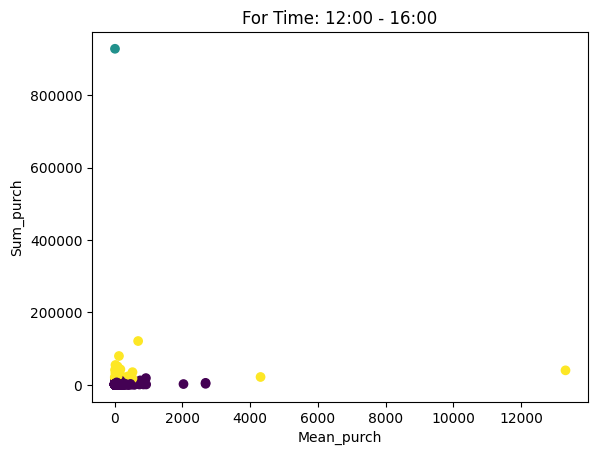

In [ ]:
plt.scatter(df_12_16['Mean_purch'], df_12_16['Sum_purch'], c=df_12_16['cluster_labels'], cmap='viridis')
plt.title("For Time: 12:00 - 16:00")
plt.xlabel('Mean_purch')
plt.ylabel('Sum_purch')
plt.show()

In [ ]:
#Thus Clusters 1 and 2 are outliers as they have very few datapoints(Customers)
#So we remove them and then applyKMeans again
#Thus
#Then check for outliers and if required, repeat the process
#Below is for outliers:-
outliers_12_16 = get_n_outlier_labels(df_12_16,2)
outliers_12_16

[1, 2]

In [ ]:
df_12_16 = df_12_16[df_12_16['cluster_labels']!=outliers_12_16[0]]
df_12_16 = df_12_16[df_12_16['cluster_labels']!=outliers_12_16[1]]
df_12_16

No. of visits  Mean_purch  Sum_purch  Item_count  Total_quantity  \
0                 4   20.163146    1794.52          68            1022   
1                 1  103.333333     310.00           3             217   
2                 1   19.670588     334.40          17             197   
3                 7   31.564857    2209.54          50             438   
4                 1   18.610345    1079.40          58             530   
...             ...         ...        ...         ...             ...   
3067              1   20.369189     753.66          37             392   
3068              1   51.000000      51.00           1              20   
3069              1   13.797500     110.38           8              68   
3070              1   14.315714     100.21           7              75   
3071              9    2.413436    1018.47         213             696   

      Avg_quant  CustomerID  cluster_labels  
0     11.483146           1               0  
1     72.333333           2               0  
2     11.588235           4               0  
3      6.257143           5               0  
4      9.137931           7               0  
...         ...         ...             ...  
3067  10.594595        4328               0  
3068  20.000000        4329               0  
3069   8.500000        4332               0  
3070  10.714286        4336               0  
3071   1.649289        4337               0  

[3049 rows x 8 columns]

In [ ]:
#Thus the outliers are removed.
#Now we again apply the clustering pipeline

df_12_16_person = df_12_16.copy(deep=True)
df_12_16_person.drop(['cluster_labels'],axis=1,inplace=True)

df_12_16_new = df_cluster_labels(df_12_16_person,3)
df_12_16_new

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


No. of visits  Mean_purch  Sum_purch  Item_count  Total_quantity  \
0                 4   20.163146    1794.52          68            1022   
1                 1  103.333333     310.00           3             217   
2                 1   19.670588     334.40          17             197   
3                 7   31.564857    2209.54          50             438   
4                 1   18.610345    1079.40          58             530   
...             ...         ...        ...         ...             ...   
3067              1   20.369189     753.66          37             392   
3068              1   51.000000      51.00           1              20   
3069              1   13.797500     110.38           8              68   
3070              1   14.315714     100.21           7              75   
3071              9    2.413436    1018.47         213             696   

      Avg_quant  CustomerID  cluster_labels  
0     11.483146           1               1  
1     72.333333           2               1  
2     11.588235           4               1  
3      6.257143           5               1  
4      9.137931           7               1  
...         ...         ...             ...  
3067  10.594595        4328               0  
3068  20.000000        4329               0  
3069   8.500000        4332               0  
3070  10.714286        4336               0  
3071   1.649289        4337               0  

[3049 rows x 8 columns]

In [ ]:
silhte_score_12_16_new = silhouette_score(df_12_16_person, df_12_16_new['cluster_labels'])
print("The Silhouette Score is :- "+str(silhte_score_12_16_new))
#Indicates that silhouette score is realistic for dataset without outliers

The Silhouette Score is :- 0.46062699197294626


In [ ]:
df_12_16_new['cluster_labels'].value_counts()
#These are comparatively good clusters

0    1490
1    1427
2     132
Name: cluster_labels, dtype: int64

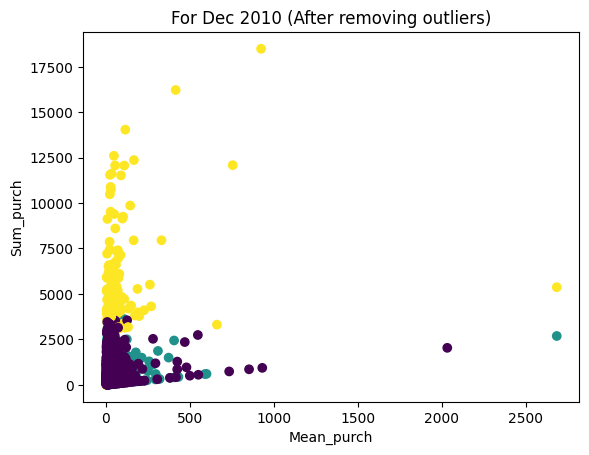

In [ ]:
plt.scatter(df_12_16_new['Mean_purch'], df_12_16_new['Sum_purch'], c=df_12_16_new['cluster_labels'], cmap='viridis')
plt.title("For Dec 2010 (After removing outliers)")
plt.xlabel('Mean_purch')
plt.ylabel('Sum_purch')
plt.show()

In [ ]:
t_12_16 = descrip_dict(og_12_16,df_12_16_new)
t_12_16 = processlis(t_12_16)
t_12_16

[      CustomerID                                        Description
 0              1  [BLACK CANDELABRA T-LIGHT HOLDER, AIRLINE BAG ...
 1              2  [DOUGHNUT LIP GLOSS , ICE CREAM PEN LIP GLOSS ...
 2              4  [CHOCOLATE THIS WAY METAL SIGN, METAL SIGN NEI...
 3              5  [POSTAGE, DELUXE SEWING KIT , PINK HEART SHAPE...
 4              7  [JUMBO BAG ALPHABET, CHARLOTTE BAG APPLES DESI...
 ...          ...                                                ...
 1422        2168  [GINGERBREAD MAN COOKIE CUTTER, SET 10 LIGHTS ...
 1423        2171  [RED RETROSPOT PICNIC BAG, BLUE POLKADOT BOWL,...
 1424        2211  [12 PENCILS TALL TUBE RED RETROSPOT, CHARLIE A...
 1425        2212  [TEA PARTY BIRTHDAY CARD, FAIRY CAKES NOTEBOOK...
 1426        2222  [EGG FRYING PAN IVORY , SET OF 6 TEA TIME BAKI...
 
 [1427 rows x 2 columns],
      CustomerID                                        Description
 0            10  [PINK DOUGHNUT TRINKET POT , STRAWBERRY CERAMI...
 1      

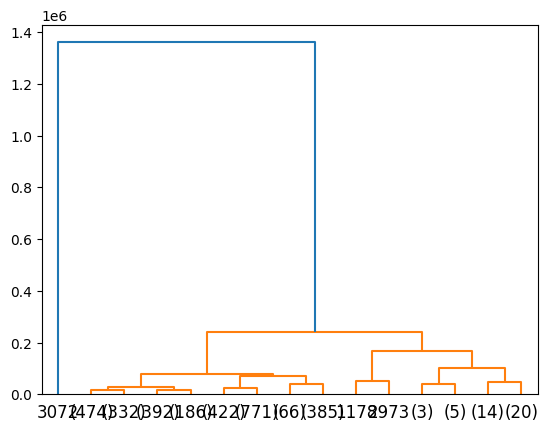

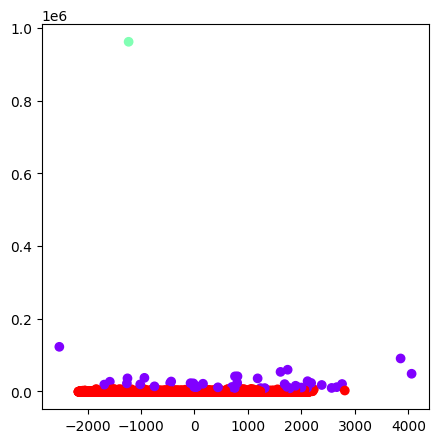

(44, 4)
(1, 4)
(3028, 4)


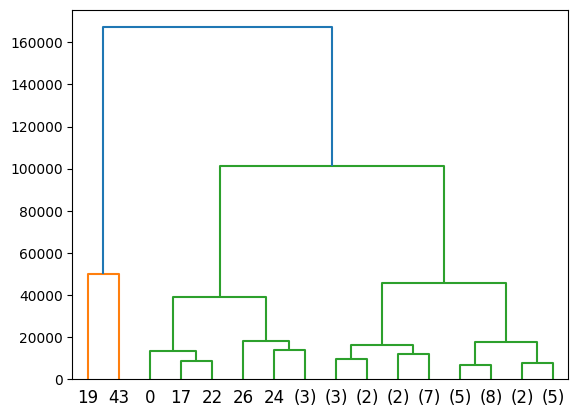

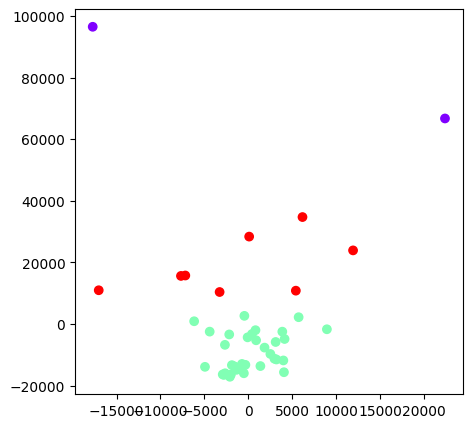

(2, 5)
(34, 5)
(8, 5)


[]

In [ ]:
pca = PCA(n_components = 3)
pca.fit(X = dvt_12_16 )
new_dvt = pca.transform(dvt_12_16 )

new_dvt = pd.DataFrame(data = new_dvt,columns = ['X0','X1','X2'])
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage='ward').fit(new_dvt)

plot_dendrogram(model, truncate_mode="level", p=4)

dict_12_16 =  Agglocls(new_dvt,3)

final_dvt_12_16 = dict_12_16[0]
pca_12_16 = PCA(n_components = 3)
pca_12_16.fit(X = final_dvt_12_16)
final_dvt_12_16 = pca_12_16.transform(final_dvt_12_16)
final_dvt_12_16 = pd.DataFrame(data = final_dvt_12_16,columns = ['X0','X1','X2'])
AggloDendo(final_dvt_12_16)

dict_12_16_final =  AggloPca(final_dvt_12_16,3,dvt_12_16,'X1','X0')

t_12_16_agg = descrip_dict(og_12_16,final_dvt_12_16)
t_12_16_agg = processlis(t_12_16_agg)
t_12_16_agg


In [ ]:
#similar to october case we have very low number of customers which makes this case analysis non-usefull and very biased 

In [ ]:
Cluster_dict['t_12_16'] = (len(t_12_16),len(t_12_16_agg))
dicti_t_12_16 = {}
klis = []
for i in range(Cluster_dict['t_12_16'][0]):
  temp = apriori_rules(t_12_16[i],0.075)
  klis.append(temp)
alis = []
for i in range(Cluster_dict['t_12_16'][1]):
  temp = apriori_rules(t_12_16_agg[i],0.075)
  alis.append(temp)
#apriori_rules(1_agg[0],0.075)
dicti_t_12_16['K-means'] = klis
dicti_t_12_16['Agglo'] = alis

Rules_dict['t_12_16'] = dicti_t_12_16

## For Time: 16:00 - 20:00

In [ ]:
og_16_20 = df_list_time_intervals[3]
og_16_20

InvoiceNo StockCode                     Description  Quantity  \
2461      536592     10135    COLOURING PENCILS BROWN TUBE         1   
2462      536592    16168M    FUNKY MONKEY GIFT BAG MEDIUM         2   
2463      536592     16236            KITTY PENCIL ERASERS         1   
2464      536592     16237            SLEEPING CAT ERASERS         6   
2465      536592     16238       PARTY TIME PENCIL ERASERS         5   
...          ...       ...                             ...       ...   
540272    581474     21253  SET OF PICTURE FRAME  STICKERS         1   
540273    581474     22108           PING! MICROWAVE PLATE         1   
540274    581474     22167      OVAL WALL MIRROR DIAMANTE          1   
540275    581474     21929  JUMBO BAG PINK VINTAGE PAISLEY         1   
540276    581474     20717          STRAWBERRY SHOPPER BAG         1   

        UnitPrice  CustomerID         Country  year-month_intervals  \
2461         2.51        4339  United Kingdom                     0   
2462         0.85        4339  United Kingdom                     0   
2463         0.43        4339  United Kingdom                     0   
2464         0.43        4339  United Kingdom                     0   
2465         0.43        4339  United Kingdom                     0   
...           ...         ...             ...                   ...   
540272       0.79         326  United Kingdom                    12   
540273       1.25         326  United Kingdom                    12   
540274       9.95         326  United Kingdom                    12   
540275       2.08         326  United Kingdom                    12   
540276       1.25         326  United Kingdom                    12   

        Total Price  Money_bins  
2461           2.51           0  
2462           1.70           0  
2463           0.43           0  
2464           2.58           0  
2465           2.15           0  
...             ...         ...  
540272         0.79           0  
540273         1.25           0  
540274         9.95           0  
540275         2.08           0  
540276         1.25           0  

[39682 rows x 10 columns]

In [ ]:
dvt_16_20= person_df(og_16_20)                      #Our function gives such a dataframe by which we can form clusters using KMeans

df_16_20 = df_cluster_labels(dvt_16_20,3)
df_16_20

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


No. of visits  Mean_purch  Sum_purch  Item_count  Total_quantity  \
0                1   52.517647     892.80          13            1254   
1                1   22.250000      89.00           4              20   
2                1   22.357500     626.01          28             290   
3                1   32.036607    1794.05          56            1025   
4                1   16.931429     355.56          21             190   
..             ...         ...        ...         ...             ...   
590              1   25.500000      25.50           1               2   
591              1   15.487273     340.72          22             276   
592              1   15.992727     175.92          11              88   
593              1    2.342644     203.81          68             157   
594            236   13.738566  268685.14        2759           78379   

     Avg_quant  CustomerID  cluster_labels  
0    73.764706           2               0  
1     5.000000           6               0  
2    10.357143          29               0  
3    18.303571          47               0  
4     9.047619          56               0  
..         ...         ...             ...  
590   2.000000        4325               0  
591  12.545455        4328               0  
592   8.000000        4330               0  
593   1.804598        4337               0  
594   4.007721        4339               1  

[595 rows x 8 columns]

In [ ]:
silhte_score_16_20 = silhouette_score(dvt_16_20, df_16_20['cluster_labels'])
print("The Silhouette Score is :- "+str(silhte_score_16_20))

The Silhouette Score is :- 0.9225816759992612


In [ ]:
df_16_20['cluster_labels'].value_counts()

0    590
2      4
1      1
Name: cluster_labels, dtype: int64

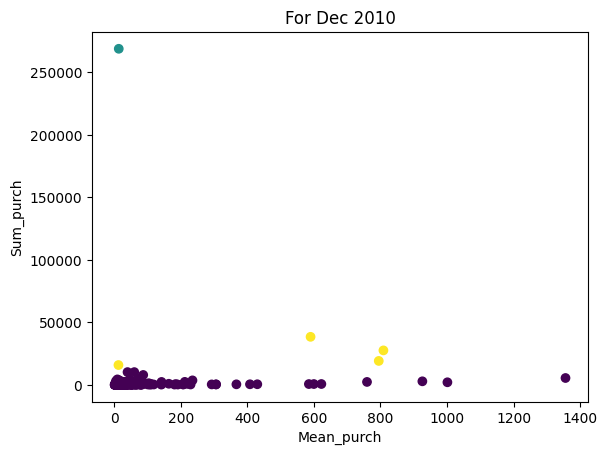

In [ ]:
plt.scatter(df_16_20['Mean_purch'], df_16_20['Sum_purch'], c=df_16_20['cluster_labels'], cmap='viridis')
plt.title("For Dec 2010")
plt.xlabel('Mean_purch')
plt.ylabel('Sum_purch')
plt.show()

In [ ]:
outliers_16_20 = get_n_outlier_labels(df_16_20,2)
print(outliers_16_20)

[1, 2]


In [ ]:
df_16_20 = df_16_20[df_16_20['cluster_labels']!=outliers_16_20[0]]
df_16_20 = df_16_20[df_16_20['cluster_labels']!=outliers_16_20[1]]
df_16_20

No. of visits  Mean_purch  Sum_purch  Item_count  Total_quantity  \
0                1   52.517647     892.80          13            1254   
1                1   22.250000      89.00           4              20   
2                1   22.357500     626.01          28             290   
3                1   32.036607    1794.05          56            1025   
4                1   16.931429     355.56          21             190   
..             ...         ...        ...         ...             ...   
589              1   20.972727     230.70          11              58   
590              1   25.500000      25.50           1               2   
591              1   15.487273     340.72          22             276   
592              1   15.992727     175.92          11              88   
593              1    2.342644     203.81          68             157   

     Avg_quant  CustomerID  cluster_labels  
0    73.764706           2               0  
1     5.000000           6               0  
2    10.357143          29               0  
3    18.303571          47               0  
4     9.047619          56               0  
..         ...         ...             ...  
589   5.272727        4320               0  
590   2.000000        4325               0  
591  12.545455        4328               0  
592   8.000000        4330               0  
593   1.804598        4337               0  

[590 rows x 8 columns]

In [ ]:
#Thus the outliers are removed.
#Now we again apply the clustering pipeline

df_16_20_person = df_16_20.copy(deep=True)
df_16_20_person.drop(['cluster_labels'],axis=1,inplace=True)

df_16_20_new = df_cluster_labels(df_16_20_person,3)
df_16_20_new

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


No. of visits  Mean_purch  Sum_purch  Item_count  Total_quantity  \
0                1   52.517647     892.80          13            1254   
1                1   22.250000      89.00           4              20   
2                1   22.357500     626.01          28             290   
3                1   32.036607    1794.05          56            1025   
4                1   16.931429     355.56          21             190   
..             ...         ...        ...         ...             ...   
589              1   20.972727     230.70          11              58   
590              1   25.500000      25.50           1               2   
591              1   15.487273     340.72          22             276   
592              1   15.992727     175.92          11              88   
593              1    2.342644     203.81          68             157   

     Avg_quant  CustomerID  cluster_labels  
0    73.764706           2               1  
1     5.000000           6               1  
2    10.357143          29               1  
3    18.303571          47               1  
4     9.047619          56               1  
..         ...         ...             ...  
589   5.272727        4320               0  
590   2.000000        4325               0  
591  12.545455        4328               0  
592   8.000000        4330               0  
593   1.804598        4337               0  

[590 rows x 8 columns]

In [ ]:
silhte_score_16_20_new = silhouette_score(df_16_20_person, df_16_20_new['cluster_labels'])
print("The Silhouette Score is :- "+str(silhte_score_16_20_new))

#Indicates that silhouette score is realistic for dataset without outliers

df_16_20_new['cluster_labels'].value_counts()
#These are comparatively good clusters

The Silhouette Score is :- 0.533340311568367


1    296
0    278
2     16
Name: cluster_labels, dtype: int64

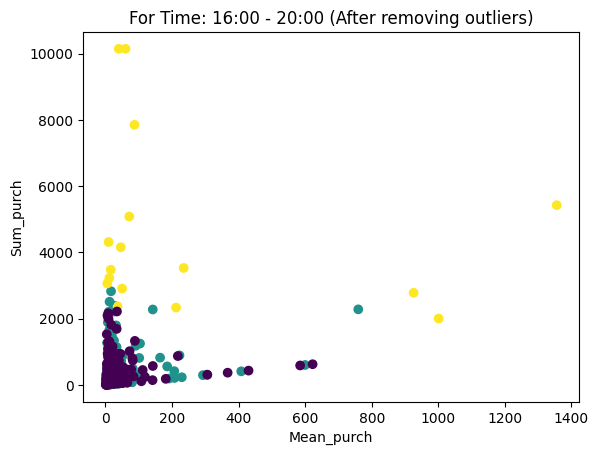

In [ ]:
plt.scatter(df_16_20_new['Mean_purch'], df_16_20_new['Sum_purch'], c=df_16_20_new['cluster_labels'], cmap='viridis')
plt.title("For Time: 16:00 - 20:00 (After removing outliers)")
plt.xlabel('Mean_purch')
plt.ylabel('Sum_purch')
plt.show()

In [ ]:
t_16_20 = descrip_dict(og_16_20,df_16_20_new)
t_16_20 = processlis(t_16_20)
t_16_20

[     CustomerID                                        Description
 0             2  [72 SWEETHEART FAIRY CAKE CASES, 60 CAKE CASES...
 1             6  [CERAMIC CAKE STAND + HANGING CAKES, MINI CAKE...
 2            29  [JUMBO STORAGE BAG SUKI, JUMBO BAG WOODLAND AN...
 3            47  [SET OF 3 CAKE TINS SKETCHBOOK, TEA BAG PLATE ...
 4            56  [GLASS APOTHECARY BOTTLE TONIC, GLASS APOTHECA...
 ..          ...                                                ...
 291        2249  [REGENCY SUGAR TONGS, REGENCY TEA PLATE ROSES ...
 292        2254  [REGENCY TEA PLATE ROSES , REGENCY TEA PLATE G...
 293        2275  [SMALL HANGING IVORY/RED WOOD BIRD, HANGING HE...
 294        2280  [4 PEAR BOTANICAL DINNER CANDLES, SWISS CHALET...
 295        2302  [VANILLA SCENT CANDLE JEWELLED BOX, OCEAN SCEN...
 
 [296 rows x 2 columns],
      CustomerID                                        Description
 0          2282  [ZINC HERB GARDEN CONTAINER, RETRO LEAVES MAGN...
 1          2298     

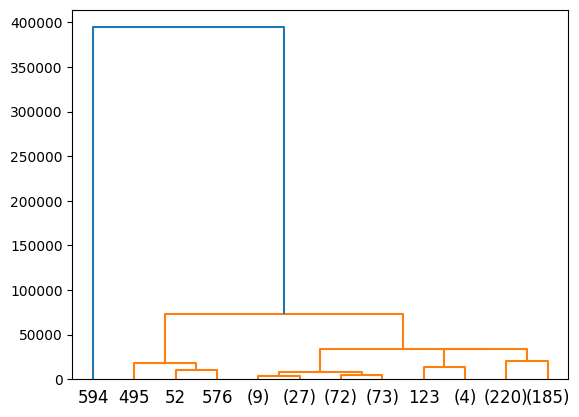

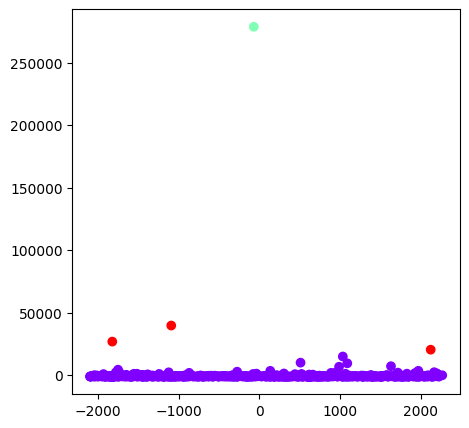

(591, 4)
(1, 4)
(3, 4)


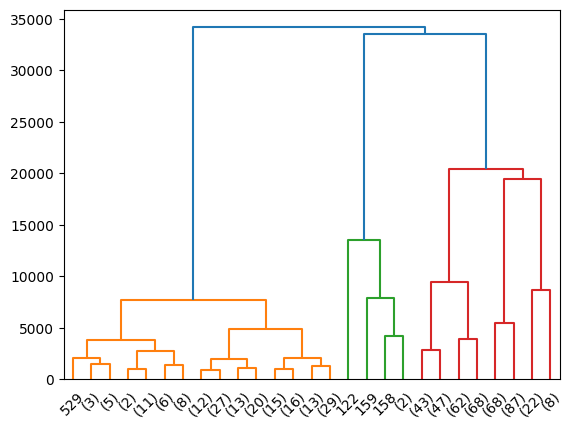

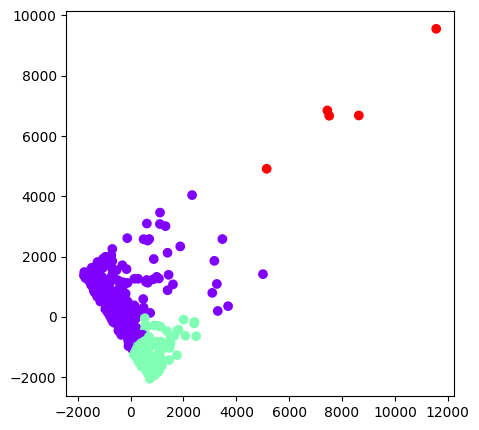

(405, 5)
(181, 5)
(5, 5)


[     CustomerID                                        Description
 0             2  [72 SWEETHEART FAIRY CAKE CASES, 60 CAKE CASES...
 1             6  [CERAMIC CAKE STAND + HANGING CAKES, MINI CAKE...
 2            29  [JUMBO STORAGE BAG SUKI, JUMBO BAG WOODLAND AN...
 3            47  [SET OF 3 CAKE TINS SKETCHBOOK, TEA BAG PLATE ...
 4            56  [GLASS APOTHECARY BOTTLE TONIC, GLASS APOTHECA...
 ..          ...                                                ...
 400        3227  [HAND OVER THE CHOCOLATE   SIGN , CHOCOLATE TH...
 401        3374  [FELTCRAFT PRINCESS LOLA DOLL, FELTCRAFT PRINC...
 402        4008  [LARGE CRYSTAL DIAMANTE HAIRSLIDE, LARGE MINT ...
 403        4011  [JUMBO BAG OWLS, JUMBO STORAGE BAG SUKI, VICTO...
 404        4088                     [PACK OF 12 WOODLAND TISSUES ]
 
 [405 rows x 2 columns],
      CustomerID                                        Description
 0          2584  [HOT WATER BOTTLE BABUSHKA , WOOD BLACK BOARD ...
 1          2796  [MU

In [ ]:
pca = PCA(n_components = 3)
pca.fit(X = dvt_16_20 )
new_dvt = pca.transform(dvt_16_20 )

new_dvt = pd.DataFrame(data = new_dvt,columns = ['X0','X1','X2'])
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage='ward').fit(new_dvt)

plot_dendrogram(model, truncate_mode="level", p=4)

dict_16_20 =  Agglocls(new_dvt,3)

final_dvt_16_20 = dict_16_20[0]
pca_16_20 = PCA(n_components = 3)
pca_16_20.fit(X = final_dvt_16_20)
final_dvt_16_20 = pca_16_20.transform(final_dvt_16_20)
final_dvt_16_20 = pd.DataFrame(data = final_dvt_16_20,columns = ['X0','X1','X2'])
AggloDendo(final_dvt_16_20)

dict_16_20_final =  AggloPca(final_dvt_16_20,3,dvt_16_20,'X1','X0')

t_16_20_agg = descrip_dict(og_16_20,final_dvt_16_20)
t_16_20_agg = processlis(t_16_20_agg)
t_16_20_agg


In [ ]:
#Rules_dict and cluster_dict : Rules_dict is a dictionary that contains dictionaries titled by the datasplt ie.feb2011. Each of
#these dictionaries caontain two keys called K-means and Agglo for agglomerative which correspond to respective clusters
#they are followed by two nested tuples. Fie=rst index represents cluster number and second index we have :
#0 for frequent itemset 
#1 for rule set

#cluster_dict contains information of clustercount for each dataframes

In [ ]:
Cluster_dict['t_16_20'] = (len(t_16_20),len(t_16_20_agg))
dicti_t_16_20 = {}
klis = []
for i in range(Cluster_dict['t_16_20'][0]):
  temp = apriori_rules(t_16_20[i],0.075)
  klis.append(temp)
alis = []
for i in range(Cluster_dict['t_16_20'][1]):
  temp = apriori_rules(t_16_20_agg[i],0.075)
  alis.append(temp)
#apriori_rules(1_agg[0],0.075)
dicti_t_16_20['K-means'] = klis
dicti_t_16_20['Agglo'] = alis

Rules_dict['t_16_20'] = dicti_t_16_20

a = Rules_dict['dec2011']['Agglo'][0][0]
print(a)

    support                                        itemsets
0      0.09                     (ALARM CLOCK BAKELIKE PINK)
1      0.12                 (BAKING SET 9 PIECE RETROSPOT )
2      0.08                  (BICYCLE PUNCTURE REPAIR KIT )
3      0.08                        (BLUE HARMONICA IN BOX )
4      0.10                     (JUMBO BAG 50'S CHRISTMAS )
5      0.08                        (JUMBO BAG PAISLEY PARK)
6      0.09                       (JUMBO BAG RED RETROSPOT)
7      0.08               (PAPER CHAIN KIT 50'S CHRISTMAS )
8      0.08             (PAPER CHAIN KIT VINTAGE CHRISTMAS)
9      0.42                                       (POSTAGE)
10     0.20                            (RABBIT NIGHT LIGHT)
11     0.09                      (RED RETROSPOT MINI CASES)
12     0.09                 (RED TOADSTOOL LED NIGHT LIGHT)
13     0.11              (RETROSPOT TEA SET CERAMIC 11 PC )
14     0.09           (ROUND SNACK BOXES SET OF4 WOODLAND )
15     0.08              (TRADITIONAL PI

In [ ]:
def getsupport(clustering,parameter):
  clustercounts = Cluster_dict[parameter]
  if(clustering == 'K-means'):
    z = clustercounts[0]
  else:
    z = clustercounts[1]

  listi = []
  for i in range(z):
    out = Rules_dict[parameter][clustering][z][0]
    out = out.sort_values(by = 'support')
    if(out.to_numpy().shape[0]>5):
      out = out.iloc[:5]
    listi.append(out)



# APRIORI

In [ ]:
!pip install apyori

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for apyori: filename=apyori-1.1.2-py3-none-any.whl size=5976 sha256=702f0c29ff9ee2da5d6bb71db86ce63c3d8601fe3039d608b48475940906ec09
  Stored in directory: /root/.cache/pip/wheels/32/2a/54/10c595515f385f3726642b10c60bf788029e8f3a1323e3913a
Successfully built apyori


In [ ]:
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

import itertools  
n_clusters = len(dec2010)


transactions = dec2010[0]["Description"].to_numpy()

te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df = pd.DataFrame(te_ary, columns=te.columns_)

# Generating frequent itemsets
frequent_itemsets = apriori(df, min_support=0.05, use_colnames=True)

# Generating association rules
rules = association_rules(frequent_itemsets, metric='lift', min_threshold=1)

# Displaying the frequent itemsets and association rules
print("Frequent Itemsets:\n", pd.DataFrame(frequent_itemsets))
print("\nAssociation Rules:\n", rules)

Frequent Itemsets:
      support                                           itemsets
0   0.052109                  (60 CAKE CASES VINTAGE CHRISTMAS)
1   0.057072                       (ALARM CLOCK BAKELIKE GREEN)
2   0.094293                    (ASSORTED COLOUR BIRD ORNAMENT)
3   0.066998                      (CHICK GREY HOT WATER BOTTLE)
4   0.101737                       (CHOCOLATE HOT WATER BOTTLE)
5   0.064516                            (DOORMAT RED RETROSPOT)
6   0.059553                               (DOORMAT UNION FLAG)
7   0.084367                       (FAWN BLUE HOT WATER BOTTLE)
8   0.069479                      (GREY HEART HOT WATER BOTTLE)
9   0.119107                      (HAND WARMER BABUSHKA DESIGN)
10  0.086849                          (HAND WARMER BIRD DESIGN)
11  0.059553                           (HAND WARMER OWL DESIGN)
12  0.054591                        (HAND WARMER RED RETROSPOT)
13  0.066998                    (HAND WARMER SCOTTY DOG DESIGN)
14  0.084367        